In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from torch.utils.data.dataloader import default_collate

from datasets.syn_signs_loader import syn_signs
from models.gtsrb_cnn import GTSRB_CNN

device = torch.device("cpu")
batch_size = 64
pin_memory = False

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    pin_memory = True

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((48, 48)),
                    # transforms.Normalize((0.5,), (0.5,)),
            ])

target_trainset = datasets.GTSRB(root = "./data", split = "train", download = True, transform = transform)
target_testset = datasets.GTSRB(root = "./data", split = "test", download = True, transform = transform)

In [3]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(target_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
# split = 1280
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

target_trainloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
target_valloader = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)
target_testloader = torch.utils.data.DataLoader(target_testset, batch_size = batch_size
                                                    , shuffle = True, num_workers = 2, pin_memory = pin_memory)

print("Target Train set size = %d, Val set size = %d, Test set size = %d" % (len(target_trainloader), 
                                                                      len(target_valloader), len(target_testloader)))

Target Train set size = 333, Val set size = 84, Test set size = 198


In [4]:
num_train = len(target_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = 1280
train_index, val_index = indices[:split], indices[split:] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

target_trainloader_semi = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
target_valloader_semi = torch.utils.data.DataLoader(target_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)
target_testloader_semi = torch.utils.data.DataLoader(target_testset, batch_size = batch_size
                                                    , shuffle = True, num_workers = 2, pin_memory = pin_memory)

print("Target Semisupervised Train set size = %d, Val set size = %d, Test set size = %d" % (len(target_trainloader_semi), 
                                                                      len(target_valloader_semi), len(target_testloader_semi)))

Target Semisupervised Train set size = 20, Val set size = 397, Test set size = 198


In [5]:
source_trainset = syn_signs(root = "./data/syn_signs/Images", transform = transform)

In [6]:
# obtain training indices that will be used for validation
val_size = 0.2
num_train = len(source_trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(val_size * num_train))
split = num_train - 100000
train_index, val_index = indices[split:], indices[:split] # define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
val_sampler = SubsetRandomSampler(val_index)

source_trainloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = train_sampler, pin_memory = pin_memory)
source_valloader = torch.utils.data.DataLoader(source_trainset, batch_size = batch_size
                                                    , num_workers = 2, sampler = val_sampler, pin_memory = pin_memory)

print("Source Train set size = %d, Val set size = %d" % (len(source_trainloader), len(source_valloader)))

Source Train set size = 1563, Val set size = 353


Source Dataset


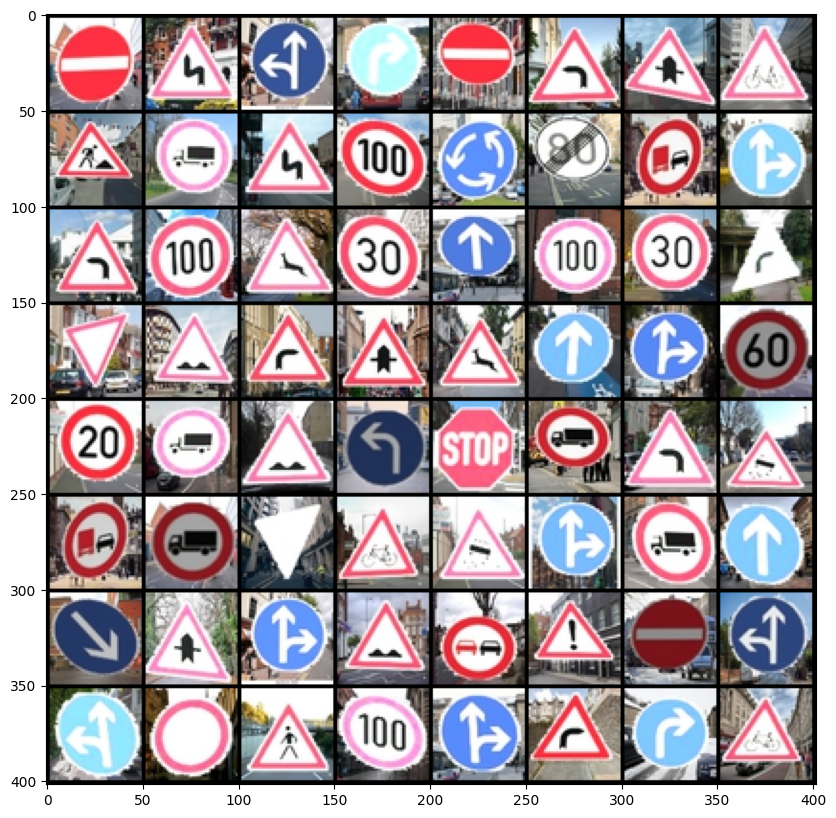

Target Dataset


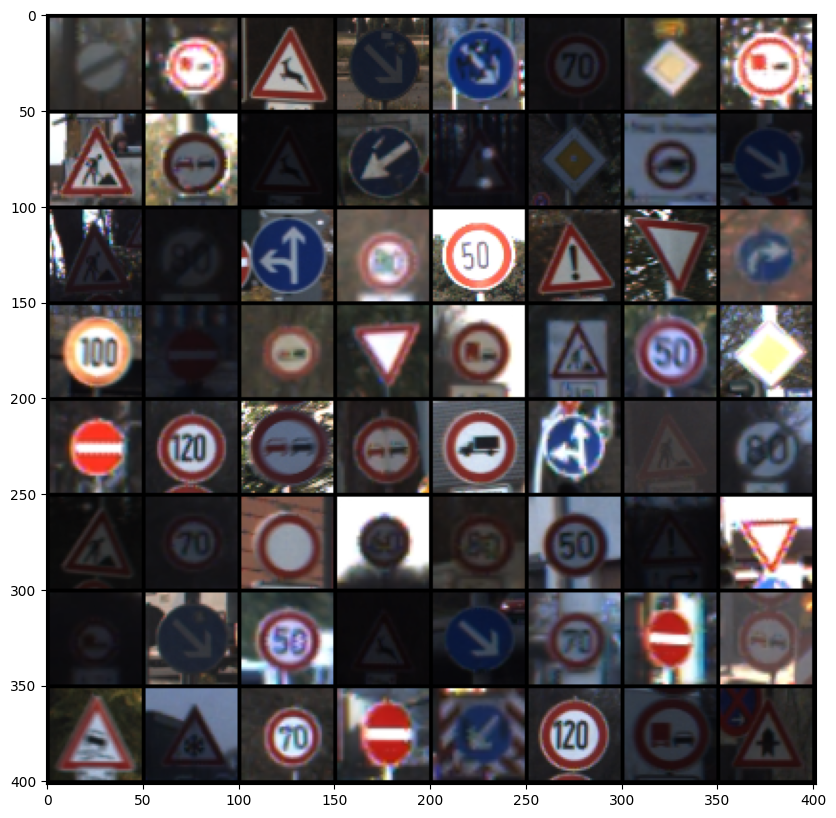

In [7]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random source training images
dataiter = iter(source_trainloader)
images, labels = dataiter.__next__()

# show images
print("Source Dataset")
imshow(torchvision.utils.make_grid(images))

# get some random target training images
dataiter = iter(target_trainloader)
images, labels = dataiter.__next__()

# show images
print("Target Dataset")
imshow(torchvision.utils.make_grid(images))

In [8]:
def plot_loss(losses, title):
    plt.plot(range(len(losses)), losses)
    plt.title(title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

In [9]:
def train(train_loaders, val_loaders, test_loader, model, optimizer, criteria, epochs = 25, 
          model_save_path = "models/best_model.pt", scheduler = None, semisupervised = False, grl = True, mean_loss = False, fixed_alpha = None, fixed_lr = False):    
    train_losses = []
    train_source_label_losses = []
    train_source_domain_losses = []
    train_target_domain_losses = []
    train_target_label_losses = []
    train_mean_losses = []
    val_losses = []
    val_source_label_losses = []
    val_target_label_losses = []
    min_val_loss = np.Inf
    
    lamda = 10
    lr0 = 0.01
    beta = 0.75

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        len_dataloader = min(len(train_loaders[0]), len(train_loaders[1]))
        pbar = tqdm(total = len_dataloader, position = 0, leave = True)
       
        train_loss = 0
        train_source_label_loss = 0
        train_source_domain_loss = 0
        train_target_domain_loss = 0
        train_target_label_loss = 0
        train_mean_loss = 0
        val_loss = 0
        val_source_label_loss = 0
        val_target_label_loss = 0
    
        source_iter = iter(train_loaders[0])
        target_iter = iter(train_loaders[1])
#         for batch_idx, (data, target) in enumerate(train_loaders[0]):
        for batch_idx in range(len_dataloader):
            source_data, source_labels = source_iter.__next__()
            target_data, target_labels = target_iter.__next__()
            
            p = float(batch_idx + epoch * len_dataloader) / (epochs * len_dataloader)
            if fixed_alpha is None:
                alpha = (2. / (1. + np.exp(-lamda * p))) - 1
            else:
                alpha = fixed_alpha
            
            if not fixed_lr:
                for g in optimizer.param_groups:
                    g["lr"] = lr0 / np.power((1 + lamda * p), beta)
            
            source_domain_labels = torch.zeros(source_data.shape[0], device = device)
            target_domain_labels = torch.ones(target_data.shape[0], device = device)

            # if torch.cuda.is_available():
            #     # print("Using CUDA")
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data, target_labels = target_data.to(device), target_labels.to(device)
            
            optimizer.zero_grad()
            source_feats, source_classes, source_domains = model(source_data, alpha)
            label_loss = criteria[0](source_classes, source_labels)
            source_domain_loss = criteria[1](source_domains[:, 0], source_domain_labels)
            
            target_feats, target_classes, target_domains = model(target_data, alpha)
            target_domain_loss = criteria[1](target_domains[:, 0], target_domain_labels)
            target_label_loss = criteria[0](target_classes, target_labels)
            
            loss = label_loss 
            if grl:
                loss = loss + source_domain_loss + target_domain_loss
            if semisupervised:
                loss = loss + target_label_loss
            if mean_loss:
                mean_loss_val = torch.sum(torch.abs(torch.mean(target_feats, axis = 1) - torch.mean(source_feats, axis = 1)))
                loss = loss + alpha * mean_loss_val
            
            loss.backward()
            optimizer.step()

            train_source_label_loss += label_loss.cpu().data.item() * source_labels.shape[0]
            train_source_domain_loss += source_domain_loss.cpu().data.item() * source_domain_labels.shape[0]
            train_target_domain_loss += target_domain_loss.cpu().data.item() * target_domain_labels.shape[0]
            train_loss += loss.cpu().data.item()
            train_target_label_loss += target_label_loss.cpu().data.item() * target_labels.shape[0]
            if mean_loss:
                train_mean_loss += mean_loss_val.cpu().data.item()
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'
            
        train_loss /= len_dataloader
        train_source_label_loss /= len_dataloader
        train_source_domain_loss /= len_dataloader
        train_target_domain_loss /= len_dataloader
        train_target_label_loss /= len_dataloader
        train_mean_loss /= len_dataloader
        train_losses.append(train_loss)
        train_source_label_losses.append(train_source_label_loss)
        train_source_domain_losses.append(train_source_domain_loss)
        train_target_domain_losses.append(train_target_domain_loss)
        train_target_label_losses.append(train_target_label_loss)
        train_mean_losses.append(train_mean_loss)
        
        if scheduler is not None:
            scheduler.step()     
            
#         if train_loss < min_val_loss:
#             min_val_loss = train_loss
#             torch.save(model.state_dict(), model_save_path)

        model.eval()
        with torch.no_grad():
            len_val_dataloader = min(len(val_loaders[0]), len(val_loaders[1]))
            source_val_iter = iter(val_loaders[0])
            target_val_iter = iter(val_loaders[1])
            
            for batch_ix in range(len_val_dataloader):
                source_val_data, source_val_labels = source_val_iter.__next__()
                target_val_data, target_val_labels = target_val_iter.__next__()
                
                # if torch.cuda.is_available():
                source_val_data, source_val_labels = source_val_data.to(device), source_val_labels.to(device)
                target_val_data, target_val_labels = target_val_data.to(device), target_val_labels.to(device)

                _, source_pred_labels, source_pred_domains = model(source_val_data, alpha)
                source_label_loss = criteria[0](source_pred_labels, source_val_labels)          
                _, target_pred_labels, target_pred_domains = model(target_val_data, alpha)
                target_label_loss = criteria[0](target_pred_labels, target_val_labels)
                
                loss = source_label_loss + target_label_loss
                val_source_label_loss += source_label_loss.cpu().data.item() * source_val_data.shape[0]
                val_target_label_loss += target_label_loss.cpu().data.item() * target_val_data.shape[0]
                val_loss += loss.cpu().data.item()
                # source_label_loss.cpu().data.item() * source_val_data.shape[0] + target_label_loss.cpu().data.item() * target_val_data.shape[0]
                
            val_loss /= len_val_dataloader
            val_source_label_loss /= len_val_dataloader
            val_target_label_loss /= len_val_dataloader
            val_losses.append(val_loss)
            val_source_label_losses.append(val_source_label_loss)
            val_target_label_losses.append(val_target_label_loss)

        if val_loss < min_val_loss:
            print("Saving at epoch %d" % (epoch))
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    model_save_path = model_save_path[:-3] + "_last.pt"
    torch.save(model.state_dict(), model_save_path)
    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(train_source_label_losses, "Train Source Label Loss vs Epochs")
    plot_loss(train_source_domain_losses, "Train Source Domain Loss vs Epochs")
    plot_loss(train_target_domain_losses, "Train Target Domain Loss vs Epochs")
    plot_loss(train_target_label_losses, "Train Target Label Loss vs Epochs")
    plot_loss(train_mean_losses, "Train Mean Feature Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    plot_loss(val_source_label_losses, "Validation Source Label Loss vs Epochs")
    plot_loss(val_target_label_losses, "Validation Target Label Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

In [10]:
def evaluate(model, target_valloader, domain_adaptation = True, alpha = 1.):
    preds_labels = []
    preds_domains = []
    gt_labels = []
    model = model.cpu()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(target_valloader):
            # data.to(device)
            # target.to(device)

            if domain_adaptation:
                _, pred_labels, pred_domains = model(data, alpha)
                pred_domains = np.round(np.array(pred_domains))
                preds_domains.append(pred_domains)
            
            else:
                _, pred_labels = model(data, alpha)
                
            # pred_labels = np.argmax(np.exp(np.array(pred_labels)), axis = 1)
            softmax = torch.nn.Softmax()
            pred_labels = np.argmax(np.array(softmax(pred_labels)), axis = 1)
            
            preds_labels.append(pred_labels)
            gt_labels.append(np.array(target))

    preds_labels = np.hstack(np.array(preds_labels))
    # .reshape(-1, 1)
    gt_labels = np.hstack(np.array(gt_labels))
    # .reshape(-1, 1)   
    print("Class Label Report")
    print(classification_report(preds_labels, gt_labels))
    
    if domain_adaptation:
        preds_domains = np.vstack(np.array(preds_domains))
        # .reshape(-1)
        gt_domains = np.ones(gt_labels.shape)
        print("Domain Label Report")
        print(classification_report(preds_domains, gt_domains))

### Original

Train Loss: 4.526575088500977: 100%|████████████████████████████████████████████████████| 333/333 [00:29<00:00, 24.03it/s]

Saving at epoch 0


Train Loss: 4.526575088500977: 100%|████████████████████████████████████████████████████| 333/333 [00:32<00:00, 10.23it/s]


Epoch 0: Train Loss = 4.969516, Val Loss = 6.894649


Train Loss: 3.6278209686279297:  99%|██████████████████████████████████████████████████▋| 331/333 [00:12<00:00, 26.47it/s]

Saving at epoch 1


Train Loss: 3.1452341079711914: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.18it/s]


Epoch 1: Train Loss = 3.903258, Val Loss = 4.094881


Train Loss: 3.270109176635742:  99%|███████████████████████████████████████████████████▌| 330/333 [00:24<00:00, 18.20it/s]

Saving at epoch 2


Train Loss: 2.658025026321411: 100%|████████████████████████████████████████████████████| 333/333 [00:29<00:00, 11.39it/s]


Epoch 2: Train Loss = 3.243567, Val Loss = 3.043427


Train Loss: 3.018927812576294: 100%|███████████████████████████████████████████████████▊| 332/333 [00:16<00:00, 20.51it/s]

Saving at epoch 3


Train Loss: 2.8970413208007812: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.35it/s]


Epoch 3: Train Loss = 3.124323, Val Loss = 2.820342


Train Loss: 2.9731626510620117: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.18it/s]


Epoch 4: Train Loss = 3.086798, Val Loss = 2.878584


Train Loss: 3.289698839187622: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 20.31it/s]

Saving at epoch 5


Train Loss: 3.534698009490967: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.22it/s]


Epoch 5: Train Loss = 3.043866, Val Loss = 2.750345


Train Loss: 3.4583382606506348: 100%|██████████████████████████████████████████████████▊| 332/333 [00:16<00:00, 17.68it/s]

Saving at epoch 6


Train Loss: 2.92952036857605: 100%|█████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.70it/s]


Epoch 6: Train Loss = 3.062359, Val Loss = 2.679520


Train Loss: 3.086808919906616: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 21.99it/s]

Saving at epoch 7


Train Loss: 2.6483585834503174: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.41it/s]


Epoch 7: Train Loss = 3.055576, Val Loss = 2.560275


Train Loss: 2.9359774589538574: 100%|██████████████████████████████████████████████████▊| 332/333 [00:15<00:00, 19.62it/s]

Saving at epoch 8


Train Loss: 2.845792293548584: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.01it/s]


Epoch 8: Train Loss = 3.065932, Val Loss = 2.399530


Train Loss: 3.075007438659668: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.10it/s]


Epoch 9: Train Loss = 3.059520, Val Loss = 2.490581


Train Loss: 2.9391119480133057: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 20.84it/s]

Saving at epoch 10


Train Loss: 3.1352810859680176: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.40it/s]


Epoch 10: Train Loss = 3.089257, Val Loss = 2.392448


Train Loss: 3.188173294067383: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.39it/s]


Epoch 11: Train Loss = 3.087201, Val Loss = 2.474215


Train Loss: 3.1199469566345215: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.46it/s]


Epoch 12: Train Loss = 3.064143, Val Loss = 2.476646


Train Loss: 3.197531223297119: 100%|███████████████████████████████████████████████████▊| 332/333 [00:12<00:00, 32.04it/s]

Saving at epoch 13


Train Loss: 3.39506196975708: 100%|█████████████████████████████████████████████████████| 333/333 [00:15<00:00, 20.85it/s]


Epoch 13: Train Loss = 3.107939, Val Loss = 2.370372


Train Loss: 2.9574661254882812: 100%|██████████████████████████████████████████████████▊| 332/333 [00:17<00:00, 22.12it/s]

Saving at epoch 14


Train Loss: 2.708080291748047: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 15.08it/s]


Epoch 14: Train Loss = 3.069868, Val Loss = 2.317142


Train Loss: 3.1001360416412354: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.94it/s]

Saving at epoch 15


Train Loss: 3.0146141052246094: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.42it/s]


Epoch 15: Train Loss = 3.096210, Val Loss = 2.240552


Train Loss: 3.4587981700897217: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.75it/s]


Epoch 16: Train Loss = 3.088323, Val Loss = 2.371364


Train Loss: 3.217494487762451: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.62it/s]


Epoch 17: Train Loss = 3.117466, Val Loss = 2.541966


Train Loss: 3.4400768280029297: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.00it/s]


Epoch 18: Train Loss = 3.098332, Val Loss = 2.541610


Train Loss: 2.9915008544921875: 100%|███████████████████████████████████████████████████| 333/333 [00:31<00:00, 10.72it/s]


Epoch 19: Train Loss = 3.139914, Val Loss = 2.579002


Train Loss: 3.108161449432373: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.50it/s]


Epoch 20: Train Loss = 3.134515, Val Loss = 2.384357


Train Loss: 3.3994147777557373:  99%|██████████████████████████████████████████████████▋| 331/333 [00:15<00:00, 21.26it/s]

Saving at epoch 21


Train Loss: 3.234248161315918: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.78it/s]


Epoch 21: Train Loss = 3.151820, Val Loss = 2.235039


Train Loss: 3.2467200756073: 100%|██████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.01it/s]


Epoch 22: Train Loss = 3.147555, Val Loss = 2.417297


Train Loss: 3.215074062347412: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.21it/s]


Epoch 23: Train Loss = 3.149214, Val Loss = 2.526320


Train Loss: 3.079190731048584: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.16it/s]


Epoch 24: Train Loss = 3.129517, Val Loss = 2.709665


Train Loss: 2.734609603881836: 100%|███████████████████████████████████████████████████▊| 332/333 [00:14<00:00, 22.64it/s]

Saving at epoch 25


Train Loss: 2.946349620819092: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.51it/s]


Epoch 25: Train Loss = 3.156256, Val Loss = 2.153086


Train Loss: 3.472270965576172: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.37it/s]


Epoch 26: Train Loss = 3.166573, Val Loss = 2.195900


Train Loss: 3.13969087600708: 100%|█████████████████████████████████████████████████████| 333/333 [00:16<00:00, 22.97it/s]

Saving at epoch 27


Train Loss: 3.202421188354492: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.40it/s]


Epoch 27: Train Loss = 3.173562, Val Loss = 2.084196


Train Loss: 3.001681327819824:  99%|███████████████████████████████████████████████████▌| 330/333 [00:16<00:00, 13.79it/s]

Saving at epoch 28


Train Loss: 2.8602218627929688: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.50it/s]


Epoch 28: Train Loss = 3.186346, Val Loss = 1.979656


Train Loss: 3.0901026725769043: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 21.22it/s]

Saving at epoch 29


Train Loss: 3.4428396224975586: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.40it/s]


Epoch 29: Train Loss = 3.177651, Val Loss = 1.898491


Train Loss: 2.7892277240753174: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.76it/s]


Epoch 30: Train Loss = 3.190113, Val Loss = 1.954265


Train Loss: 3.0421948432922363: 100%|██████████████████████████████████████████████████▊| 332/333 [00:14<00:00, 26.48it/s]

Saving at epoch 31


Train Loss: 3.288149833679199: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.41it/s]


Epoch 31: Train Loss = 3.173755, Val Loss = 1.821828


Train Loss: 3.5740809440612793: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 17.62it/s]

Saving at epoch 32


Train Loss: 3.1163740158081055: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.09it/s]


Epoch 32: Train Loss = 3.207724, Val Loss = 1.711464


Train Loss: 3.1289100646972656: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.64it/s]


Epoch 33: Train Loss = 3.186454, Val Loss = 1.801166


Train Loss: 3.715949773788452: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.26it/s]


Epoch 34: Train Loss = 3.185463, Val Loss = 1.744021


Train Loss: 3.457564353942871: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.09it/s]


Epoch 35: Train Loss = 3.193219, Val Loss = 1.806818


Train Loss: 3.142202377319336:  99%|███████████████████████████████████████████████████▌| 330/333 [00:15<00:00, 21.69it/s]

Saving at epoch 36


Train Loss: 3.352309226989746: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.17it/s]


Epoch 36: Train Loss = 3.214742, Val Loss = 1.702302


Train Loss: 2.7322351932525635:  99%|██████████████████████████████████████████████████▌| 330/333 [00:13<00:00, 26.50it/s]

Saving at epoch 37


Train Loss: 3.5427889823913574: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.77it/s]


Epoch 37: Train Loss = 3.200705, Val Loss = 1.648949


Train Loss: 3.150653839111328: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 16.24it/s]

Saving at epoch 38


Train Loss: 3.289590358734131: 100%|████████████████████████████████████████████████████| 333/333 [00:28<00:00, 11.82it/s]


Epoch 38: Train Loss = 3.209073, Val Loss = 1.607210


Train Loss: 3.1454427242279053: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 15.70it/s]

Saving at epoch 39


Train Loss: 3.3097643852233887: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.65it/s]


Epoch 39: Train Loss = 3.220689, Val Loss = 1.549864


Train Loss: 3.4469287395477295: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.52it/s]


Epoch 40: Train Loss = 3.230014, Val Loss = 1.763767


Train Loss: 2.8127453327178955: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.76it/s]


Epoch 41: Train Loss = 3.214885, Val Loss = 1.620605


Train Loss: 3.3796844482421875:  99%|██████████████████████████████████████████████████▌| 330/333 [00:15<00:00, 22.30it/s]

Saving at epoch 42


Train Loss: 2.8967342376708984: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.37it/s]


Epoch 42: Train Loss = 3.196259, Val Loss = 1.395066


Train Loss: 3.47981858253479: 100%|█████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.37it/s]


Epoch 43: Train Loss = 3.213832, Val Loss = 1.412898


Train Loss: 3.2065091133117676: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.94it/s]


Epoch 44: Train Loss = 3.233112, Val Loss = 1.403655


Train Loss: 3.4339184761047363: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.76it/s]


Epoch 45: Train Loss = 3.216395, Val Loss = 1.546932


Train Loss: 3.1288206577301025: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.24it/s]


Epoch 46: Train Loss = 3.214235, Val Loss = 1.500571


Train Loss: 3.3565754890441895: 100%|██████████████████████████████████████████████████▊| 332/333 [00:15<00:00, 24.65it/s]

Saving at epoch 47


Train Loss: 3.0726571083068848: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.66it/s]


Epoch 47: Train Loss = 3.228124, Val Loss = 1.371582


Train Loss: 3.2481164932250977: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.70it/s]


Epoch 48: Train Loss = 3.202885, Val Loss = 1.410452


Train Loss: 2.891336441040039: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.11it/s]


Epoch 49: Train Loss = 3.209314, Val Loss = 1.424831


Train Loss: 3.2831099033355713: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.18it/s]


Epoch 50: Train Loss = 3.202339, Val Loss = 1.458964


Train Loss: 2.9368739128112793: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.81it/s]


Epoch 51: Train Loss = 3.217670, Val Loss = 1.612776


Train Loss: 2.9844117164611816: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.77it/s]


Epoch 52: Train Loss = 3.246281, Val Loss = 1.444789


Train Loss: 3.7853472232818604:  99%|██████████████████████████████████████████████████▋| 331/333 [00:14<00:00, 26.30it/s]

Saving at epoch 53


Train Loss: 3.443113327026367: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.84it/s]


Epoch 53: Train Loss = 3.243862, Val Loss = 1.255531


Train Loss: 3.4395077228546143: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.15it/s]


Epoch 54: Train Loss = 3.240593, Val Loss = 1.558004


Train Loss: 3.0552268028259277: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.48it/s]


Epoch 55: Train Loss = 3.215109, Val Loss = 1.309042


Train Loss: 3.3151402473449707: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.88it/s]


Epoch 56: Train Loss = 3.247393, Val Loss = 1.414293


Train Loss: 3.232189893722534: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.14it/s]


Epoch 57: Train Loss = 3.241370, Val Loss = 1.445382


Train Loss: 3.6138546466827393: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.21it/s]


Epoch 58: Train Loss = 3.224703, Val Loss = 1.295410


Train Loss: 3.284897565841675: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.74it/s]


Epoch 59: Train Loss = 3.209768, Val Loss = 1.329440


Train Loss: 3.006789207458496: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.06it/s]


Epoch 60: Train Loss = 3.238942, Val Loss = 1.356661


Train Loss: 2.8231098651885986: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.54it/s]


Epoch 61: Train Loss = 3.250757, Val Loss = 1.380816


Train Loss: 3.5389392375946045: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.44it/s]


Epoch 62: Train Loss = 3.240464, Val Loss = 1.395448


Train Loss: 3.3224549293518066: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.73it/s]


Epoch 63: Train Loss = 3.245559, Val Loss = 1.356246


Train Loss: 3.213001251220703: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.58it/s]


Epoch 64: Train Loss = 3.205623, Val Loss = 1.275197


Train Loss: 2.953550100326538: 100%|███████████████████████████████████████████████████▊| 332/333 [00:13<00:00, 29.74it/s]

Saving at epoch 65


Train Loss: 3.6690258979797363: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.35it/s]


Epoch 65: Train Loss = 3.233560, Val Loss = 1.215303


Train Loss: 3.0698790550231934: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.14it/s]


Epoch 66: Train Loss = 3.222159, Val Loss = 1.257926


Train Loss: 3.5365612506866455: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 15.07it/s]


Epoch 67: Train Loss = 3.241966, Val Loss = 1.318007


Train Loss: 3.2771294116973877: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.45it/s]


Epoch 68: Train Loss = 3.230642, Val Loss = 1.315154


Train Loss: 3.688122034072876: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.78it/s]


Epoch 69: Train Loss = 3.247581, Val Loss = 1.358357


Train Loss: 3.1067779064178467: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.12it/s]


Epoch 70: Train Loss = 3.256173, Val Loss = 1.277897


Train Loss: 3.507533073425293:  99%|███████████████████████████████████████████████████▋| 331/333 [00:16<00:00, 16.90it/s]

Saving at epoch 71


Train Loss: 3.131225109100342: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.22it/s]


Epoch 71: Train Loss = 3.244475, Val Loss = 1.167735


Train Loss: 2.851139545440674: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.89it/s]


Epoch 72: Train Loss = 3.228929, Val Loss = 1.173651


Train Loss: 3.256922721862793: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.94it/s]


Epoch 73: Train Loss = 3.231585, Val Loss = 1.308679


Train Loss: 3.279327392578125: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.80it/s]


Epoch 74: Train Loss = 3.234421, Val Loss = 1.212608


Train Loss: 3.3858163356781006: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 27.85it/s]

Saving at epoch 75


Train Loss: 3.4102864265441895: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 15.88it/s]


Epoch 75: Train Loss = 3.226652, Val Loss = 1.164532


Train Loss: 2.7683825492858887: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.62it/s]


Epoch 76: Train Loss = 3.220804, Val Loss = 1.182739


Train Loss: 2.9020590782165527: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 15.86it/s]


Epoch 77: Train Loss = 3.245149, Val Loss = 1.216517


Train Loss: 3.4441781044006348: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 15.89it/s]


Epoch 78: Train Loss = 3.254733, Val Loss = 1.283710


Train Loss: 3.4763028621673584: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.73it/s]


Epoch 79: Train Loss = 3.254779, Val Loss = 1.234488


Train Loss: 3.4973180294036865: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.71it/s]


Epoch 80: Train Loss = 3.259366, Val Loss = 1.260044


Train Loss: 3.609431028366089: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.39it/s]


Epoch 81: Train Loss = 3.238213, Val Loss = 1.171221


Train Loss: 3.3015692234039307: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.74it/s]


Epoch 82: Train Loss = 3.234709, Val Loss = 1.193429


Train Loss: 3.2996790409088135: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.46it/s]


Epoch 83: Train Loss = 3.251265, Val Loss = 1.213366


Train Loss: 3.617985486984253: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.46it/s]


Epoch 84: Train Loss = 3.233219, Val Loss = 1.186365


Train Loss: 3.644591808319092: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.76it/s]


Epoch 85: Train Loss = 3.218041, Val Loss = 1.169375


Train Loss: 3.4742860794067383: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.90it/s]


Epoch 86: Train Loss = 3.248932, Val Loss = 1.192078


Train Loss: 3.010507583618164: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 29.10it/s]

Saving at epoch 87


Train Loss: 3.09909987449646: 100%|█████████████████████████████████████████████████████| 333/333 [00:16<00:00, 19.96it/s]


Epoch 87: Train Loss = 3.236887, Val Loss = 1.133146


Train Loss: 3.0558056831359863: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.73it/s]


Epoch 88: Train Loss = 3.230169, Val Loss = 1.185844


Train Loss: 2.920109748840332: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.43it/s]


Epoch 89: Train Loss = 3.230706, Val Loss = 1.156897


Train Loss: 3.2108659744262695: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.35it/s]


Epoch 90: Train Loss = 3.272891, Val Loss = 1.333768


Train Loss: 3.358783721923828: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.84it/s]


Epoch 91: Train Loss = 3.263044, Val Loss = 1.212142


Train Loss: 2.9574553966522217: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.36it/s]


Epoch 92: Train Loss = 3.267890, Val Loss = 1.186122


Train Loss: 3.277979850769043: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.58it/s]


Epoch 93: Train Loss = 3.237976, Val Loss = 1.202106


Train Loss: 3.3346235752105713: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.28it/s]

Saving at epoch 94


Train Loss: 2.831496238708496: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.10it/s]


Epoch 94: Train Loss = 3.258641, Val Loss = 1.129919


Train Loss: 2.711362838745117: 100%|████████████████████████████████████████████████████| 333/333 [00:27<00:00, 12.02it/s]


Epoch 95: Train Loss = 3.238052, Val Loss = 1.262588


Train Loss: 3.273094654083252: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 12.09it/s]

Saving at epoch 96


Train Loss: 2.708064079284668: 100%|████████████████████████████████████████████████████| 333/333 [00:29<00:00, 11.24it/s]


Epoch 96: Train Loss = 3.234015, Val Loss = 1.117902


Train Loss: 2.8786377906799316: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.20it/s]


Epoch 97: Train Loss = 3.219305, Val Loss = 1.117950


Train Loss: 3.298121690750122:  99%|███████████████████████████████████████████████████▌| 330/333 [00:20<00:00, 23.91it/s]

Saving at epoch 98


Train Loss: 3.871934175491333: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.46it/s]


Epoch 98: Train Loss = 3.247186, Val Loss = 1.109778


Train Loss: 3.454780340194702: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.17it/s]

Epoch 99: Train Loss = 3.236736, Val Loss = 1.169063


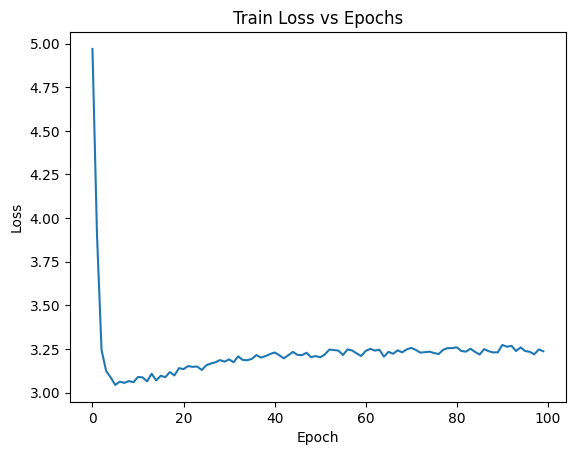

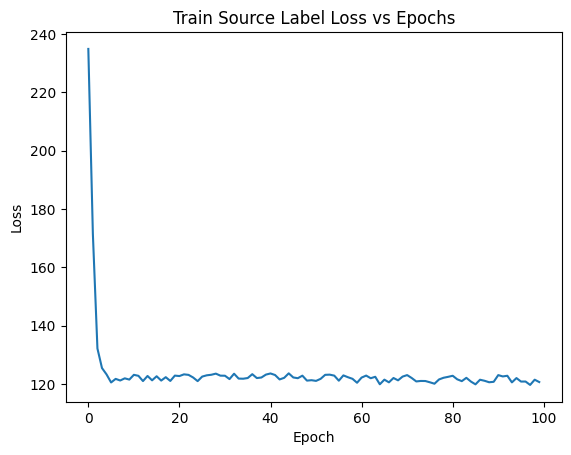

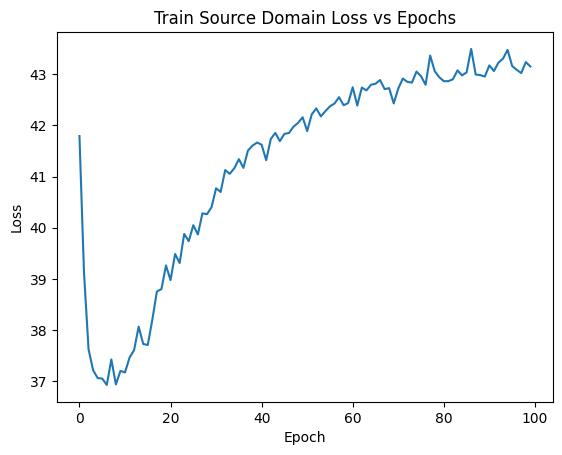

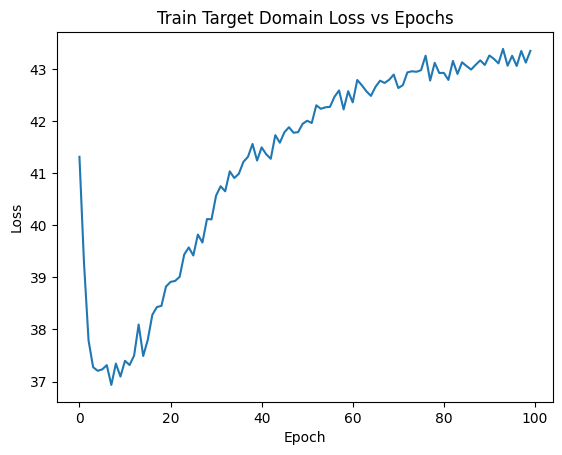

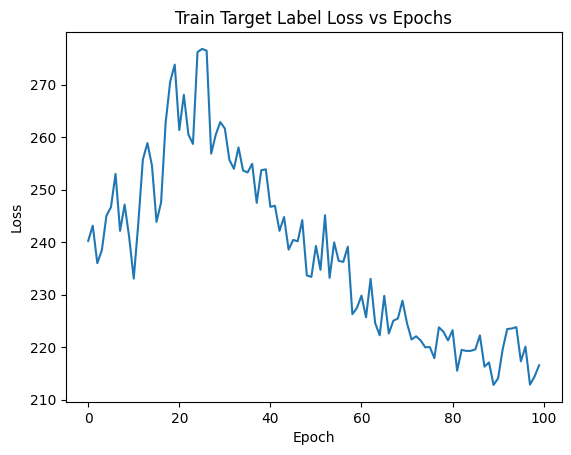

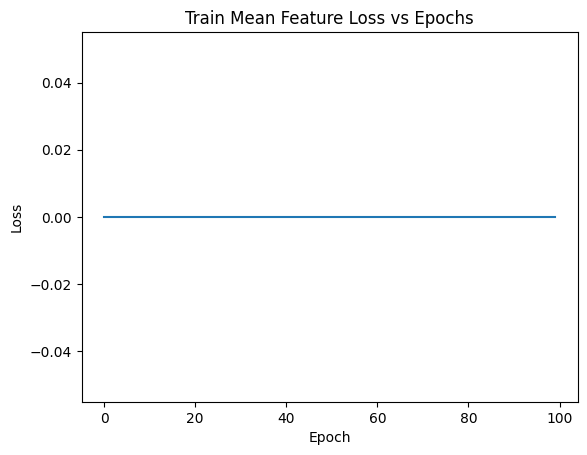

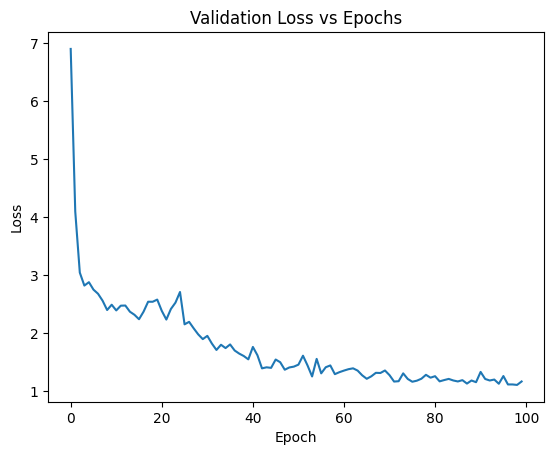

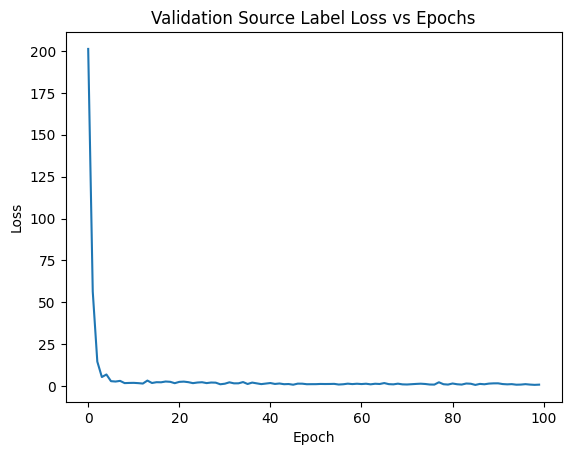

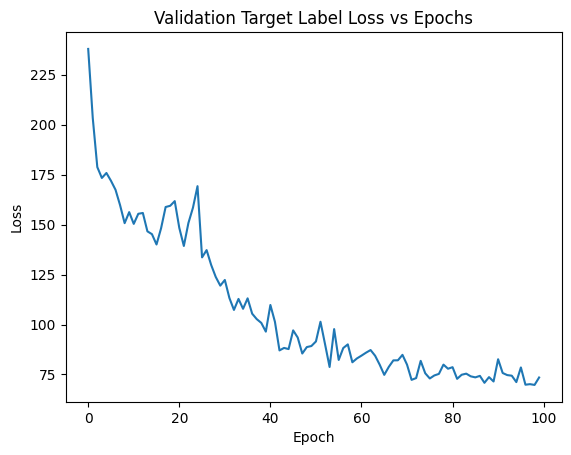

In [11]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader_semi, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt", 
                                  scheduler, semisupervised = False, grl = True, mean_loss = False, fixed_alpha = None, fixed_lr = False)

In [12]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.82      0.19      0.30       150
           1       0.61      0.92      0.73       189
           2       0.55      0.84      0.67       197
           3       0.72      0.62      0.67       220
           4       0.78      0.70      0.74       318
           5       0.40      0.49      0.44       198
           6       0.45      0.51      0.48        45
           7       0.36      0.70      0.47        98
           8       0.52      0.55      0.53       194
           9       0.79      0.89      0.83       167
          10       0.65      0.96      0.78       190
          11       0.79      0.95      0.86       153
          12       0.67      1.00      0.80       190
          13       0.86      0.95      0.90       274
          14       0.98      0.89      0.93       127
          15       0.81      0.91      0.86        75
          16       0.95      0.40      0.57       136
        

### Fixed alpha = 1.0

Train Loss: 5.011249542236328:  99%|███████████████████████████████████████████████████▋| 331/333 [00:16<00:00, 19.90it/s]

Saving at epoch 0


Train Loss: 5.011225700378418: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.10it/s]


Epoch 0: Train Loss = 5.093652, Val Loss = 7.206666


Train Loss: 3.781263828277588: 100%|███████████████████████████████████████████████████▊| 332/333 [00:17<00:00, 21.89it/s]

Saving at epoch 1


Train Loss: 3.4214491844177246: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.99it/s]


Epoch 1: Train Loss = 4.450865, Val Loss = 4.846017


Train Loss: 3.43851900100708: 100%|█████████████████████████████████████████████████████| 333/333 [00:23<00:00, 15.38it/s]

Saving at epoch 2


Train Loss: 3.365921974182129: 100%|████████████████████████████████████████████████████| 333/333 [00:29<00:00, 11.41it/s]


Epoch 2: Train Loss = 3.592498, Val Loss = 3.797728


Train Loss: 3.3038413524627686:  99%|██████████████████████████████████████████████████▌| 330/333 [00:19<00:00, 13.78it/s]

Saving at epoch 3


Train Loss: 3.5798115730285645: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 12.94it/s]


Epoch 3: Train Loss = 3.360352, Val Loss = 3.510280


Train Loss: 3.011582612991333: 100%|████████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.27it/s]


Epoch 4: Train Loss = 3.274934, Val Loss = 3.595490


Train Loss: 3.1953542232513428:  99%|██████████████████████████████████████████████████▌| 330/333 [00:19<00:00, 15.57it/s]

Saving at epoch 5


Train Loss: 3.2900607585906982: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.78it/s]


Epoch 5: Train Loss = 3.267094, Val Loss = 3.201169


Train Loss: 2.7407631874084473: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 17.36it/s]

Saving at epoch 6


Train Loss: 3.4866795539855957: 100%|███████████████████████████████████████████████████| 333/333 [00:29<00:00, 11.32it/s]


Epoch 6: Train Loss = 3.233870, Val Loss = 3.086085


Train Loss: 2.9401674270629883: 100%|██████████████████████████████████████████████████▊| 332/333 [00:19<00:00, 17.47it/s]

Saving at epoch 7


Train Loss: 2.8956832885742188: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.82it/s]


Epoch 7: Train Loss = 3.228853, Val Loss = 2.749924


Train Loss: 3.039783000946045: 100%|████████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.25it/s]


Epoch 8: Train Loss = 3.209721, Val Loss = 2.789592


Train Loss: 3.000741958618164: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.37it/s]


Epoch 9: Train Loss = 3.198379, Val Loss = 3.176356


Train Loss: 2.7126569747924805: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.76it/s]


Epoch 10: Train Loss = 3.215243, Val Loss = 3.432678


Train Loss: 3.2690272331237793: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.64it/s]


Epoch 11: Train Loss = 3.194247, Val Loss = 3.381229


Train Loss: 2.7851459980010986: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.00it/s]


Epoch 12: Train Loss = 3.157345, Val Loss = 2.965107


Train Loss: 3.379302501678467: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.81it/s]


Epoch 13: Train Loss = 3.190180, Val Loss = 3.015959


Train Loss: 3.2490806579589844: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.74it/s]


Epoch 14: Train Loss = 3.175129, Val Loss = 3.182853


Train Loss: 3.119363784790039: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.24it/s]


Epoch 15: Train Loss = 3.205970, Val Loss = 2.866108


Train Loss: 3.2965173721313477: 100%|███████████████████████████████████████████████████| 333/333 [00:27<00:00, 12.30it/s]


Epoch 16: Train Loss = 3.189787, Val Loss = 3.011660


Train Loss: 3.1945042610168457: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.79it/s]


Epoch 17: Train Loss = 3.216621, Val Loss = 2.911361


Train Loss: 3.0782806873321533: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.74it/s]


Epoch 18: Train Loss = 3.201106, Val Loss = 2.830123


Train Loss: 2.8775434494018555: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 25.22it/s]

Saving at epoch 19


Train Loss: 2.931623935699463: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.47it/s]


Epoch 19: Train Loss = 3.216611, Val Loss = 2.679586


Train Loss: 3.3127546310424805: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.74it/s]


Epoch 20: Train Loss = 3.217422, Val Loss = 2.956982


Train Loss: 2.9750893115997314: 100%|██████████████████████████████████████████████████▊| 332/333 [00:20<00:00, 19.39it/s]

Saving at epoch 21


Train Loss: 3.529282331466675: 100%|████████████████████████████████████████████████████| 333/333 [00:25<00:00, 12.92it/s]


Epoch 21: Train Loss = 3.202831, Val Loss = 2.586137


Train Loss: 3.345791816711426: 100%|████████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.28it/s]


Epoch 22: Train Loss = 3.189823, Val Loss = 2.590732


Train Loss: 3.4300262928009033: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 15.12it/s]


Epoch 23: Train Loss = 3.172033, Val Loss = 2.597249


Train Loss: 3.406351089477539: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.61it/s]


Epoch 24: Train Loss = 3.209441, Val Loss = 2.832804


Train Loss: 3.3615798950195312: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.02it/s]


Epoch 25: Train Loss = 3.191618, Val Loss = 2.642094


Train Loss: 3.0571703910827637:  99%|██████████████████████████████████████████████████▋| 331/333 [00:15<00:00, 22.63it/s]

Saving at epoch 26


Train Loss: 2.906067371368408: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.74it/s]


Epoch 26: Train Loss = 3.210539, Val Loss = 2.523857


Train Loss: 3.3502590656280518: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.26it/s]


Epoch 27: Train Loss = 3.205170, Val Loss = 2.710343


Train Loss: 3.6471433639526367: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.26it/s]


Epoch 28: Train Loss = 3.211459, Val Loss = 2.613347


Train Loss: 2.9971957206726074: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 21.01it/s]

Saving at epoch 29


Train Loss: 3.303574800491333: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.21it/s]


Epoch 29: Train Loss = 3.194331, Val Loss = 2.393461


Train Loss: 3.2652339935302734: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.04it/s]


Epoch 30: Train Loss = 3.214715, Val Loss = 2.516935


Train Loss: 3.53000545501709:  99%|████████████████████████████████████████████████████▋| 331/333 [00:18<00:00, 18.97it/s]

Saving at epoch 31


Train Loss: 3.2185282707214355: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.07it/s]


Epoch 31: Train Loss = 3.209867, Val Loss = 2.316100


Train Loss: 3.02321720123291: 100%|█████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.43it/s]

Saving at epoch 32


Train Loss: 3.327017307281494: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.70it/s]


Epoch 32: Train Loss = 3.224959, Val Loss = 2.294022


Train Loss: 3.106914520263672: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 17.32it/s]

Saving at epoch 33


Train Loss: 3.057116985321045: 100%|████████████████████████████████████████████████████| 333/333 [00:27<00:00, 12.27it/s]


Epoch 33: Train Loss = 3.221120, Val Loss = 2.257519


Train Loss: 3.5467429161071777: 100%|██████████████████████████████████████████████████▊| 332/333 [00:21<00:00, 17.08it/s]

Saving at epoch 34


Train Loss: 2.691295862197876: 100%|████████████████████████████████████████████████████| 333/333 [00:26<00:00, 12.60it/s]


Epoch 34: Train Loss = 3.236669, Val Loss = 2.129997


Train Loss: 2.574993133544922: 100%|████████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.26it/s]


Epoch 35: Train Loss = 3.207451, Val Loss = 2.384049


Train Loss: 3.3597540855407715: 100%|███████████████████████████████████████████████████| 333/333 [00:27<00:00, 12.26it/s]


Epoch 36: Train Loss = 3.235642, Val Loss = 2.345279


Train Loss: 3.117814540863037: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.72it/s]


Epoch 37: Train Loss = 3.207371, Val Loss = 2.161193


Train Loss: 3.7119505405426025: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 23.52it/s]

Saving at epoch 38


Train Loss: 3.2738633155822754: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.34it/s]


Epoch 38: Train Loss = 3.201648, Val Loss = 2.107970


Train Loss: 3.120452404022217: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.06it/s]


Epoch 39: Train Loss = 3.185490, Val Loss = 2.217156


Train Loss: 3.058075428009033: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.64it/s]


Epoch 40: Train Loss = 3.183600, Val Loss = 2.409938


Train Loss: 2.952362298965454: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.05it/s]


Epoch 41: Train Loss = 3.217671, Val Loss = 2.150832


Train Loss: 2.9954185485839844: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.32it/s]


Epoch 42: Train Loss = 3.223911, Val Loss = 2.506998


Train Loss: 3.0033419132232666: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.40it/s]


Epoch 43: Train Loss = 3.210261, Val Loss = 2.264549


Train Loss: 3.587106227874756: 100%|███████████████████████████████████████████████████▊| 332/333 [00:16<00:00, 24.87it/s]

Saving at epoch 44


Train Loss: 3.2725837230682373: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.07it/s]


Epoch 44: Train Loss = 3.212363, Val Loss = 2.059828


Train Loss: 3.0190510749816895: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.81it/s]


Epoch 45: Train Loss = 3.239780, Val Loss = 2.140015


Train Loss: 3.6302995681762695: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.63it/s]


Epoch 46: Train Loss = 3.213669, Val Loss = 2.101360


Train Loss: 3.2727348804473877: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.94it/s]


Epoch 47: Train Loss = 3.189186, Val Loss = 2.118181


Train Loss: 3.5201992988586426: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.81it/s]


Epoch 48: Train Loss = 3.256279, Val Loss = 2.278259


Train Loss: 2.9427289962768555: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 24.47it/s]

Saving at epoch 49


Train Loss: 2.9174842834472656: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.00it/s]


Epoch 49: Train Loss = 3.191244, Val Loss = 2.058830


Train Loss: 2.9270758628845215: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.35it/s]


Epoch 50: Train Loss = 3.219582, Val Loss = 2.181431


Train Loss: 3.1251087188720703: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.99it/s]


Epoch 51: Train Loss = 3.233695, Val Loss = 2.320335


Train Loss: 3.031850576400757:  99%|███████████████████████████████████████████████████▋| 331/333 [00:14<00:00, 28.25it/s]

Saving at epoch 52


Train Loss: 3.2737040519714355: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.02it/s]


Epoch 52: Train Loss = 3.238671, Val Loss = 2.004108


Train Loss: 3.0233912467956543: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.15it/s]


Epoch 53: Train Loss = 3.245884, Val Loss = 2.216500


Train Loss: 3.172419309616089: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.46it/s]


Epoch 54: Train Loss = 3.232548, Val Loss = 2.255515


Train Loss: 2.999582052230835: 100%|████████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.45it/s]

Saving at epoch 55


Train Loss: 3.140451669692993: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.02it/s]


Epoch 55: Train Loss = 3.239594, Val Loss = 1.976830


Train Loss: 3.4971280097961426: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.45it/s]


Epoch 56: Train Loss = 3.223364, Val Loss = 2.221435


Train Loss: 3.228766679763794: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.58it/s]


Epoch 57: Train Loss = 3.208426, Val Loss = 2.004553


Train Loss: 3.208007574081421: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.19it/s]


Epoch 58: Train Loss = 3.219890, Val Loss = 1.982019


Train Loss: 3.395933151245117: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.28it/s]


Epoch 59: Train Loss = 3.232362, Val Loss = 2.191551


Train Loss: 3.411296844482422: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.71it/s]


Epoch 60: Train Loss = 3.249823, Val Loss = 1.996857


Train Loss: 3.206483840942383: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.29it/s]


Epoch 61: Train Loss = 3.217378, Val Loss = 2.133237


Train Loss: 3.213014602661133: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.84it/s]


Epoch 62: Train Loss = 3.246705, Val Loss = 2.028469


Train Loss: 3.341348886489868: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 15.93it/s]


Epoch 63: Train Loss = 3.237476, Val Loss = 2.067367


Train Loss: 3.2011430263519287: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 27.76it/s]

Saving at epoch 64


Train Loss: 3.2120680809020996: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.05it/s]


Epoch 64: Train Loss = 3.239522, Val Loss = 1.900493


Train Loss: 3.502156972885132: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.16it/s]


Epoch 65: Train Loss = 3.246941, Val Loss = 1.973119


Train Loss: 3.7528841495513916: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.66it/s]


Epoch 66: Train Loss = 3.238852, Val Loss = 2.012119


Train Loss: 2.6991071701049805: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.82it/s]


Epoch 67: Train Loss = 3.216662, Val Loss = 1.989564


Train Loss: 3.1509437561035156: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 23.87it/s]

Saving at epoch 68


Train Loss: 3.7096879482269287: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.27it/s]


Epoch 68: Train Loss = 3.233057, Val Loss = 1.866193


Train Loss: 3.53762149810791: 100%|█████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.90it/s]


Epoch 69: Train Loss = 3.218563, Val Loss = 1.902713


Train Loss: 2.8986687660217285: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 15.03it/s]


Epoch 70: Train Loss = 3.227457, Val Loss = 1.969038


Train Loss: 3.284412145614624: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 21.90it/s]

Saving at epoch 71


Train Loss: 3.120579242706299: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.19it/s]


Epoch 71: Train Loss = 3.229172, Val Loss = 1.823213


Train Loss: 3.5083861351013184: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.61it/s]


Epoch 72: Train Loss = 3.217349, Val Loss = 2.024993


Train Loss: 3.018432855606079: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.06it/s]


Epoch 73: Train Loss = 3.246704, Val Loss = 2.087373


Train Loss: 3.14570951461792: 100%|█████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.74it/s]


Epoch 74: Train Loss = 3.214513, Val Loss = 1.938484


Train Loss: 2.868273973464966: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.77it/s]


Epoch 75: Train Loss = 3.242332, Val Loss = 2.070278


Train Loss: 3.5683412551879883: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.79it/s]


Epoch 76: Train Loss = 3.231048, Val Loss = 1.885893


Train Loss: 3.171694040298462: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.08it/s]


Epoch 77: Train Loss = 3.238368, Val Loss = 1.890723


Train Loss: 2.956615924835205: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.20it/s]


Epoch 78: Train Loss = 3.239372, Val Loss = 1.921906


Train Loss: 2.9220471382141113: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.35it/s]


Epoch 79: Train Loss = 3.245797, Val Loss = 2.005122


Train Loss: 3.3144583702087402: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.61it/s]


Epoch 80: Train Loss = 3.240573, Val Loss = 1.992750


Train Loss: 3.474130868911743: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.23it/s]


Epoch 81: Train Loss = 3.269312, Val Loss = 1.841986


Train Loss: 2.871739387512207: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.93it/s]


Epoch 82: Train Loss = 3.241355, Val Loss = 1.929134


Train Loss: 3.415396213531494: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.29it/s]


Epoch 83: Train Loss = 3.247909, Val Loss = 1.971158


Train Loss: 3.5912926197052: 100%|██████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.01it/s]


Epoch 84: Train Loss = 3.250979, Val Loss = 2.110367


Train Loss: 3.278292655944824: 100%|████████████████████████████████████████████████████| 333/333 [00:15<00:00, 20.90it/s]


Epoch 85: Train Loss = 3.232497, Val Loss = 2.061547


Train Loss: 3.0661323070526123: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.21it/s]


Epoch 86: Train Loss = 3.219826, Val Loss = 1.865207


Train Loss: 3.295301914215088: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.35it/s]


Epoch 87: Train Loss = 3.219716, Val Loss = 1.945307


Train Loss: 3.496748447418213: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.09it/s]


Epoch 88: Train Loss = 3.212400, Val Loss = 2.042782


Train Loss: 3.2019078731536865: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.47it/s]


Epoch 89: Train Loss = 3.212887, Val Loss = 1.915843


Train Loss: 3.394500732421875: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 19.94it/s]


Epoch 90: Train Loss = 3.230781, Val Loss = 2.107408


Train Loss: 3.019669532775879: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 19.84it/s]


Epoch 91: Train Loss = 3.216514, Val Loss = 2.115129


Train Loss: 3.0512185096740723: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.21it/s]


Epoch 92: Train Loss = 3.227345, Val Loss = 1.877045


Train Loss: 3.2097744941711426: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.00it/s]


Epoch 93: Train Loss = 3.231318, Val Loss = 1.840098


Train Loss: 3.122178316116333: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.08it/s]


Epoch 94: Train Loss = 3.260775, Val Loss = 2.119680


Train Loss: 3.5153989791870117: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.52it/s]


Epoch 95: Train Loss = 3.237112, Val Loss = 1.867035


Train Loss: 3.437941551208496:  99%|███████████████████████████████████████████████████▋| 331/333 [00:14<00:00, 21.71it/s]

Saving at epoch 96


Train Loss: 3.5604429244995117: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.91it/s]


Epoch 96: Train Loss = 3.207193, Val Loss = 1.797751


Train Loss: 3.3520102500915527: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.56it/s]


Epoch 97: Train Loss = 3.255461, Val Loss = 1.849127


Train Loss: 3.214468240737915: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.27it/s]


Epoch 98: Train Loss = 3.243043, Val Loss = 1.928370


Train Loss: 3.4422831535339355: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 23.30it/s]

Saving at epoch 99


Train Loss: 3.050104856491089: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.03it/s]

Epoch 99: Train Loss = 3.235320, Val Loss = 1.730038


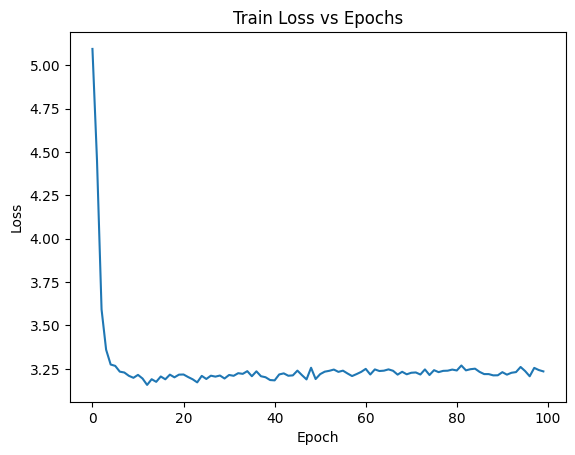

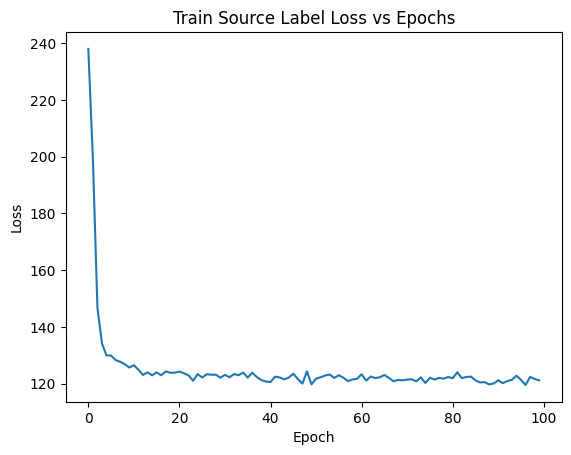

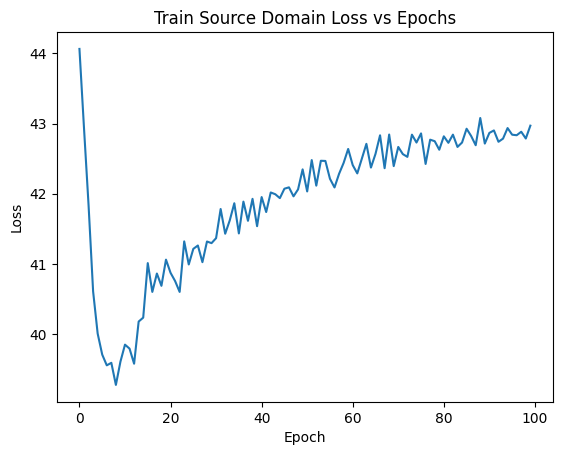

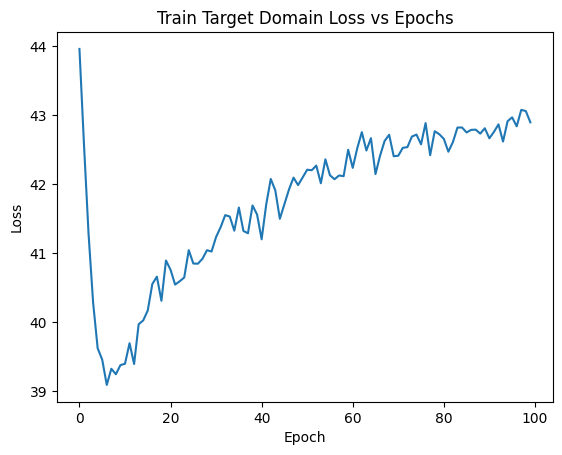

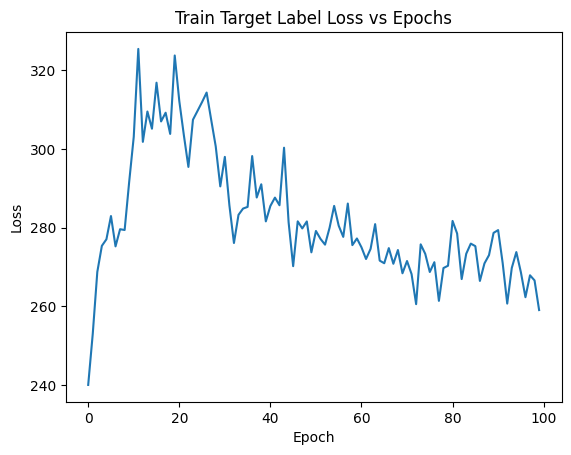

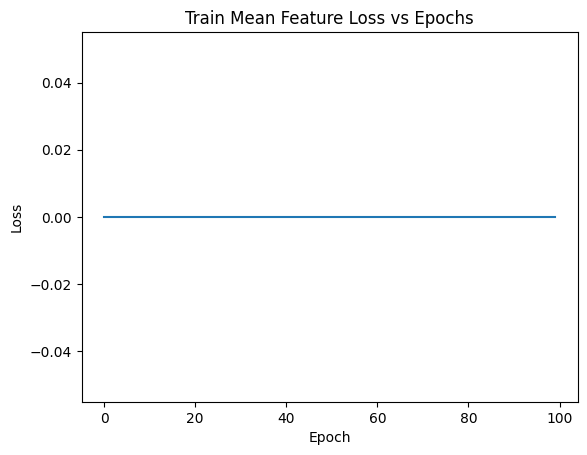

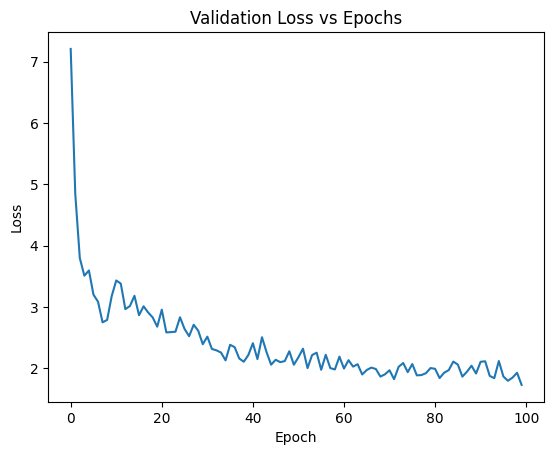

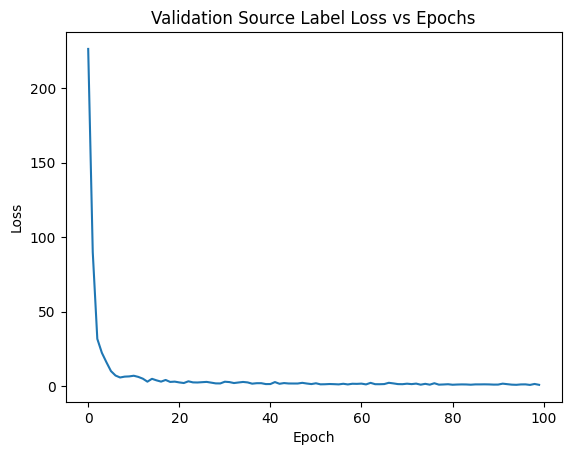

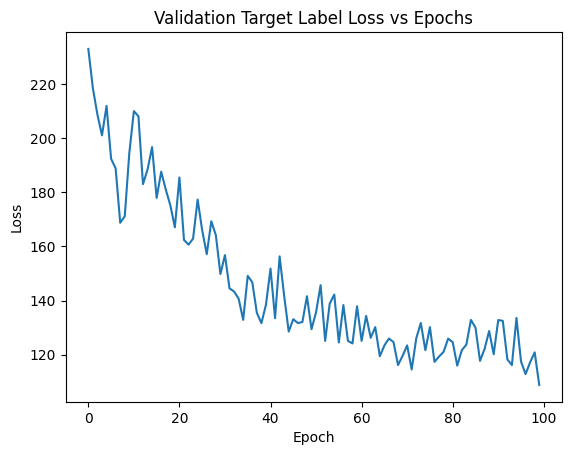

In [13]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_alpha_1.pt", 
                                  scheduler, semisupervised = False, grl = True, mean_loss = False, fixed_alpha = 1.0, fixed_lr = False)

In [14]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_alpha_1.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.82      0.22      0.35       128
           1       0.40      0.76      0.53       152
           2       0.43      0.72      0.54       177
           3       0.44      0.44      0.44       189
           4       0.49      0.82      0.61       173
           5       0.22      0.54      0.31       100
           6       0.75      0.88      0.81        43
           7       0.26      0.35      0.30       144
           8       0.26      0.33      0.29       159
           9       0.76      0.44      0.56       323
          10       0.76      0.76      0.76       279
          11       0.71      0.94      0.81       138
          12       0.74      0.98      0.84       216
          13       0.82      0.82      0.82       304
          14       0.98      0.72      0.83       157
          15       0.68      0.79      0.73        72
          16       0.90      0.29      0.44       177
        

### Fixed alpha = 0.001

Train Loss: 4.350374221801758: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 27.95it/s]

Saving at epoch 0


Train Loss: 4.305509090423584: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.23it/s]


Epoch 0: Train Loss = 4.923874, Val Loss = 6.282200


Train Loss: 3.500748634338379: 100%|███████████████████████████████████████████████████▊| 332/333 [00:12<00:00, 31.32it/s]

Saving at epoch 1
Epoch 1: Train Loss = 3.737805, Val Loss = 3.794742


Train Loss: 2.8228063583374023: 100%|██████████████████████████████████████████████████▊| 332/333 [00:31<00:00, 10.17it/s]

Saving at epoch 2


Train Loss: 2.8353004455566406: 100%|███████████████████████████████████████████████████| 333/333 [00:35<00:00,  9.46it/s]


Epoch 2: Train Loss = 3.233467, Val Loss = 3.151900


Train Loss: 2.9737935066223145:  99%|██████████████████████████████████████████████████▋| 331/333 [00:15<00:00, 18.43it/s]

Saving at epoch 3


Train Loss: 2.6491899490356445: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.72it/s]


Epoch 3: Train Loss = 3.112430, Val Loss = 3.064621


Train Loss: 3.3197474479675293:  99%|██████████████████████████████████████████████████▌| 330/333 [00:21<00:00, 10.82it/s]

Saving at epoch 4


Train Loss: 2.9734063148498535: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 12.88it/s]


Epoch 4: Train Loss = 3.057185, Val Loss = 2.952827


Train Loss: 2.9449214935302734: 100%|██████████████████████████████████████████████████▊| 332/333 [00:19<00:00, 18.29it/s]

Saving at epoch 5


Train Loss: 2.978752613067627: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.07it/s]


Epoch 5: Train Loss = 3.016323, Val Loss = 2.842741


Train Loss: 3.0579657554626465: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 12.73it/s]

Saving at epoch 6


Train Loss: 3.3864364624023438: 100%|███████████████████████████████████████████████████| 333/333 [00:26<00:00, 12.63it/s]


Epoch 6: Train Loss = 3.018099, Val Loss = 2.768066


Train Loss: 3.086991310119629: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 20.18it/s]

Saving at epoch 7


Train Loss: 2.9854602813720703: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.50it/s]


Epoch 7: Train Loss = 2.976528, Val Loss = 2.692614


Train Loss: 3.1856260299682617: 100%|██████████████████████████████████████████████████▊| 332/333 [00:20<00:00, 17.96it/s]

Saving at epoch 8


Train Loss: 2.793911933898926: 100%|████████████████████████████████████████████████████| 333/333 [00:25<00:00, 13.17it/s]


Epoch 8: Train Loss = 2.971606, Val Loss = 2.676569


Train Loss: 3.421067476272583: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.94it/s]


Epoch 9: Train Loss = 2.996715, Val Loss = 2.722919


Train Loss: 3.5045394897460938: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.28it/s]


Epoch 10: Train Loss = 2.969065, Val Loss = 2.753985


Train Loss: 2.486006736755371: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 15.96it/s]


Epoch 11: Train Loss = 2.966431, Val Loss = 2.754298


Train Loss: 3.0703303813934326: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.75it/s]


Epoch 12: Train Loss = 2.961665, Val Loss = 2.722835


Train Loss: 2.960716724395752: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 24.86it/s]

Saving at epoch 13


Train Loss: 3.463095188140869: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.79it/s]


Epoch 13: Train Loss = 2.949713, Val Loss = 2.637838


Train Loss: 3.2023985385894775: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.44it/s]


Epoch 14: Train Loss = 2.939376, Val Loss = 2.671935


Train Loss: 2.8421201705932617:  99%|██████████████████████████████████████████████████▋| 331/333 [00:15<00:00, 21.34it/s]

Saving at epoch 15


Train Loss: 2.6710128784179688: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.30it/s]


Epoch 15: Train Loss = 2.953172, Val Loss = 2.637376


Train Loss: 2.9788506031036377:  99%|██████████████████████████████████████████████████▌| 330/333 [00:18<00:00, 18.81it/s]

Saving at epoch 16


Train Loss: 2.929832935333252: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.83it/s]


Epoch 16: Train Loss = 2.952714, Val Loss = 2.589985


Train Loss: 3.249721050262451: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.65it/s]


Epoch 17: Train Loss = 2.944436, Val Loss = 2.631791


Train Loss: 2.973973035812378: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.88it/s]


Epoch 18: Train Loss = 2.969784, Val Loss = 2.714518


Train Loss: 2.867480754852295: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.63it/s]


Epoch 19: Train Loss = 2.973769, Val Loss = 2.598989


Train Loss: 2.768634796142578: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.76it/s]


Epoch 20: Train Loss = 2.935863, Val Loss = 2.649319


Train Loss: 3.111825942993164: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.46it/s]


Epoch 21: Train Loss = 2.951670, Val Loss = 2.604185


Train Loss: 2.8576369285583496: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 25.08it/s]

Saving at epoch 22


Train Loss: 3.010855197906494: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.61it/s]


Epoch 22: Train Loss = 2.951296, Val Loss = 2.586497


Train Loss: 2.7513060569763184: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 19.93it/s]


Epoch 23: Train Loss = 2.939334, Val Loss = 2.603063


Train Loss: 2.8623974323272705: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.04it/s]


Epoch 24: Train Loss = 2.950441, Val Loss = 2.628820


Train Loss: 2.968923568725586: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.56it/s]


Epoch 25: Train Loss = 2.930532, Val Loss = 2.649902


Train Loss: 3.091548204421997: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.67it/s]


Epoch 26: Train Loss = 2.939641, Val Loss = 2.627657


Train Loss: 3.12406587600708: 100%|█████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.26it/s]


Epoch 27: Train Loss = 2.948457, Val Loss = 2.593142


Train Loss: 2.7615623474121094: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.14it/s]


Epoch 28: Train Loss = 2.937742, Val Loss = 2.616990


Train Loss: 3.4399631023406982: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.01it/s]


Epoch 29: Train Loss = 2.958285, Val Loss = 2.650099


Train Loss: 3.113118886947632: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.73it/s]


Epoch 30: Train Loss = 2.942934, Val Loss = 2.651433


Train Loss: 3.0553905963897705: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 20.83it/s]


Epoch 31: Train Loss = 2.940195, Val Loss = 2.627845


Train Loss: 2.7831051349639893: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 23.17it/s]


Epoch 32: Train Loss = 2.926931, Val Loss = 2.651514


Train Loss: 2.651326894760132: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.81it/s]


Epoch 33: Train Loss = 2.924226, Val Loss = 2.613235


Train Loss: 3.0739798545837402:  99%|██████████████████████████████████████████████████▋| 331/333 [00:13<00:00, 26.94it/s]

Saving at epoch 34


Train Loss: 2.934019088745117: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.87it/s]


Epoch 34: Train Loss = 2.905166, Val Loss = 2.581139


Train Loss: 2.5167551040649414: 100%|██████████████████████████████████████████████████▊| 332/333 [00:12<00:00, 22.56it/s]

Saving at epoch 35


Train Loss: 2.868791341781616: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.72it/s]


Epoch 35: Train Loss = 2.961487, Val Loss = 2.568624


Train Loss: 3.496769666671753: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.27it/s]


Epoch 36: Train Loss = 2.930216, Val Loss = 2.569432


Train Loss: 2.5254337787628174: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.12it/s]


Epoch 37: Train Loss = 2.929778, Val Loss = 2.577927


Train Loss: 3.087266683578491:  99%|███████████████████████████████████████████████████▌| 330/333 [00:12<00:00, 28.99it/s]

Saving at epoch 38


Train Loss: 2.886939525604248: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.45it/s]


Epoch 38: Train Loss = 2.926691, Val Loss = 2.545568


Train Loss: 2.6728882789611816:  99%|██████████████████████████████████████████████████▌| 330/333 [00:16<00:00, 23.97it/s]

Saving at epoch 39


Train Loss: 2.696615219116211: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 15.89it/s]


Epoch 39: Train Loss = 2.945634, Val Loss = 2.529828


Train Loss: 2.6481130123138428: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.60it/s]


Epoch 40: Train Loss = 2.931873, Val Loss = 2.553262


Train Loss: 2.9941935539245605: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.48it/s]


Epoch 41: Train Loss = 2.937328, Val Loss = 2.534092


Train Loss: 2.87178635597229:  99%|████████████████████████████████████████████████████▋| 331/333 [00:16<00:00, 23.95it/s]

Saving at epoch 42


Train Loss: 3.1969988346099854: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.08it/s]


Epoch 42: Train Loss = 2.942645, Val Loss = 2.499972


Train Loss: 3.0002145767211914: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.34it/s]


Epoch 43: Train Loss = 2.905771, Val Loss = 2.547105


Train Loss: 2.315657615661621: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.65it/s]


Epoch 44: Train Loss = 2.945560, Val Loss = 2.514530


Train Loss: 3.015751838684082: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.24it/s]


Epoch 45: Train Loss = 2.928833, Val Loss = 2.531304


Train Loss: 2.8466241359710693: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.10it/s]


Epoch 46: Train Loss = 2.899905, Val Loss = 2.528691


Train Loss: 3.123175621032715:  99%|███████████████████████████████████████████████████▌| 330/333 [00:14<00:00, 23.38it/s]

Saving at epoch 47


Train Loss: 3.199887275695801: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.21it/s]


Epoch 47: Train Loss = 2.938787, Val Loss = 2.485525


Train Loss: 2.811627149581909: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.95it/s]


Epoch 48: Train Loss = 2.925981, Val Loss = 2.493824


Train Loss: 3.095987319946289: 100%|████████████████████████████████████████████████████| 333/333 [00:14<00:00, 27.43it/s]

Saving at epoch 49


Train Loss: 3.038043737411499: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.96it/s]


Epoch 49: Train Loss = 2.907374, Val Loss = 2.430120


Train Loss: 2.9105310440063477: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.76it/s]


Epoch 50: Train Loss = 2.921942, Val Loss = 2.478745


Train Loss: 2.8235859870910645: 100%|███████████████████████████████████████████████████| 333/333 [00:40<00:00,  8.22it/s]


Epoch 51: Train Loss = 2.917166, Val Loss = 2.499977


Train Loss: 3.117908000946045: 100%|████████████████████████████████████████████████████| 333/333 [00:37<00:00,  8.92it/s]


Epoch 52: Train Loss = 2.937082, Val Loss = 2.487705


Train Loss: 3.039921760559082: 100%|████████████████████████████████████████████████████| 333/333 [00:30<00:00, 11.03it/s]


Epoch 53: Train Loss = 2.913805, Val Loss = 2.449169


Train Loss: 3.3272464275360107: 100%|███████████████████████████████████████████████████| 333/333 [00:29<00:00, 11.48it/s]


Epoch 54: Train Loss = 2.926135, Val Loss = 2.488493


Train Loss: 2.7174417972564697: 100%|███████████████████████████████████████████████████| 333/333 [00:27<00:00, 12.10it/s]


Epoch 55: Train Loss = 2.892511, Val Loss = 2.501150


Train Loss: 2.901458501815796: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.18it/s]


Epoch 56: Train Loss = 2.925052, Val Loss = 2.505910


Train Loss: 2.784309148788452: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.58it/s]


Epoch 57: Train Loss = 2.930075, Val Loss = 2.507513


Train Loss: 2.9632673263549805: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 15.13it/s]


Epoch 58: Train Loss = 2.933558, Val Loss = 2.506481


Train Loss: 2.850429058074951: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 13.96it/s]


Epoch 59: Train Loss = 2.924597, Val Loss = 2.493347


Train Loss: 2.764925241470337: 100%|████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.74it/s]


Epoch 60: Train Loss = 2.933284, Val Loss = 2.512564


Train Loss: 2.9168806076049805: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.27it/s]


Epoch 61: Train Loss = 2.939618, Val Loss = 2.523008


Train Loss: 3.0170178413391113: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.01it/s]


Epoch 62: Train Loss = 2.927869, Val Loss = 2.520440


Train Loss: 2.9222652912139893: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.13it/s]


Epoch 63: Train Loss = 2.916428, Val Loss = 2.560413


Train Loss: 2.7678637504577637: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.65it/s]


Epoch 64: Train Loss = 2.946544, Val Loss = 2.572695


Train Loss: 3.0123159885406494: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.08it/s]


Epoch 65: Train Loss = 2.953489, Val Loss = 2.548049


Train Loss: 3.115300178527832: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.57it/s]


Epoch 66: Train Loss = 2.927991, Val Loss = 2.536716


Train Loss: 2.87502384185791: 100%|█████████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.48it/s]


Epoch 67: Train Loss = 2.975420, Val Loss = 2.527382


Train Loss: 2.8009872436523438: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.50it/s]


Epoch 68: Train Loss = 2.929900, Val Loss = 2.549932


Train Loss: 3.0346133708953857: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.49it/s]


Epoch 69: Train Loss = 2.931137, Val Loss = 2.525695


Train Loss: 2.8676352500915527: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.79it/s]


Epoch 70: Train Loss = 2.905134, Val Loss = 2.572673


Train Loss: 3.242976188659668: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.85it/s]


Epoch 71: Train Loss = 2.939487, Val Loss = 2.547299


Train Loss: 3.370314598083496: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.85it/s]


Epoch 72: Train Loss = 2.946006, Val Loss = 2.606924


Train Loss: 2.7737507820129395: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.78it/s]


Epoch 73: Train Loss = 2.932612, Val Loss = 2.530508


Train Loss: 2.905860424041748: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.91it/s]


Epoch 74: Train Loss = 2.925827, Val Loss = 2.539210


Train Loss: 3.0430638790130615: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.48it/s]


Epoch 75: Train Loss = 2.938597, Val Loss = 2.573461


Train Loss: 3.246521472930908: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.74it/s]


Epoch 76: Train Loss = 2.933832, Val Loss = 2.554288


Train Loss: 2.4804251194000244: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.40it/s]


Epoch 77: Train Loss = 2.919632, Val Loss = 2.563736


Train Loss: 2.7916295528411865: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.43it/s]


Epoch 78: Train Loss = 2.931248, Val Loss = 2.586706


Train Loss: 2.899561882019043: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.15it/s]


Epoch 79: Train Loss = 2.926595, Val Loss = 2.597120


Train Loss: 2.789051055908203: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.46it/s]


Epoch 80: Train Loss = 2.915208, Val Loss = 2.544129


Train Loss: 3.150810480117798: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.03it/s]


Epoch 81: Train Loss = 2.936688, Val Loss = 2.552573


Train Loss: 2.769557476043701: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.31it/s]


Epoch 82: Train Loss = 2.921086, Val Loss = 2.574276


Train Loss: 2.6777381896972656: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.83it/s]


Epoch 83: Train Loss = 2.935604, Val Loss = 2.562910


Train Loss: 2.6024513244628906: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.52it/s]


Epoch 84: Train Loss = 2.936026, Val Loss = 2.555907


Train Loss: 2.6699118614196777: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 15.97it/s]


Epoch 85: Train Loss = 2.933197, Val Loss = 2.514520


Train Loss: 2.625800609588623: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.31it/s]


Epoch 86: Train Loss = 2.897417, Val Loss = 2.519050


Train Loss: 2.9070966243743896: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 19.60it/s]


Epoch 87: Train Loss = 2.956287, Val Loss = 2.510523


Train Loss: 3.065046548843384: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.21it/s]


Epoch 88: Train Loss = 2.938968, Val Loss = 2.516711


Train Loss: 3.1196038722991943: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.26it/s]


Epoch 89: Train Loss = 2.911935, Val Loss = 2.503735


Train Loss: 2.964087724685669: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.77it/s]


Epoch 90: Train Loss = 2.950738, Val Loss = 2.494592


Train Loss: 3.129333019256592: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.58it/s]


Epoch 91: Train Loss = 2.944948, Val Loss = 2.503314


Train Loss: 2.5476720333099365: 100%|███████████████████████████████████████████████████| 333/333 [00:24<00:00, 13.58it/s]


Epoch 92: Train Loss = 2.927387, Val Loss = 2.555937


Train Loss: 3.1166374683380127: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.21it/s]


Epoch 93: Train Loss = 2.945767, Val Loss = 2.516515


Train Loss: 3.202427387237549: 100%|████████████████████████████████████████████████████| 333/333 [00:28<00:00, 11.80it/s]


Epoch 94: Train Loss = 2.908678, Val Loss = 2.586050


Train Loss: 3.044102430343628: 100%|████████████████████████████████████████████████████| 333/333 [00:28<00:00, 11.53it/s]


Epoch 95: Train Loss = 2.923929, Val Loss = 2.547193


Train Loss: 2.6064999103546143: 100%|███████████████████████████████████████████████████| 333/333 [00:28<00:00, 11.62it/s]


Epoch 96: Train Loss = 2.909251, Val Loss = 2.536774


Train Loss: 3.2022509574890137: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 12.93it/s]


Epoch 97: Train Loss = 2.931298, Val Loss = 2.524134


Train Loss: 3.5205636024475098: 100%|███████████████████████████████████████████████████| 333/333 [00:26<00:00, 12.67it/s]


Epoch 98: Train Loss = 2.914015, Val Loss = 2.577152


Train Loss: 2.6296730041503906: 100%|███████████████████████████████████████████████████| 333/333 [00:23<00:00, 13.92it/s]

Epoch 99: Train Loss = 2.909120, Val Loss = 2.611465


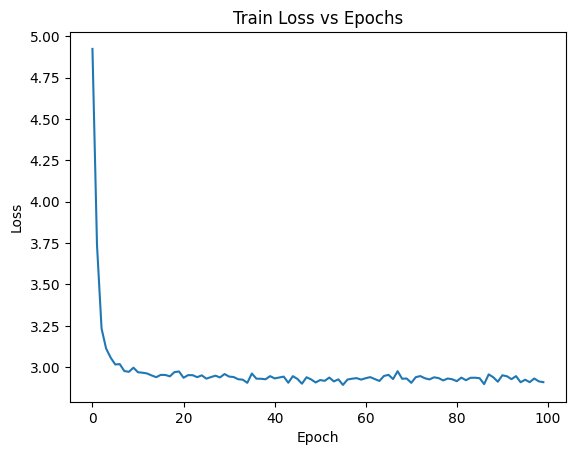

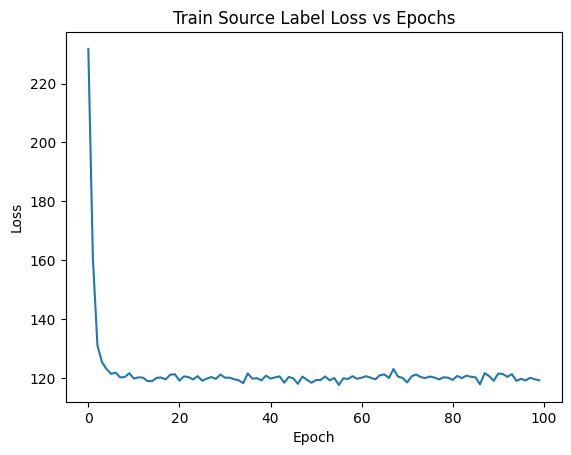

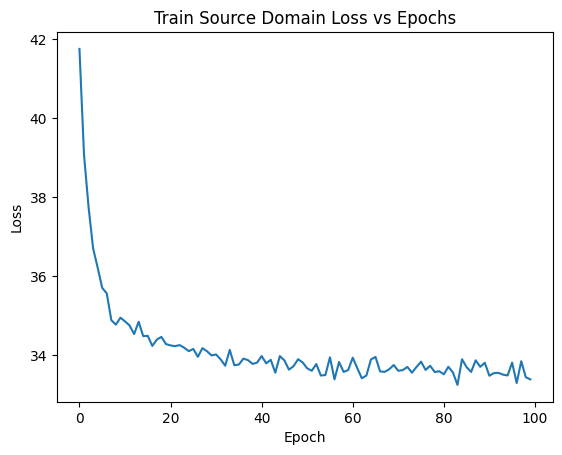

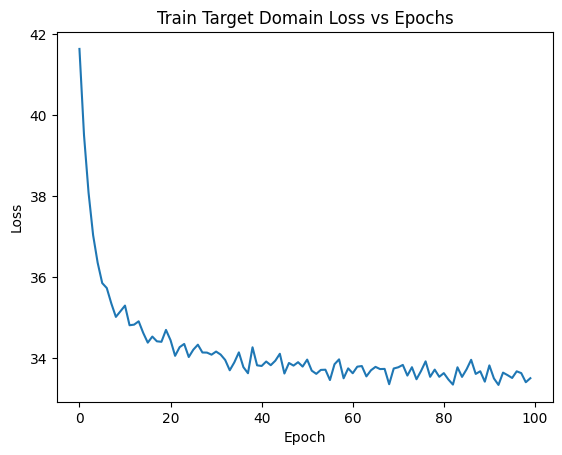

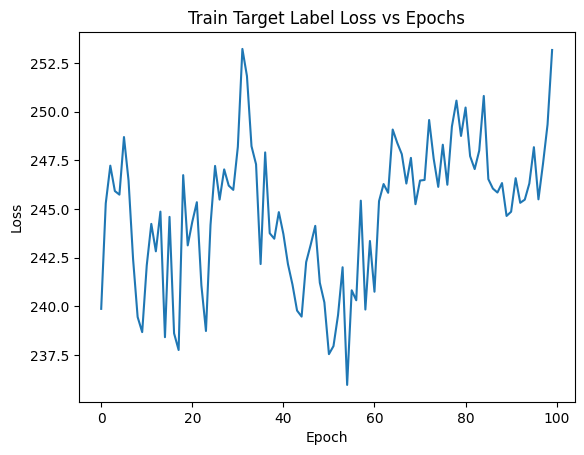

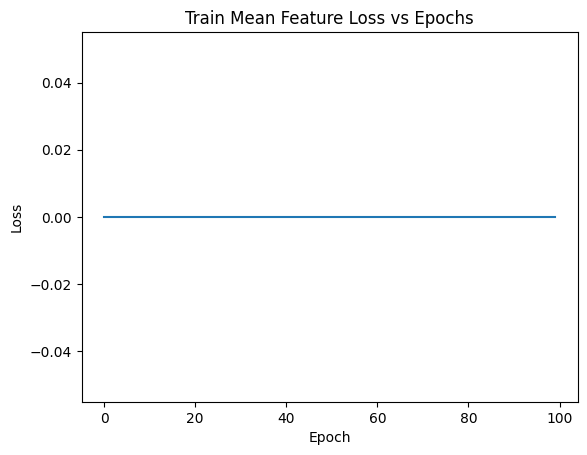

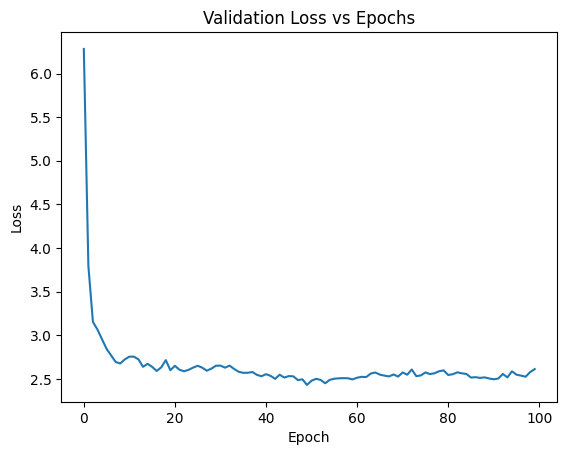

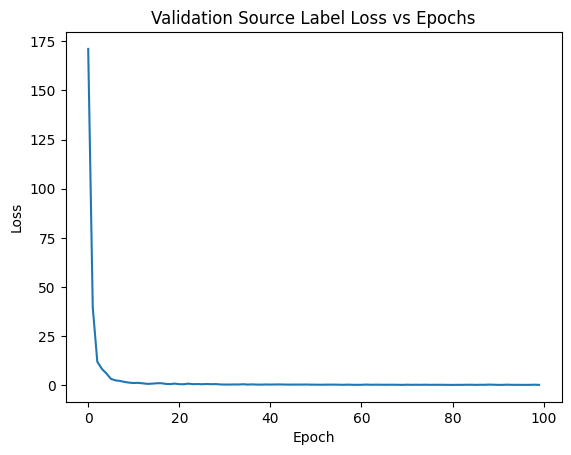

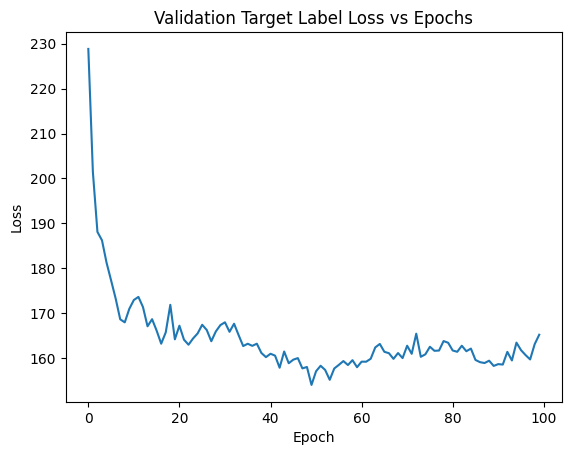

In [15]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_alpha_0_001.pt", 
                                  scheduler, semisupervised = False, grl = True, mean_loss = False, fixed_alpha = 0.001, fixed_lr = False)

In [16]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_alpha_0_001.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.65      0.67      0.66        33
           1       0.31      0.97      0.46        90
           2       0.21      0.51      0.30       123
           3       0.16      0.44      0.23        68
           4       0.21      0.87      0.34        70
           5       0.02      1.00      0.04         5
           6       0.25      0.52      0.34        25
           7       0.16      0.24      0.19       125
           8       0.03      0.07      0.05        96
           9       0.44      0.47      0.45       173
          10       0.33      0.84      0.47       108
          11       0.31      0.84      0.45        68
          12       0.68      0.78      0.72       249
          13       0.57      0.75      0.65       230
          14       0.99      0.65      0.79       175
          15       0.39      0.40      0.40        83
          16       0.79      0.19      0.30       245
        

### Fixed LR

Train Loss: 4.62874698638916: 100%|█████████████████████████████████████████████████████| 333/333 [00:16<00:00, 19.91it/s]

Saving at epoch 0


Train Loss: 4.316947937011719: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.12it/s]


Epoch 0: Train Loss = 4.944473, Val Loss = 6.218253


Train Loss: 3.3273813724517822: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 23.67it/s]

Saving at epoch 1


Train Loss: 2.735823154449463: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.81it/s]


Epoch 1: Train Loss = 3.746298, Val Loss = 3.430514


Train Loss: 3.414501667022705: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 16.25it/s]

Saving at epoch 2


Train Loss: 2.8789796829223633: 100%|███████████████████████████████████████████████████| 333/333 [00:22<00:00, 14.94it/s]


Epoch 2: Train Loss = 3.220705, Val Loss = 2.951760


Train Loss: 3.065438985824585: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.86it/s]


Epoch 3: Train Loss = 3.115353, Val Loss = 2.958864


Train Loss: 3.11295747756958:  99%|████████████████████████████████████████████████████▋| 331/333 [00:19<00:00, 21.93it/s]

Saving at epoch 4


Train Loss: 2.909188985824585: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 14.08it/s]


Epoch 4: Train Loss = 3.088920, Val Loss = 2.617449


Train Loss: 3.2786595821380615: 100%|███████████████████████████████████████████████████| 333/333 [00:26<00:00, 12.73it/s]


Epoch 5: Train Loss = 3.084985, Val Loss = 2.651746


Train Loss: 2.808709144592285: 100%|███████████████████████████████████████████████████▊| 332/333 [00:20<00:00, 17.04it/s]

Saving at epoch 6


Train Loss: 2.782278060913086: 100%|████████████████████████████████████████████████████| 333/333 [00:25<00:00, 12.98it/s]


Epoch 6: Train Loss = 3.065282, Val Loss = 2.545926


Train Loss: 3.03291916847229: 100%|█████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.77it/s]


Epoch 7: Train Loss = 3.069018, Val Loss = 2.626746


Train Loss: 3.1973586082458496: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 23.66it/s]

Saving at epoch 8


Train Loss: 3.2693891525268555: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.19it/s]


Epoch 8: Train Loss = 3.077131, Val Loss = 2.516855


Train Loss: 3.233919858932495: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 23.63it/s]

Saving at epoch 9


Train Loss: 3.083402156829834: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 16.66it/s]


Epoch 9: Train Loss = 3.070882, Val Loss = 2.202574


Train Loss: 2.710805654525757: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 23.35it/s]

Saving at epoch 10


Train Loss: 3.196153163909912: 100%|████████████████████████████████████████████████████| 333/333 [00:23<00:00, 13.97it/s]


Epoch 10: Train Loss = 3.070294, Val Loss = 2.118792


Train Loss: 3.153388738632202: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.71it/s]


Epoch 11: Train Loss = 3.094605, Val Loss = 2.675823


Train Loss: 2.8377785682678223: 100%|███████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.26it/s]


Epoch 12: Train Loss = 3.094370, Val Loss = 2.343914


Train Loss: 3.501110076904297: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 19.89it/s]


Epoch 13: Train Loss = 3.070977, Val Loss = 2.474184


Train Loss: 3.206181049346924: 100%|████████████████████████████████████████████████████| 333/333 [00:22<00:00, 15.07it/s]


Epoch 14: Train Loss = 3.120384, Val Loss = 2.198137


Train Loss: 3.163665294647217: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.83it/s]


Epoch 15: Train Loss = 3.131022, Val Loss = 2.208880


Train Loss: 2.9698891639709473:  99%|██████████████████████████████████████████████████▌| 330/333 [00:16<00:00, 23.74it/s]

Saving at epoch 16


Train Loss: 2.943814754486084: 100%|████████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.48it/s]


Epoch 16: Train Loss = 3.108656, Val Loss = 1.915553


Train Loss: 3.337693691253662: 100%|████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.80it/s]


Epoch 17: Train Loss = 3.143763, Val Loss = 2.411622


Train Loss: 3.0679678916931152: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.60it/s]


Epoch 18: Train Loss = 3.153125, Val Loss = 2.179533


Train Loss: 3.250351667404175: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.01it/s]


Epoch 19: Train Loss = 3.145452, Val Loss = 2.055761


Train Loss: 3.2228572368621826: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.12it/s]


Epoch 20: Train Loss = 3.151217, Val Loss = 2.199890


Train Loss: 3.4419145584106445: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.17it/s]


Epoch 21: Train Loss = 3.150459, Val Loss = 2.036164


Train Loss: 3.5899269580841064: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.51it/s]


Epoch 22: Train Loss = 3.175176, Val Loss = 2.066546


Train Loss: 3.477719306945801: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.88it/s]


Epoch 23: Train Loss = 3.185251, Val Loss = 2.202292


Train Loss: 3.402139663696289: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 25.72it/s]


Epoch 24: Train Loss = 3.197146, Val Loss = 1.972169


Train Loss: 2.9823110103607178: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.24it/s]


Epoch 25: Train Loss = 3.136784, Val Loss = 2.123002


Train Loss: 2.9613442420959473: 100%|███████████████████████████████████████████████████| 333/333 [00:09<00:00, 36.95it/s]

Saving at epoch 26


Train Loss: 3.0296642780303955: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.13it/s]


Epoch 26: Train Loss = 3.152647, Val Loss = 1.881699


Train Loss: 3.1638622283935547: 100%|██████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 39.90it/s]

Saving at epoch 27


Train Loss: 3.5741348266601562: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.46it/s]


Epoch 27: Train Loss = 3.171814, Val Loss = 1.791647


Train Loss: 2.9210147857666016: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.26it/s]


Epoch 28: Train Loss = 3.152191, Val Loss = 1.919712


Train Loss: 3.1035003662109375: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.80it/s]


Epoch 29: Train Loss = 3.171090, Val Loss = 2.113293


Train Loss: 3.1023340225219727: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.67it/s]


Epoch 30: Train Loss = 3.155738, Val Loss = 1.911450


Train Loss: 3.2525320053100586: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.05it/s]


Epoch 31: Train Loss = 3.167471, Val Loss = 2.015569


Train Loss: 3.0793380737304688:  99%|██████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 37.24it/s]

Saving at epoch 32


Train Loss: 3.1070680618286133: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.25it/s]


Epoch 32: Train Loss = 3.191671, Val Loss = 1.778036


Train Loss: 3.2884082794189453: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.76it/s]


Epoch 33: Train Loss = 3.193043, Val Loss = 1.962336


Train Loss: 3.1044111251831055: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.40it/s]


Epoch 34: Train Loss = 3.173919, Val Loss = 1.877952


Train Loss: 3.501777410507202: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.56it/s]


Epoch 35: Train Loss = 3.184312, Val Loss = 1.892227


Train Loss: 3.4270780086517334: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.63it/s]


Epoch 36: Train Loss = 3.218024, Val Loss = 1.961513


Train Loss: 2.897975206375122: 100%|████████████████████████████████████████████████████| 333/333 [00:09<00:00, 37.27it/s]

Saving at epoch 37


Train Loss: 3.189244031906128: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.01it/s]


Epoch 37: Train Loss = 3.193815, Val Loss = 1.740419


Train Loss: 3.303144931793213: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.38it/s]


Epoch 38: Train Loss = 3.172706, Val Loss = 1.883836


Train Loss: 3.3483500480651855: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.92it/s]


Epoch 39: Train Loss = 3.178063, Val Loss = 2.026020


Train Loss: 2.958322525024414: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.11it/s]


Epoch 40: Train Loss = 3.207526, Val Loss = 1.863186


Train Loss: 3.088235378265381: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.88it/s]


Epoch 41: Train Loss = 3.236511, Val Loss = 2.021650


Train Loss: 3.4535250663757324:  99%|██████████████████████████████████████████████████▍| 329/333 [00:09<00:00, 40.79it/s]

Saving at epoch 42


Train Loss: 3.9077796936035156: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.53it/s]


Epoch 42: Train Loss = 3.176807, Val Loss = 1.730313


Train Loss: 2.904222249984741: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.72it/s]


Epoch 43: Train Loss = 3.227893, Val Loss = 1.971205


Train Loss: 3.381019115447998: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.95it/s]


Epoch 44: Train Loss = 3.189584, Val Loss = 1.968596


Train Loss: 3.041234254837036: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.10it/s]


Epoch 45: Train Loss = 3.221051, Val Loss = 2.143073


Train Loss: 3.3302316665649414: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.66it/s]


Epoch 46: Train Loss = 3.229661, Val Loss = 1.932588


Train Loss: 3.5234222412109375: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.96it/s]


Epoch 47: Train Loss = 3.221999, Val Loss = 1.993826


Train Loss: 2.792586326599121: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.12it/s]


Epoch 48: Train Loss = 3.208862, Val Loss = 1.942189


Train Loss: 3.000976085662842: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.88it/s]


Epoch 49: Train Loss = 3.222771, Val Loss = 2.191058


Train Loss: 3.4269704818725586: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.09it/s]


Epoch 50: Train Loss = 3.211911, Val Loss = 2.119723


Train Loss: 3.2908756732940674: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.01it/s]


Epoch 51: Train Loss = 3.243592, Val Loss = 2.131335


Train Loss: 3.3012795448303223: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.42it/s]


Epoch 52: Train Loss = 3.270220, Val Loss = 2.146806


Train Loss: 3.096182107925415: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.52it/s]


Epoch 53: Train Loss = 3.290091, Val Loss = 2.432702


Train Loss: 3.837167739868164: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.98it/s]


Epoch 54: Train Loss = 3.294170, Val Loss = 2.433792


Train Loss: 3.4999022483825684: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.15it/s]


Epoch 55: Train Loss = 3.274745, Val Loss = 1.955010


Train Loss: 3.33150053024292: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.15it/s]


Epoch 56: Train Loss = 3.312891, Val Loss = 2.395947


Train Loss: 4.1047210693359375: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.46it/s]


Epoch 57: Train Loss = 3.247933, Val Loss = 2.074616


Train Loss: 3.4215826988220215: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.64it/s]


Epoch 58: Train Loss = 3.291065, Val Loss = 2.283381


Train Loss: 2.9876842498779297: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.84it/s]


Epoch 59: Train Loss = 3.295087, Val Loss = 2.250304


Train Loss: 3.6205859184265137: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.59it/s]


Epoch 60: Train Loss = 3.305620, Val Loss = 2.360367


Train Loss: 3.2805047035217285: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.76it/s]


Epoch 61: Train Loss = 3.281660, Val Loss = 2.236085


Train Loss: 3.46859073638916: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.89it/s]


Epoch 62: Train Loss = 3.385125, Val Loss = 2.735949


Train Loss: 3.307785749435425: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.79it/s]


Epoch 63: Train Loss = 3.253637, Val Loss = 2.250069


Train Loss: 3.1055901050567627: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.50it/s]


Epoch 64: Train Loss = 3.320301, Val Loss = 2.240787


Train Loss: 3.793705463409424: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.32it/s]


Epoch 65: Train Loss = 3.366423, Val Loss = 2.552503


Train Loss: 3.399575710296631: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.48it/s]


Epoch 66: Train Loss = 3.419505, Val Loss = 2.594056


Train Loss: 3.347043514251709: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.52it/s]


Epoch 67: Train Loss = 3.416102, Val Loss = 2.797977


Train Loss: 3.376136064529419: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.86it/s]


Epoch 68: Train Loss = 3.498551, Val Loss = 2.559222


Train Loss: 3.5624208450317383: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.34it/s]


Epoch 69: Train Loss = 3.447230, Val Loss = 2.538295


Train Loss: 3.1239497661590576: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.73it/s]


Epoch 70: Train Loss = 3.518014, Val Loss = 2.617180


Train Loss: 3.4280457496643066: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.76it/s]


Epoch 71: Train Loss = 3.506620, Val Loss = 2.633933


Train Loss: 3.647902488708496: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.62it/s]


Epoch 72: Train Loss = 3.416476, Val Loss = 2.787089


Train Loss: 3.287109375: 100%|██████████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.45it/s]


Epoch 73: Train Loss = 3.421410, Val Loss = 2.781820


Train Loss: 3.232288360595703: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.02it/s]


Epoch 74: Train Loss = 3.436063, Val Loss = 2.679228


Train Loss: 3.434091329574585: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.67it/s]


Epoch 75: Train Loss = 3.560940, Val Loss = 3.360692


Train Loss: 3.2856552600860596: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.65it/s]


Epoch 76: Train Loss = 3.679380, Val Loss = 3.059221


Train Loss: 3.1208763122558594: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.47it/s]


Epoch 77: Train Loss = 3.454156, Val Loss = 2.562410


Train Loss: 3.9197874069213867: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.07it/s]


Epoch 78: Train Loss = 3.590053, Val Loss = 2.831174


Train Loss: 2.947486400604248: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.82it/s]


Epoch 79: Train Loss = 3.581536, Val Loss = 2.848444


Train Loss: 3.91467547416687: 100%|█████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.74it/s]


Epoch 80: Train Loss = 3.502362, Val Loss = 3.057752


Train Loss: 4.047860145568848: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.74it/s]


Epoch 81: Train Loss = 3.479284, Val Loss = 2.974449


Train Loss: 3.104902744293213: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.22it/s]


Epoch 82: Train Loss = 3.495558, Val Loss = 2.932323


Train Loss: 3.5958383083343506: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.61it/s]


Epoch 83: Train Loss = 3.459736, Val Loss = 2.881092


Train Loss: 3.883519172668457: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.92it/s]


Epoch 84: Train Loss = 3.663348, Val Loss = 3.035923


Train Loss: 4.5701727867126465: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.04it/s]


Epoch 85: Train Loss = 3.592200, Val Loss = 3.035158


Train Loss: 3.5227510929107666: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.76it/s]


Epoch 86: Train Loss = 3.674628, Val Loss = 3.221793


Train Loss: 3.6796088218688965: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.92it/s]


Epoch 87: Train Loss = 3.733197, Val Loss = 3.073487


Train Loss: 3.2012574672698975: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.52it/s]


Epoch 88: Train Loss = 3.797420, Val Loss = 2.890147


Train Loss: 3.6614160537719727: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.44it/s]


Epoch 89: Train Loss = 3.623708, Val Loss = 3.272602


Train Loss: 3.4372005462646484: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.72it/s]


Epoch 90: Train Loss = 3.782482, Val Loss = 2.995448


Train Loss: 3.754885673522949: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.92it/s]


Epoch 91: Train Loss = 3.806379, Val Loss = 2.850087


Train Loss: 4.992060661315918: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.80it/s]


Epoch 92: Train Loss = 3.876837, Val Loss = 3.182426


Train Loss: 3.5361008644104004: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.23it/s]


Epoch 93: Train Loss = 3.819226, Val Loss = 3.051116


Train Loss: 3.331179618835449: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.72it/s]


Epoch 94: Train Loss = 3.568148, Val Loss = 3.035078


Train Loss: 4.107168674468994: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.83it/s]


Epoch 95: Train Loss = 3.731115, Val Loss = 2.986734


Train Loss: 3.7042236328125: 100%|██████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.08it/s]


Epoch 96: Train Loss = 4.153347, Val Loss = 3.410835


Train Loss: 3.80008602142334: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.72it/s]


Epoch 97: Train Loss = 4.036587, Val Loss = 3.182237


Train Loss: 4.57968282699585: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.02it/s]


Epoch 98: Train Loss = 3.927941, Val Loss = 3.373049


Train Loss: 3.8557450771331787: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.98it/s]

Epoch 99: Train Loss = 3.795710, Val Loss = 3.249061


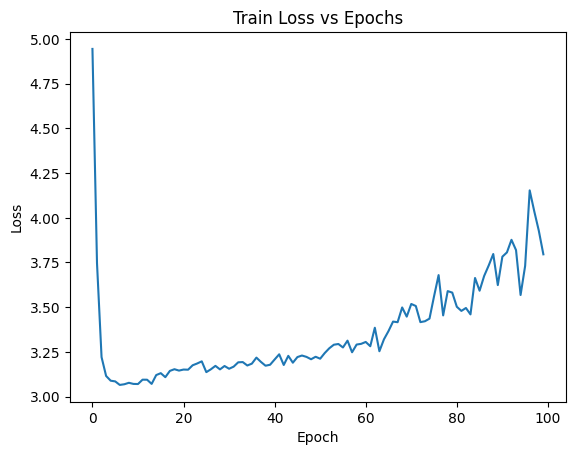

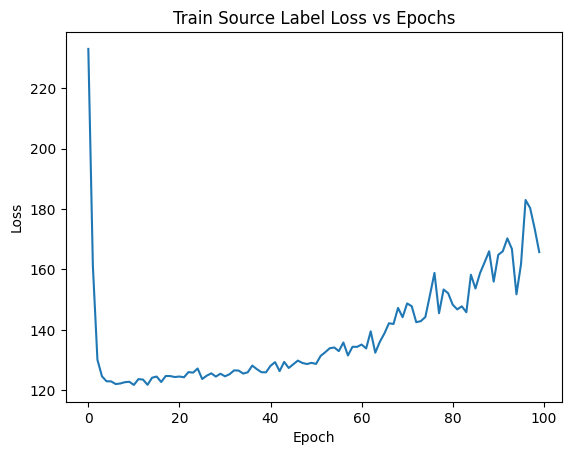

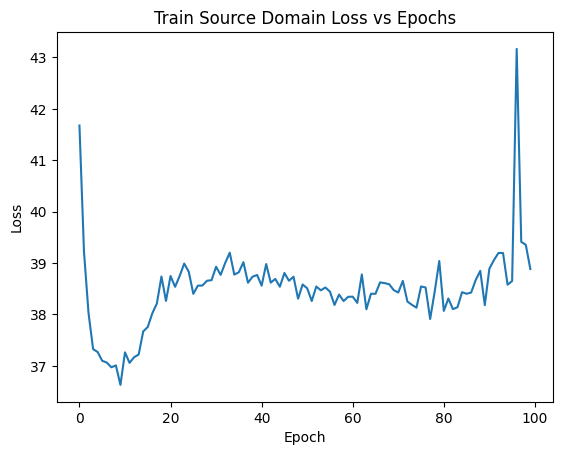

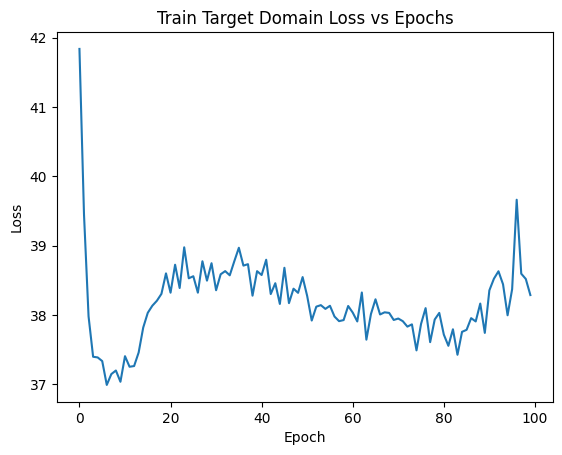

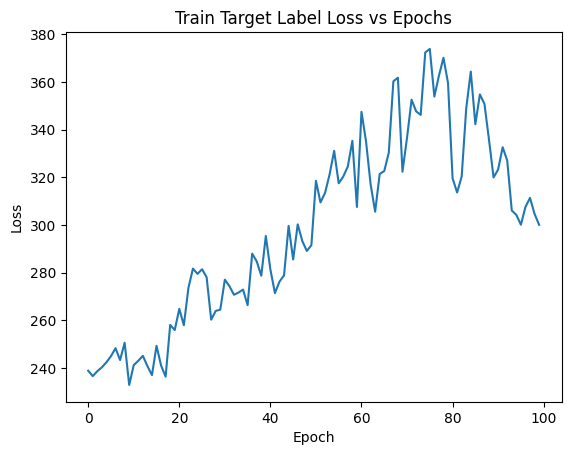

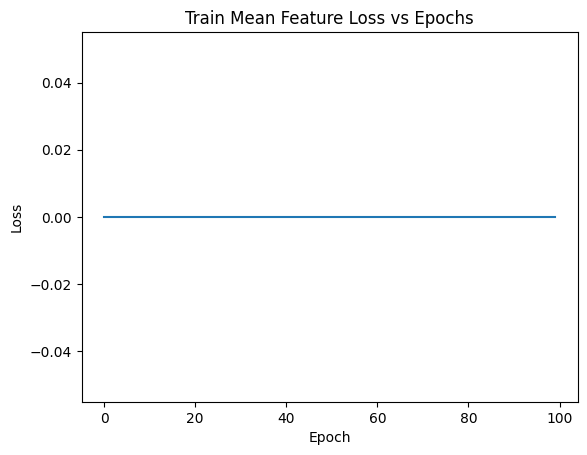

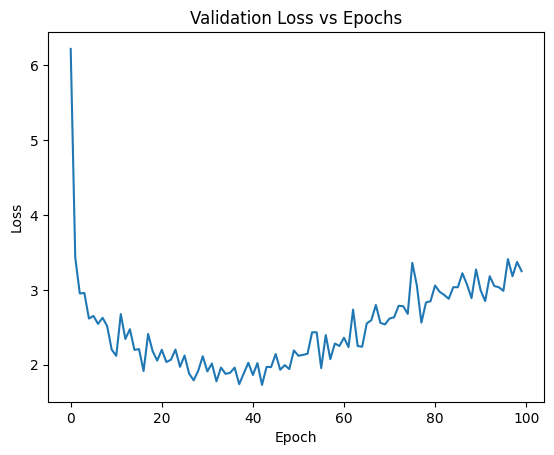

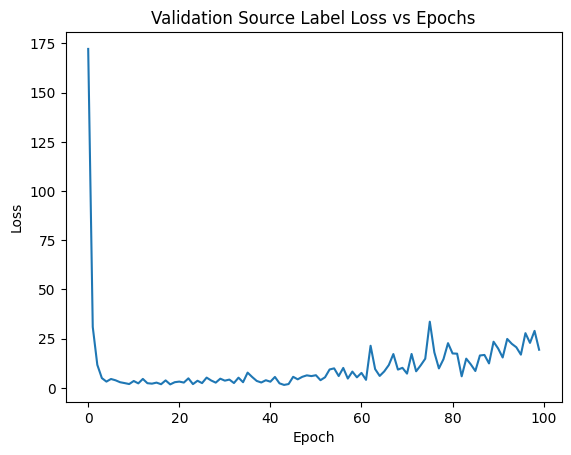

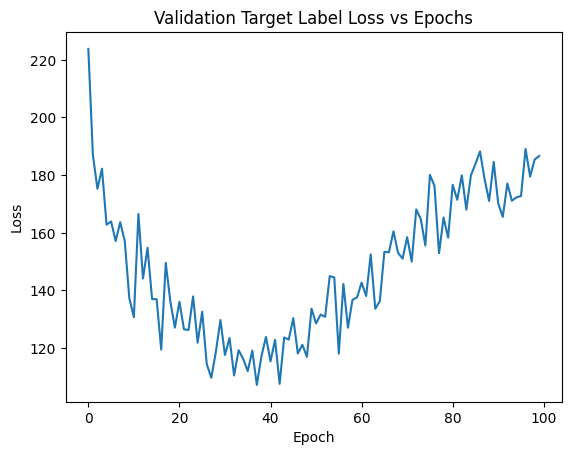

In [17]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_fixed_lr.pt", 
                                  scheduler, semisupervised = False, grl = True, mean_loss = False, fixed_alpha = None, fixed_lr = True)

In [18]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_fixed_lr.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.74      0.66      0.69        38
           1       0.39      1.00      0.56       110
           2       0.37      0.77      0.50       146
           3       0.47      0.85      0.60       103
           4       0.30      0.94      0.45        90
           5       0.24      0.97      0.39        61
           6       0.31      0.42      0.36        38
           7       0.43      0.50      0.46       165
           8       0.09      0.69      0.16        26
           9       0.79      0.62      0.70       239
          10       0.84      0.79      0.81       295
          11       0.79      0.75      0.77       193
          12       0.84      0.97      0.90       247
          13       0.71      0.92      0.80       237
          14       0.97      0.34      0.50       331
          15       0.85      0.37      0.52       190
          16       0.84      0.14      0.24       350
        

### Exponential Scheduler on LR

In [ ]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
# scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_exp_lr.pt", 
                                  scheduler, semisupervised = False, grl = True, mean_loss = False, fixed_alpha = None, fixed_lr = True)

Train Loss: 4.606987953186035: 100%|███████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 34.66it/s]

Saving at epoch 0


Train Loss: 4.5421576499938965: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.82it/s]


Epoch 0: Train Loss = 4.967925, Val Loss = 6.543241


Train Loss: 4.405620098114014:   7%|███▊                                                 | 24/333 [00:01<00:11, 27.64it/s]

In [ ]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_exp_lr.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

### Semisupervised without GRL

Train Loss: 7.468463897705078:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  7.91it/s]

Saving at epoch 0


Train Loss: 7.463040351867676: 100%|██████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.05it/s]


Epoch 0: Train Loss = 7.520631, Val Loss = 7.490580


Train Loss: 7.418889045715332:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.57it/s]

Saving at epoch 1


Train Loss: 7.403604507446289: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 1: Train Loss = 7.473093, Val Loss = 7.450550


Train Loss: 7.445169448852539:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.40it/s]

Saving at epoch 2


Train Loss: 7.478114128112793: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch 2: Train Loss = 7.454019, Val Loss = 7.444440


Train Loss: 7.450894355773926:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 11.44it/s]

Saving at epoch 3


Train Loss: 7.426606178283691: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch 3: Train Loss = 7.441806, Val Loss = 7.433099


Train Loss: 7.433992862701416:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  7.57it/s]

Saving at epoch 4


Train Loss: 7.331042289733887: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch 4: Train Loss = 7.421691, Val Loss = 7.414305


Train Loss: 7.4582366943359375:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.07it/s]

Saving at epoch 5


Train Loss: 7.425961494445801: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


Epoch 5: Train Loss = 7.406853, Val Loss = 7.400949


Train Loss: 7.489160537719727:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.55it/s]

Saving at epoch 6


Train Loss: 7.307920455932617: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch 6: Train Loss = 7.388043, Val Loss = 7.373917


Train Loss: 7.309208869934082:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.65it/s]

Saving at epoch 7


Train Loss: 7.3582282066345215: 100%|█████████████████████████████████████████████████████| 20/20 [00:39<00:00,  1.99s/it]


Epoch 7: Train Loss = 7.358900, Val Loss = 7.344008


Train Loss: 7.399919509887695:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  7.88it/s]

Saving at epoch 8


Train Loss: 7.375381946563721: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 8: Train Loss = 7.357404, Val Loss = 7.336553


Train Loss: 7.349964618682861: 100%|██████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.52it/s]

Saving at epoch 9


Train Loss: 7.343341827392578: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Epoch 9: Train Loss = 7.319580, Val Loss = 7.249460


Train Loss: 7.156681537628174:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  7.62it/s]

Saving at epoch 10


Train Loss: 7.339122772216797: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch 10: Train Loss = 7.265727, Val Loss = 7.160984


Train Loss: 7.205826759338379:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.00it/s]

Saving at epoch 11


Train Loss: 7.122002601623535: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


Epoch 11: Train Loss = 7.172057, Val Loss = 6.998896


Train Loss: 7.055598258972168:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.19it/s]

Saving at epoch 12


Train Loss: 7.25611686706543: 100%|███████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


Epoch 12: Train Loss = 7.059458, Val Loss = 6.743127


Train Loss: 6.926366806030273:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.61it/s]

Saving at epoch 13


Train Loss: 6.694642066955566: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch 13: Train Loss = 6.968792, Val Loss = 6.505684


Train Loss: 6.783026695251465:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  7.00it/s]

Saving at epoch 14


Train Loss: 6.955435752868652: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


Epoch 14: Train Loss = 6.840456, Val Loss = 6.344444


Train Loss: 6.563559055328369: 100%|██████████████████████████████████████████████████████| 20/20 [00:03<00:00,  7.06it/s]

Saving at epoch 15


Train Loss: 6.7539215087890625: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


Epoch 15: Train Loss = 6.704130, Val Loss = 6.021808


Train Loss: 6.377685546875:  95%|██████████████████████████████████████████████████████▏  | 19/20 [00:02<00:00,  9.20it/s]

Saving at epoch 16


Train Loss: 6.319478988647461: 100%|██████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 16: Train Loss = 6.534110, Val Loss = 5.701941


Train Loss: 6.121636390686035: 100%|██████████████████████████████████████████████████████| 20/20 [00:13<00:00, 12.24it/s]

Saving at epoch 17


Train Loss: 6.121636390686035: 100%|██████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch 17: Train Loss = 6.415816, Val Loss = 5.527115


Train Loss: 6.395683288574219:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  8.38it/s]

Saving at epoch 18


Train Loss: 6.050686836242676: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 18: Train Loss = 6.218369, Val Loss = 5.112485


Train Loss: 6.054542541503906:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.12it/s]

Saving at epoch 19


Train Loss: 5.987968444824219: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Epoch 19: Train Loss = 6.143399, Val Loss = 5.056530


Train Loss: 5.994052410125732:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  8.45it/s]

Saving at epoch 20


Train Loss: 6.145174026489258: 100%|██████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch 20: Train Loss = 6.036724, Val Loss = 4.773668


Train Loss: 5.599607467651367:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.69it/s]

Saving at epoch 21


Train Loss: 6.015674114227295: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


Epoch 21: Train Loss = 5.895471, Val Loss = 4.627660


Train Loss: 5.707414627075195:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.19it/s]

Saving at epoch 22


Train Loss: 5.257443904876709: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch 22: Train Loss = 5.709252, Val Loss = 4.378502


Train Loss: 5.450282573699951:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  7.98it/s]

Saving at epoch 23


Train Loss: 5.42508602142334: 100%|███████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.66it/s]


Epoch 23: Train Loss = 5.717289, Val Loss = 4.302753


Train Loss: 5.467398643493652:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.52it/s]

Saving at epoch 24


Train Loss: 5.649975776672363: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


Epoch 24: Train Loss = 5.611700, Val Loss = 3.945991


Train Loss: 5.7376508712768555:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.18it/s]

Saving at epoch 25


Train Loss: 5.148961067199707: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


Epoch 25: Train Loss = 5.463535, Val Loss = 3.931670


Train Loss: 4.723004341125488:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.05it/s]

Saving at epoch 26


Train Loss: 5.5452880859375: 100%|████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.32it/s]


Epoch 26: Train Loss = 5.274142, Val Loss = 3.590139


Train Loss: 5.037458419799805: 100%|██████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.24it/s]

Saving at epoch 27


Train Loss: 5.296076774597168: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


Epoch 27: Train Loss = 5.324182, Val Loss = 3.557064


Train Loss: 5.2129597663879395:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.84it/s]

Saving at epoch 28


Train Loss: 5.219908714294434: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


Epoch 28: Train Loss = 5.217404, Val Loss = 3.304336


Train Loss: 4.893729209899902:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.16it/s]

Saving at epoch 29


Train Loss: 5.3235063552856445: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


Epoch 29: Train Loss = 5.067022, Val Loss = 3.048875


Train Loss: 5.140027046203613:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 11.46it/s]

Saving at epoch 30


Train Loss: 5.143402099609375: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.75it/s]


Epoch 30: Train Loss = 4.982166, Val Loss = 3.001134


Train Loss: 4.932412147521973: 100%|██████████████████████████████████████████████████████| 20/20 [00:02<00:00, 10.04it/s]

Saving at epoch 31


Train Loss: 5.3667097091674805: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch 31: Train Loss = 4.944270, Val Loss = 2.925453


Train Loss: 4.799321174621582:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:01<00:00, 10.35it/s]

Saving at epoch 32


Train Loss: 5.433732986450195: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch 32: Train Loss = 4.825748, Val Loss = 2.598468


Train Loss: 4.785799980163574:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.94it/s]

Saving at epoch 33


Train Loss: 4.7701215744018555: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch 33: Train Loss = 4.770518, Val Loss = 2.544539


Train Loss: 3.9580044746398926:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 11.11it/s]

Saving at epoch 34


Train Loss: 4.861185073852539: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]


Epoch 34: Train Loss = 4.626373, Val Loss = 2.440590


Train Loss: 4.665735244750977:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.01it/s]

Saving at epoch 35


Train Loss: 4.528258323669434: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


Epoch 35: Train Loss = 4.851875, Val Loss = 2.383920


Train Loss: 4.672149658203125: 100%|██████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.50it/s]

Saving at epoch 36


Train Loss: 4.843992233276367: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Epoch 36: Train Loss = 4.732180, Val Loss = 2.259775


Train Loss: 5.1676435470581055:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:01<00:00, 11.13it/s]

Saving at epoch 37


Train Loss: 4.7430267333984375: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch 37: Train Loss = 4.627792, Val Loss = 2.086630


Train Loss: 4.1711273193359375: 100%|█████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch 38: Train Loss = 4.563185, Val Loss = 2.128328


Train Loss: 4.868188858032227:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.54it/s]

Saving at epoch 39


Train Loss: 4.763993263244629: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.70it/s]


Epoch 39: Train Loss = 4.573487, Val Loss = 2.006892


Train Loss: 4.615180969238281: 100%|██████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.05s/it]


Epoch 40: Train Loss = 4.637351, Val Loss = 2.017837


Train Loss: 4.94741153717041:  95%|████████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 12.27it/s]

Saving at epoch 41


Train Loss: 4.452930927276611: 100%|██████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch 41: Train Loss = 4.528427, Val Loss = 1.806050


Train Loss: 4.625242233276367:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  7.61it/s]

Saving at epoch 42


Train Loss: 4.258083820343018: 100%|██████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 42: Train Loss = 4.424446, Val Loss = 1.793828


Train Loss: 4.784912109375:  95%|██████████████████████████████████████████████████████▏  | 19/20 [00:03<00:00,  7.51it/s]

Saving at epoch 43


Train Loss: 4.592354774475098: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


Epoch 43: Train Loss = 4.473988, Val Loss = 1.714367


Train Loss: 4.611284255981445:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.23it/s]

Saving at epoch 44


Train Loss: 4.349604606628418: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch 44: Train Loss = 4.446388, Val Loss = 1.672090


Train Loss: 4.816514015197754: 100%|██████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.25it/s]

Saving at epoch 45


Train Loss: 4.942895412445068: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.60it/s]


Epoch 45: Train Loss = 4.490643, Val Loss = 1.650362


Train Loss: 4.379979133605957:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.01it/s]

Saving at epoch 46


Train Loss: 4.2346320152282715: 100%|█████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch 46: Train Loss = 4.271451, Val Loss = 1.560418


Train Loss: 4.911052703857422:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  6.50it/s]

Saving at epoch 47


Train Loss: 4.154284477233887: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


Epoch 47: Train Loss = 4.391359, Val Loss = 1.501580


Train Loss: 4.357828140258789:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  7.38it/s]

Saving at epoch 48


Train Loss: 3.544832229614258: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.60it/s]


Epoch 48: Train Loss = 4.258243, Val Loss = 1.482068


Train Loss: 4.413180351257324:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  6.73it/s]

Saving at epoch 49


Train Loss: 3.8592612743377686: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


Epoch 49: Train Loss = 4.248095, Val Loss = 1.452507


Train Loss: 4.128382205963135: 100%|██████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.11it/s]

Saving at epoch 50


Train Loss: 3.7236623764038086: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


Epoch 50: Train Loss = 4.215819, Val Loss = 1.388259


Train Loss: 4.170398235321045: 100%|██████████████████████████████████████████████████████| 20/20 [00:03<00:00,  7.48it/s]

Saving at epoch 51


Train Loss: 4.551990509033203: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


Epoch 51: Train Loss = 4.237570, Val Loss = 1.346116


Train Loss: 3.7236859798431396:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.51it/s]

Saving at epoch 52


Train Loss: 4.4888916015625: 100%|████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch 52: Train Loss = 4.206163, Val Loss = 1.286566


Train Loss: 4.22609806060791: 100%|███████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch 53: Train Loss = 4.248658, Val Loss = 1.315617


Train Loss: 4.053040027618408: 100%|██████████████████████████████████████████████████████| 20/20 [00:03<00:00,  9.68it/s]

Saving at epoch 54


Train Loss: 3.9192585945129395: 100%|█████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch 54: Train Loss = 4.128536, Val Loss = 1.257696


Train Loss: 4.4592180252075195:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  6.36it/s]

Saving at epoch 55


Train Loss: 4.399013996124268: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


Epoch 55: Train Loss = 4.191454, Val Loss = 1.255400


Train Loss: 4.51407527923584:  95%|████████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  7.87it/s]

Saving at epoch 56


Train Loss: 4.511417388916016: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Epoch 56: Train Loss = 4.265020, Val Loss = 1.192525


Train Loss: 4.2535719871521:  95%|█████████████████████████████████████████████████████▏  | 19/20 [00:03<00:00,  6.87it/s]

Saving at epoch 57


Train Loss: 3.9166979789733887: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


Epoch 57: Train Loss = 4.190833, Val Loss = 1.171776


Train Loss: 4.6536455154418945:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  8.07it/s]

Saving at epoch 58


Train Loss: 3.7798895835876465: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


Epoch 58: Train Loss = 4.230446, Val Loss = 1.147386


Train Loss: 4.231007099151611: 100%|██████████████████████████████████████████████████████| 20/20 [00:03<00:00,  7.15it/s]

Saving at epoch 59


Train Loss: 3.969466209411621: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.63it/s]


Epoch 59: Train Loss = 4.111715, Val Loss = 1.096055


Train Loss: 4.931924343109131: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.64it/s]


Epoch 60: Train Loss = 4.283458, Val Loss = 1.100191


Train Loss: 3.9994688034057617:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  7.05it/s]

Saving at epoch 61


Train Loss: 4.4785871505737305: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


Epoch 61: Train Loss = 4.042758, Val Loss = 1.092668


Train Loss: 3.771984338760376: 100%|██████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.34it/s]

Saving at epoch 62


Train Loss: 4.154895305633545: 100%|██████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


Epoch 62: Train Loss = 4.148575, Val Loss = 1.036388


Train Loss: 4.253730297088623:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  5.55it/s]

Saving at epoch 63


Train Loss: 3.6348085403442383: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.55it/s]


Epoch 63: Train Loss = 4.015246, Val Loss = 1.011284


Train Loss: 3.8351802825927734:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  8.51it/s]

Saving at epoch 64


Train Loss: 4.0416579246521: 100%|████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 64: Train Loss = 3.927075, Val Loss = 0.996316


Train Loss: 3.7407870292663574: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


Epoch 65: Train Loss = 4.168784, Val Loss = 1.008830


Train Loss: 4.113548278808594: 100%|██████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.96it/s]

Saving at epoch 66


Train Loss: 3.8841700553894043: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.67it/s]


Epoch 66: Train Loss = 4.033841, Val Loss = 0.955966


Train Loss: 3.789246082305908: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


Epoch 67: Train Loss = 4.102643, Val Loss = 0.958519


Train Loss: 4.277082443237305:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:04<00:00,  5.47it/s]

Saving at epoch 68


Train Loss: 3.4792566299438477: 100%|█████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]


Epoch 68: Train Loss = 4.058448, Val Loss = 0.948524


Train Loss: 3.8866961002349854:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:04<00:00,  5.25it/s]

Saving at epoch 69


Train Loss: 4.398691177368164: 100%|██████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.08it/s]


Epoch 69: Train Loss = 4.026771, Val Loss = 0.906265


Train Loss: 4.091876029968262: 100%|██████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.15it/s]


Epoch 70: Train Loss = 4.115416, Val Loss = 0.927260


Train Loss: 3.995055675506592: 100%|██████████████████████████████████████████████████████| 20/20 [00:04<00:00,  5.11it/s]

Saving at epoch 71


Train Loss: 3.9145119190216064: 100%|█████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch 71: Train Loss = 4.062338, Val Loss = 0.896075


Train Loss: 3.613156318664551:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:04<00:00,  5.86it/s]

Saving at epoch 72


Train Loss: 3.9320855140686035: 100%|█████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.50it/s]


Epoch 72: Train Loss = 4.062405, Val Loss = 0.867106


Train Loss: 3.6749866008758545:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  6.08it/s]

Saving at epoch 73


Train Loss: 4.467633247375488: 100%|██████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.53it/s]


Epoch 73: Train Loss = 3.974334, Val Loss = 0.843277


Train Loss: 4.059143543243408:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  6.63it/s]

Saving at epoch 74


Train Loss: 4.213871955871582: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]


Epoch 74: Train Loss = 4.055081, Val Loss = 0.821671


Train Loss: 4.0039381980896: 100%|████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 75: Train Loss = 4.002489, Val Loss = 0.831586


Train Loss: 4.065039157867432:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:04<00:00,  5.44it/s]

Saving at epoch 76


Train Loss: 4.045846939086914: 100%|██████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.51it/s]


Epoch 76: Train Loss = 3.951580, Val Loss = 0.808937


Train Loss: 3.8144936561584473: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


Epoch 77: Train Loss = 3.836373, Val Loss = 0.846117


Train Loss: 3.982590675354004: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.58it/s]


Epoch 78: Train Loss = 3.944650, Val Loss = 0.841389


Train Loss: 4.208837509155273:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  8.32it/s]

Saving at epoch 79


Train Loss: 4.132460594177246: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.61it/s]


Epoch 79: Train Loss = 3.935721, Val Loss = 0.797046


Train Loss: 3.5455074310302734: 100%|█████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.79it/s]

Saving at epoch 80


Train Loss: 3.19623064994812: 100%|███████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]


Epoch 80: Train Loss = 3.869413, Val Loss = 0.794878


Train Loss: 3.687185287475586:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  8.70it/s]

Saving at epoch 81


Train Loss: 4.417651653289795: 100%|██████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch 81: Train Loss = 4.000148, Val Loss = 0.773947


Train Loss: 3.308650016784668:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  6.43it/s]

Saving at epoch 82


Train Loss: 4.048572540283203: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


Epoch 82: Train Loss = 4.008472, Val Loss = 0.750148


Train Loss: 4.308394432067871:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 12.37it/s]

Saving at epoch 83


Train Loss: 3.849778175354004: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch 83: Train Loss = 4.026468, Val Loss = 0.737776


Train Loss: 3.5607731342315674: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch 84: Train Loss = 3.893113, Val Loss = 0.740458


Train Loss: 3.82220458984375: 100%|███████████████████████████████████████████████████████| 20/20 [00:03<00:00,  7.05it/s]

Saving at epoch 85


Train Loss: 3.684882164001465: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


Epoch 85: Train Loss = 3.966149, Val Loss = 0.736901


Train Loss: 4.105274200439453: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch 86: Train Loss = 4.035426, Val Loss = 0.763520


Train Loss: 3.8458163738250732:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00,  9.64it/s]

Saving at epoch 87


Train Loss: 3.6491918563842773: 100%|█████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch 87: Train Loss = 4.008365, Val Loss = 0.730073


Train Loss: 3.9366366863250732:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.08it/s]

Saving at epoch 88


Train Loss: 3.392345428466797: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.68it/s]


Epoch 88: Train Loss = 3.917334, Val Loss = 0.707446


Train Loss: 3.7865118980407715:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:03<00:00,  6.89it/s]

Saving at epoch 89


Train Loss: 3.0699234008789062: 100%|█████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.62it/s]


Epoch 89: Train Loss = 3.867121, Val Loss = 0.686244


Train Loss: 3.571195602416992: 100%|██████████████████████████████████████████████████████| 20/20 [00:03<00:00,  8.02it/s]

Saving at epoch 90


Train Loss: 4.06383752822876: 100%|███████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.64it/s]


Epoch 90: Train Loss = 3.858900, Val Loss = 0.683153


Train Loss: 3.94741153717041: 100%|███████████████████████████████████████████████████████| 20/20 [00:03<00:00,  7.40it/s]

Saving at epoch 91


Train Loss: 3.803493022918701: 100%|██████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.05it/s]


Epoch 91: Train Loss = 3.871437, Val Loss = 0.669043


Train Loss: 3.4792356491088867:  95%|██████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 11.00it/s]

Saving at epoch 92


Train Loss: 3.6670947074890137: 100%|█████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch 92: Train Loss = 3.824376, Val Loss = 0.659111


Train Loss: 3.4223275184631348: 100%|█████████████████████████████████████████████████████| 20/20 [00:03<00:00,  7.11it/s]

Saving at epoch 93


Train Loss: 4.004896640777588: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.54it/s]


Epoch 93: Train Loss = 3.930556, Val Loss = 0.638434


Train Loss: 3.872140407562256:  95%|███████████████████████████████████████████████████▎  | 19/20 [00:02<00:00, 10.04it/s]

Saving at epoch 94


Train Loss: 3.962496757507324: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Epoch 94: Train Loss = 3.892317, Val Loss = 0.626367


Train Loss: 3.791402578353882: 100%|██████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch 95: Train Loss = 3.869365, Val Loss = 0.633422


Train Loss: 4.116103172302246: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.71it/s]


Epoch 96: Train Loss = 3.823546, Val Loss = 0.636372


Train Loss: 3.880969285964966: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]


Epoch 97: Train Loss = 3.959186, Val Loss = 0.635575


Train Loss: 3.783104419708252: 100%|██████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.78it/s]


Epoch 98: Train Loss = 3.884640, Val Loss = 0.647624


Train Loss: 3.664177179336548: 100%|██████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.56it/s]

Epoch 99: Train Loss = 3.908144, Val Loss = 0.641027


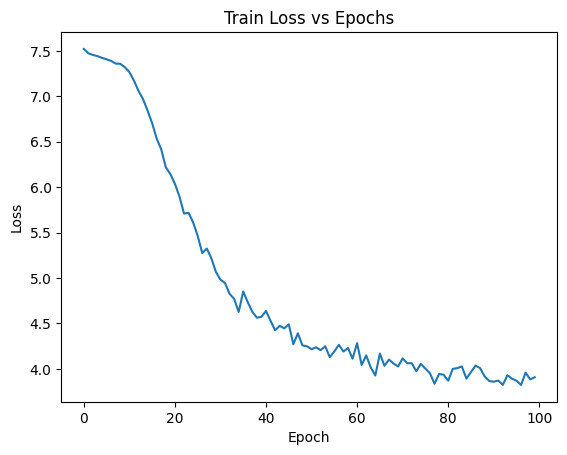

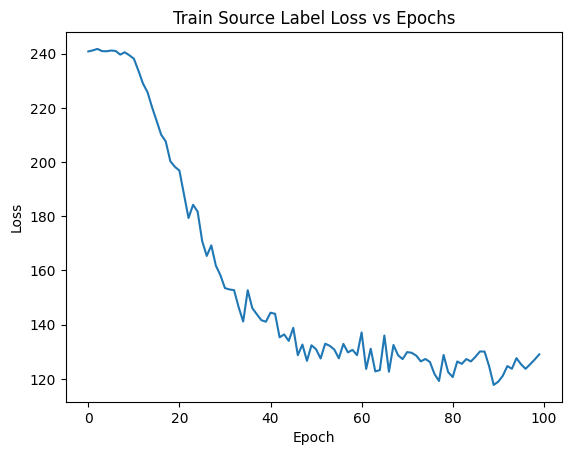

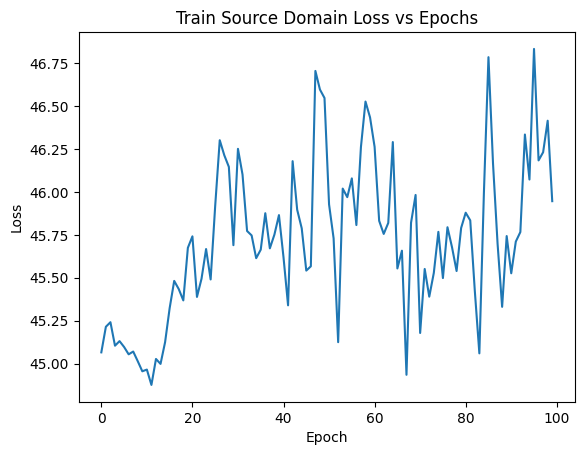

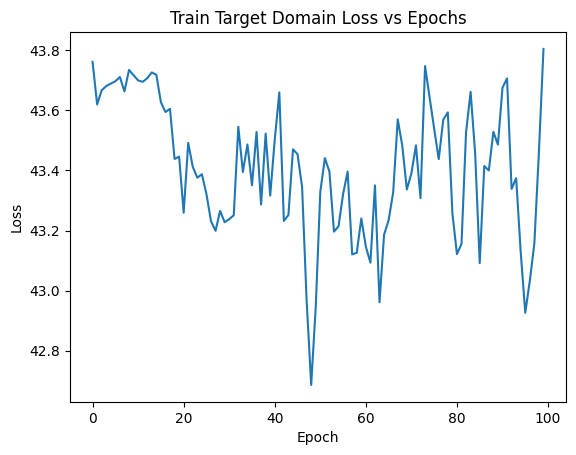

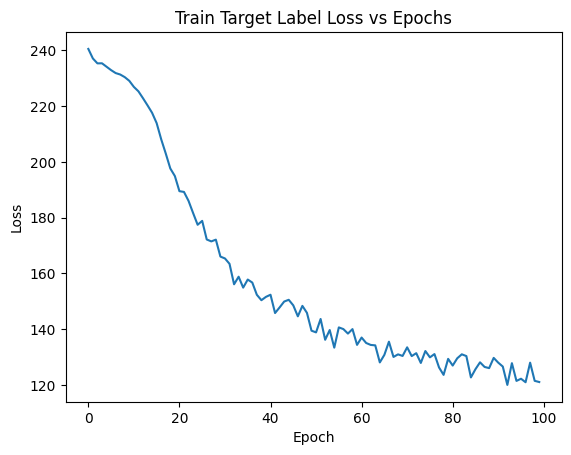

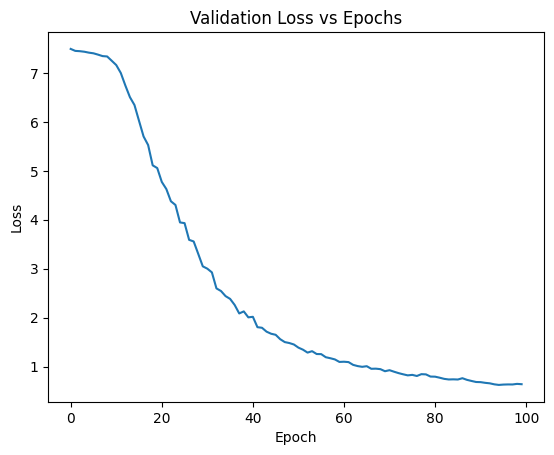

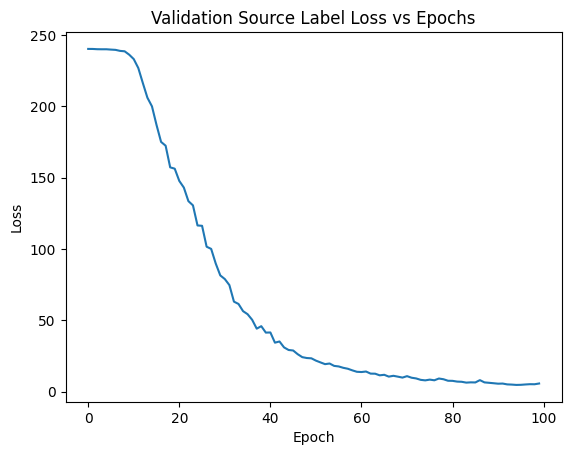

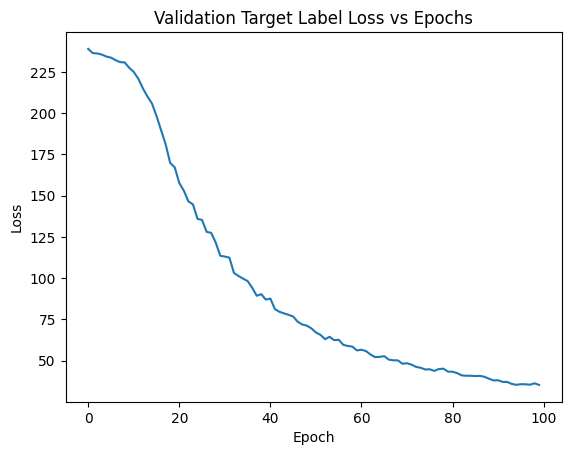

In [39]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None
s
train_report, test_report = train([source_trainloader, target_trainloader_semi], [source_valloader, target_valloader_semi], 
                                  target_testloader_semi, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_semisupervised_no_grl_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt", 
                                  scheduler, semisupervised = True, grl = False, mean_loss = False, fixed_alpha = None, fixed_lr = False)

In [40]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_semisupervised_no_grl_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        20
           1       0.74      0.91      0.82       237
           2       0.78      0.75      0.77       330
           3       0.69      0.77      0.73       177
           4       0.95      0.79      0.86       311
           5       0.66      0.71      0.68       210
           6       0.71      1.00      0.83        39
           7       0.68      0.76      0.72       165
           8       0.89      0.72      0.80       232
           9       0.94      0.92      0.93       217
          10       0.98      0.93      0.95       271
          11       0.94      0.96      0.95       155
          12       0.99      0.98      0.99       304
          13       0.98      0.98      0.98       313
          14       0.99      1.00      1.00       107
          15       0.95      0.83      0.88        92
          16       0.79      0.98      0.88        66
        

### Mean Loss with GRL

Train Loss: 4.881678104400635:  99%|███████████████████████████████████████████████████▌| 330/333 [00:11<00:00, 30.41it/s]

Saving at epoch 0


Train Loss: 4.929611682891846: 100%|████████████████████████████████████████████████████| 333/333 [00:15<00:00, 22.16it/s]


Epoch 0: Train Loss = 5.058436, Val Loss = 7.234813


Train Loss: 4.1086649894714355:  99%|██████████████████████████████████████████████████▌| 330/333 [00:10<00:00, 33.67it/s]

Saving at epoch 1


Train Loss: 4.034423351287842: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.10it/s]


Epoch 1: Train Loss = 4.438364, Val Loss = 5.625111


Train Loss: 3.8384222984313965: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 31.48it/s]

Saving at epoch 2


Train Loss: 3.42014217376709: 100%|█████████████████████████████████████████████████████| 333/333 [00:14<00:00, 22.68it/s]


Epoch 2: Train Loss = 3.729293, Val Loss = 4.342077


Train Loss: 2.999499797821045: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 30.84it/s]

Saving at epoch 3


Train Loss: 3.9787683486938477: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 22.72it/s]


Epoch 3: Train Loss = 3.416398, Val Loss = 3.964268


Train Loss: 3.321503162384033: 100%|███████████████████████████████████████████████████▊| 332/333 [00:10<00:00, 34.21it/s]

Saving at epoch 4


Train Loss: 3.2451703548431396: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 23.85it/s]


Epoch 4: Train Loss = 3.326877, Val Loss = 3.691543


Train Loss: 3.647778272628784:  99%|███████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 37.09it/s]

Saving at epoch 5


Train Loss: 3.1109442710876465: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.00it/s]


Epoch 5: Train Loss = 3.292820, Val Loss = 3.570505


Train Loss: 3.2173242568969727: 100%|███████████████████████████████████████████████████| 333/333 [00:09<00:00, 37.91it/s]

Saving at epoch 6


Train Loss: 2.9416987895965576: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.64it/s]


Epoch 6: Train Loss = 3.257723, Val Loss = 3.378023


Train Loss: 3.277873992919922: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.39it/s]


Epoch 7: Train Loss = 3.260322, Val Loss = 3.417563


Train Loss: 3.188265800476074: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.88it/s]


Epoch 8: Train Loss = 3.246261, Val Loss = 3.380673


Train Loss: 3.3793110847473145:  99%|██████████████████████████████████████████████████▍| 329/333 [00:08<00:00, 39.44it/s]

Saving at epoch 9


Train Loss: 3.097827911376953: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.80it/s]


Epoch 9: Train Loss = 3.229709, Val Loss = 3.317432


Train Loss: 3.1722755432128906: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.85it/s]


Epoch 10: Train Loss = 3.239090, Val Loss = 3.334738


Train Loss: 3.283632278442383:  99%|███████████████████████████████████████████████████▋| 331/333 [00:08<00:00, 40.31it/s]

Saving at epoch 11


Train Loss: 3.401853084564209: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.01it/s]


Epoch 11: Train Loss = 3.246022, Val Loss = 3.315595


Train Loss: 3.5225086212158203:  99%|██████████████████████████████████████████████████▋| 331/333 [00:08<00:00, 39.05it/s]

Saving at epoch 12


Train Loss: 3.254807233810425: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.73it/s]


Epoch 12: Train Loss = 3.254549, Val Loss = 3.231025


Train Loss: 3.181903600692749: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.92it/s]


Epoch 13: Train Loss = 3.259076, Val Loss = 3.331043


Train Loss: 3.298189640045166:  99%|███████████████████████████████████████████████████▌| 330/333 [00:09<00:00, 37.02it/s]

Saving at epoch 14


Train Loss: 3.293924331665039: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.18it/s]


Epoch 14: Train Loss = 3.256249, Val Loss = 3.185837


Train Loss: 3.1953299045562744: 100%|███████████████████████████████████████████████████| 333/333 [00:10<00:00, 30.38it/s]


Epoch 15: Train Loss = 3.279914, Val Loss = 3.187875


Train Loss: 3.278258800506592: 100%|███████████████████████████████████████████████████▊| 332/333 [00:08<00:00, 43.25it/s]

Saving at epoch 16


Train Loss: 3.0623106956481934: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.14it/s]


Epoch 16: Train Loss = 3.276551, Val Loss = 3.177320


Train Loss: 3.3212335109710693: 100%|██████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 40.84it/s]

Saving at epoch 17


Train Loss: 3.205258369445801: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.40it/s]


Epoch 17: Train Loss = 3.313000, Val Loss = 3.114826


Train Loss: 2.954124689102173: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.37it/s]


Epoch 18: Train Loss = 3.316272, Val Loss = 3.230332


Train Loss: 2.9207019805908203:  99%|██████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 40.54it/s]

Saving at epoch 19


Train Loss: 4.0322065353393555: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.90it/s]


Epoch 19: Train Loss = 3.305742, Val Loss = 3.103298


Train Loss: 3.028296709060669: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.54it/s]


Epoch 20: Train Loss = 3.336598, Val Loss = 3.133802


Train Loss: 3.5796492099761963:  99%|██████████████████████████████████████████████████▋| 331/333 [00:08<00:00, 43.70it/s]

Saving at epoch 21


Train Loss: 3.926337480545044: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.32it/s]


Epoch 21: Train Loss = 3.335634, Val Loss = 3.051384


Train Loss: 3.326810121536255:  99%|███████████████████████████████████████████████████▌| 330/333 [00:08<00:00, 41.87it/s]

Saving at epoch 22


Train Loss: 3.22238826751709: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.88it/s]


Epoch 22: Train Loss = 3.311811, Val Loss = 2.995334


Train Loss: 3.5293781757354736: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.23it/s]


Epoch 23: Train Loss = 3.336150, Val Loss = 3.080380


Train Loss: 3.3545584678649902:  99%|██████████████████████████████████████████████████▌| 330/333 [00:09<00:00, 36.84it/s]

Saving at epoch 24


Train Loss: 3.751490354537964: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.80it/s]


Epoch 24: Train Loss = 3.355667, Val Loss = 2.958780


Train Loss: 3.089001417160034: 100%|████████████████████████████████████████████████████| 333/333 [00:08<00:00, 38.18it/s]

Saving at epoch 25


Train Loss: 2.9879205226898193: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.61it/s]


Epoch 25: Train Loss = 3.356601, Val Loss = 2.938911


Train Loss: 3.5797297954559326:  99%|██████████████████████████████████████████████████▋| 331/333 [00:08<00:00, 41.02it/s]

Saving at epoch 26


Train Loss: 3.788466215133667: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.09it/s]


Epoch 26: Train Loss = 3.353591, Val Loss = 2.917056


Train Loss: 3.524915933609009:  99%|███████████████████████████████████████████████████▌| 330/333 [00:08<00:00, 39.12it/s]

Saving at epoch 27


Train Loss: 3.214712381362915: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.18it/s]


Epoch 27: Train Loss = 3.344707, Val Loss = 2.833176


Train Loss: 3.031662940979004: 100%|███████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 37.43it/s]

Saving at epoch 28


Train Loss: 3.898899793624878: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.03it/s]


Epoch 28: Train Loss = 3.353466, Val Loss = 2.816435


Train Loss: 2.9985930919647217: 100%|███████████████████████████████████████████████████| 333/333 [00:09<00:00, 37.97it/s]

Saving at epoch 29


Train Loss: 3.081397533416748: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.95it/s]


Epoch 29: Train Loss = 3.360485, Val Loss = 2.798814


Train Loss: 3.399975299835205: 100%|████████████████████████████████████████████████████| 333/333 [00:09<00:00, 39.53it/s]

Saving at epoch 30
Epoch 30: Train Loss = 3.366166, Val Loss = 2.699886


Train Loss: 3.214306354522705: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.75it/s]


Epoch 31: Train Loss = 3.344967, Val Loss = 2.781945


Train Loss: 3.786099910736084: 100%|████████████████████████████████████████████████████| 333/333 [00:10<00:00, 30.60it/s]


Epoch 32: Train Loss = 3.367801, Val Loss = 2.806610


Train Loss: 3.743645191192627: 100%|████████████████████████████████████████████████████| 333/333 [00:09<00:00, 34.31it/s]

Saving at epoch 33


Train Loss: 3.3240973949432373: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.67it/s]


Epoch 33: Train Loss = 3.369351, Val Loss = 2.679953


Train Loss: 3.3025619983673096: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.90it/s]


Epoch 34: Train Loss = 3.376598, Val Loss = 2.820461


Train Loss: 3.527379274368286:  99%|███████████████████████████████████████████████████▌| 330/333 [00:09<00:00, 37.34it/s]

Saving at epoch 35


Train Loss: 3.4338104724884033: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.68it/s]


Epoch 35: Train Loss = 3.364266, Val Loss = 2.657635


Train Loss: 3.0848476886749268:  99%|██████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 37.04it/s]

Saving at epoch 36


Train Loss: 3.0908217430114746: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.89it/s]


Epoch 36: Train Loss = 3.373381, Val Loss = 2.599823


Train Loss: 2.975661277770996:  99%|███████████████████████████████████████████████████▌| 330/333 [00:08<00:00, 43.27it/s]

Saving at epoch 37


Train Loss: 3.1685221195220947: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.93it/s]


Epoch 37: Train Loss = 3.348958, Val Loss = 2.526121


Train Loss: 3.130889415740967: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.33it/s]


Epoch 38: Train Loss = 3.368196, Val Loss = 2.700884


Train Loss: 3.463618755340576: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.28it/s]


Epoch 39: Train Loss = 3.368391, Val Loss = 2.574931


Train Loss: 3.198486804962158: 100%|███████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 38.51it/s]

Saving at epoch 40


Train Loss: 3.4166715145111084: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.96it/s]


Epoch 40: Train Loss = 3.348141, Val Loss = 2.450805


Train Loss: 3.4015843868255615:  99%|██████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 40.13it/s]

Saving at epoch 41


Train Loss: 3.470512628555298: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.19it/s]


Epoch 41: Train Loss = 3.360735, Val Loss = 2.352388


Train Loss: 3.5209689140319824: 100%|███████████████████████████████████████████████████| 333/333 [00:10<00:00, 30.84it/s]


Epoch 42: Train Loss = 3.373462, Val Loss = 2.483912


Train Loss: 3.4428927898406982: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.24it/s]


Epoch 43: Train Loss = 3.374634, Val Loss = 2.482022


Train Loss: 3.279106616973877:  99%|███████████████████████████████████████████████████▍| 329/333 [00:09<00:00, 39.73it/s]

Saving at epoch 44


Train Loss: 3.5518574714660645: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.46it/s]


Epoch 44: Train Loss = 3.367828, Val Loss = 2.343303


Train Loss: 2.9642510414123535: 100%|███████████████████████████████████████████████████| 333/333 [00:08<00:00, 36.32it/s]

Saving at epoch 45


Train Loss: 3.1527767181396484: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.30it/s]


Epoch 45: Train Loss = 3.378830, Val Loss = 2.340340


Train Loss: 3.369126319885254: 100%|███████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 38.48it/s]

Saving at epoch 46


Train Loss: 3.260565996170044: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.37it/s]


Epoch 46: Train Loss = 3.357062, Val Loss = 2.305698


Train Loss: 3.2213892936706543:  99%|██████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 40.91it/s]

Saving at epoch 47


Train Loss: 2.8395321369171143: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.36it/s]


Epoch 47: Train Loss = 3.353150, Val Loss = 2.280062


Train Loss: 3.6325390338897705: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.68it/s]


Epoch 48: Train Loss = 3.334207, Val Loss = 2.304525


Train Loss: 3.0774102210998535: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.73it/s]


Epoch 49: Train Loss = 3.380136, Val Loss = 2.293608


Train Loss: 3.834162950515747:  99%|███████████████████████████████████████████████████▌| 330/333 [00:09<00:00, 37.31it/s]

Saving at epoch 50


Train Loss: 3.2962169647216797: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.63it/s]


Epoch 50: Train Loss = 3.349877, Val Loss = 2.249094


Train Loss: 3.529613971710205:  99%|███████████████████████████████████████████████████▍| 329/333 [00:09<00:00, 40.59it/s]

Saving at epoch 51


Train Loss: 3.425246000289917: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.30it/s]


Epoch 51: Train Loss = 3.375182, Val Loss = 2.236860


Train Loss: 4.058812618255615: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 30.19it/s]


Epoch 52: Train Loss = 3.347551, Val Loss = 2.351093


Train Loss: 3.242558479309082:  99%|███████████████████████████████████████████████████▋| 331/333 [00:08<00:00, 38.68it/s]

Saving at epoch 53


Train Loss: 3.196918487548828: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.55it/s]


Epoch 53: Train Loss = 3.370400, Val Loss = 2.139455


Train Loss: 3.00622296333313: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.17it/s]


Epoch 54: Train Loss = 3.348734, Val Loss = 2.195908


Train Loss: 3.207441568374634:  99%|███████████████████████████████████████████████████▍| 329/333 [00:09<00:00, 38.00it/s]

Saving at epoch 55


Train Loss: 3.3110098838806152: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.85it/s]


Epoch 55: Train Loss = 3.369437, Val Loss = 2.126424


Train Loss: 3.7492034435272217: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.86it/s]


Epoch 56: Train Loss = 3.373273, Val Loss = 2.227887


Train Loss: 3.6817615032196045: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.32it/s]


Epoch 57: Train Loss = 3.347348, Val Loss = 2.192233


Train Loss: 3.241071939468384: 100%|████████████████████████████████████████████████████| 333/333 [06:57<00:00,  1.25s/it]


Epoch 58: Train Loss = 3.369593, Val Loss = 2.131468


Train Loss: 3.1678295135498047: 100%|███████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.12it/s]


Epoch 59: Train Loss = 3.356623, Val Loss = 2.146881


Train Loss: 3.6106996536254883: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 22.32it/s]


Epoch 60: Train Loss = 3.356857, Val Loss = 2.188205


Train Loss: 3.7677972316741943:  99%|██████████████████████████████████████████████████▋| 331/333 [00:11<00:00, 30.66it/s]

Saving at epoch 61


Train Loss: 3.4471874237060547: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 23.04it/s]


Epoch 61: Train Loss = 3.347723, Val Loss = 2.023280


Train Loss: 3.580679178237915: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.92it/s]


Epoch 62: Train Loss = 3.360503, Val Loss = 2.079025


Train Loss: 3.1586456298828125:  99%|██████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 38.18it/s]

Saving at epoch 63


Train Loss: 3.587409257888794: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.60it/s]


Epoch 63: Train Loss = 3.368013, Val Loss = 1.951429


Train Loss: 2.9760255813598633: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.03it/s]


Epoch 64: Train Loss = 3.339439, Val Loss = 2.153410


Train Loss: 3.2834460735321045: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.70it/s]


Epoch 65: Train Loss = 3.364637, Val Loss = 2.060160


Train Loss: 3.1431102752685547: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.87it/s]


Epoch 66: Train Loss = 3.363195, Val Loss = 2.050563


Train Loss: 3.3387420177459717: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.66it/s]


Epoch 67: Train Loss = 3.354133, Val Loss = 2.041725


Train Loss: 3.068667411804199: 100%|████████████████████████████████████████████████████| 333/333 [00:10<00:00, 31.08it/s]


Epoch 68: Train Loss = 3.349128, Val Loss = 2.029696


Train Loss: 3.584650993347168: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 30.10it/s]


Epoch 69: Train Loss = 3.344333, Val Loss = 2.031089


Train Loss: 3.308258295059204: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.97it/s]


Epoch 70: Train Loss = 3.360579, Val Loss = 2.006909


Train Loss: 3.50337553024292: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.80it/s]


Epoch 71: Train Loss = 3.383614, Val Loss = 2.070008


Train Loss: 3.266244888305664:  99%|███████████████████████████████████████████████████▋| 331/333 [00:09<00:00, 39.45it/s]

Saving at epoch 72


Train Loss: 3.437810182571411: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.55it/s]


Epoch 72: Train Loss = 3.361817, Val Loss = 1.938396


Train Loss: 3.137132167816162: 100%|████████████████████████████████████████████████████| 333/333 [00:10<00:00, 31.06it/s]


Epoch 73: Train Loss = 3.353069, Val Loss = 1.944784


Train Loss: 3.1286284923553467: 100%|███████████████████████████████████████████████████| 333/333 [00:10<00:00, 30.48it/s]


Epoch 74: Train Loss = 3.359980, Val Loss = 1.971166


Train Loss: 3.311432123184204: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.85it/s]


Epoch 75: Train Loss = 3.358553, Val Loss = 2.088910


Train Loss: 3.2173023223876953: 100%|██████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 39.56it/s]

Saving at epoch 76


Train Loss: 3.474958658218384: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.57it/s]


Epoch 76: Train Loss = 3.342210, Val Loss = 1.926920


Train Loss: 3.4049525260925293:  99%|██████████████████████████████████████████████████▌| 330/333 [00:09<00:00, 36.67it/s]

Saving at epoch 77


Train Loss: 3.359539270401001: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.57it/s]


Epoch 77: Train Loss = 3.330174, Val Loss = 1.800528


Train Loss: 3.4375014305114746: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.51it/s]


Epoch 78: Train Loss = 3.365910, Val Loss = 1.886187


Train Loss: 3.197314977645874: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.07it/s]


Epoch 79: Train Loss = 3.369611, Val Loss = 1.987767


Train Loss: 3.3649747371673584: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 30.21it/s]


Epoch 80: Train Loss = 3.356852, Val Loss = 1.809963


Train Loss: 3.401487350463867: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.17it/s]


Epoch 81: Train Loss = 3.352225, Val Loss = 1.821513


Train Loss: 3.5999746322631836: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.36it/s]


Epoch 82: Train Loss = 3.377804, Val Loss = 1.864240


Train Loss: 3.56381893157959:  99%|████████████████████████████████████████████████████▌| 330/333 [00:09<00:00, 39.34it/s]

Saving at epoch 83


Train Loss: 3.3868751525878906: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.62it/s]


Epoch 83: Train Loss = 3.377427, Val Loss = 1.796185


Train Loss: 3.3028411865234375: 100%|███████████████████████████████████████████████████| 333/333 [00:10<00:00, 30.29it/s]


Epoch 84: Train Loss = 3.345809, Val Loss = 1.853523


Train Loss: 3.626110553741455: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 30.19it/s]


Epoch 85: Train Loss = 3.349318, Val Loss = 1.852369


Train Loss: 3.1757826805114746: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.73it/s]


Epoch 86: Train Loss = 3.347036, Val Loss = 1.846653


Train Loss: 3.474527359008789:  99%|███████████████████████████████████████████████████▌| 330/333 [00:09<00:00, 37.41it/s]

Saving at epoch 87


Train Loss: 3.356890916824341: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.12it/s]


Epoch 87: Train Loss = 3.363330, Val Loss = 1.765644


Train Loss: 3.0639114379882812: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.12it/s]


Epoch 88: Train Loss = 3.341930, Val Loss = 1.768338


Train Loss: 3.2830586433410645: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.38it/s]


Epoch 89: Train Loss = 3.318502, Val Loss = 1.798666


Train Loss: 3.6861326694488525:  99%|██████████████████████████████████████████████████▌| 330/333 [00:08<00:00, 36.71it/s]

Saving at epoch 90


Train Loss: 3.321702241897583: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.92it/s]


Epoch 90: Train Loss = 3.335774, Val Loss = 1.749282


Train Loss: 3.17510986328125: 100%|█████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.02it/s]


Epoch 91: Train Loss = 3.348781, Val Loss = 1.766847


Train Loss: 3.2046964168548584: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.92it/s]


Epoch 92: Train Loss = 3.338118, Val Loss = 1.851716


Train Loss: 3.548837423324585: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.20it/s]


Epoch 93: Train Loss = 3.333327, Val Loss = 1.776382


Train Loss: 3.6077210903167725: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.26it/s]


Epoch 94: Train Loss = 3.337749, Val Loss = 1.780978


Train Loss: 3.0043551921844482: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.75it/s]


Epoch 95: Train Loss = 3.367474, Val Loss = 1.808072


Train Loss: 3.3507814407348633: 100%|███████████████████████████████████████████████████| 333/333 [00:09<00:00, 40.97it/s]

Saving at epoch 96
Epoch 96: Train Loss = 3.342338, Val Loss = 1.721843


Train Loss: 3.3470535278320312: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.63it/s]


Epoch 97: Train Loss = 3.346061, Val Loss = 1.776293


Train Loss: 3.1959142684936523: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.54it/s]


Epoch 98: Train Loss = 3.348706, Val Loss = 1.741310


Train Loss: 2.692702531814575: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.75it/s]

Epoch 99: Train Loss = 3.343504, Val Loss = 1.732577


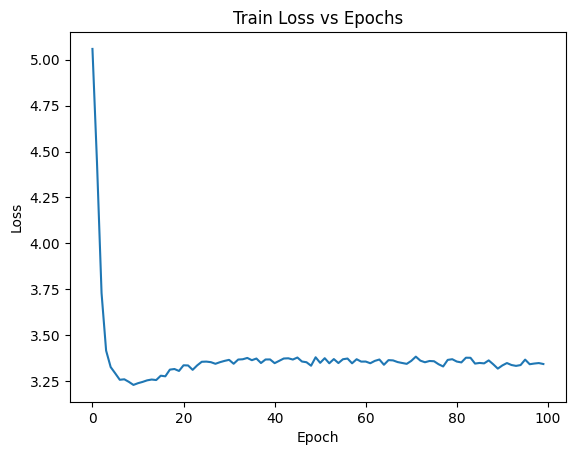

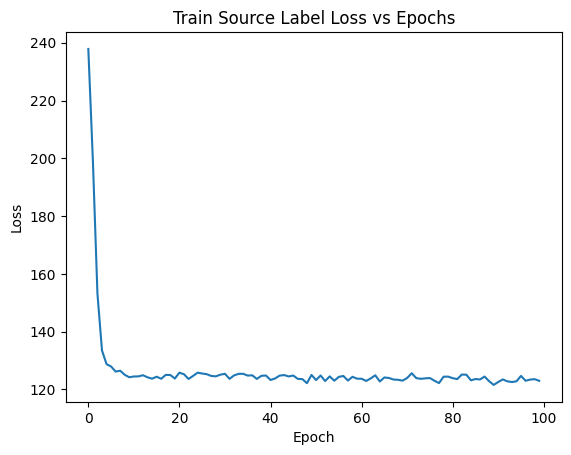

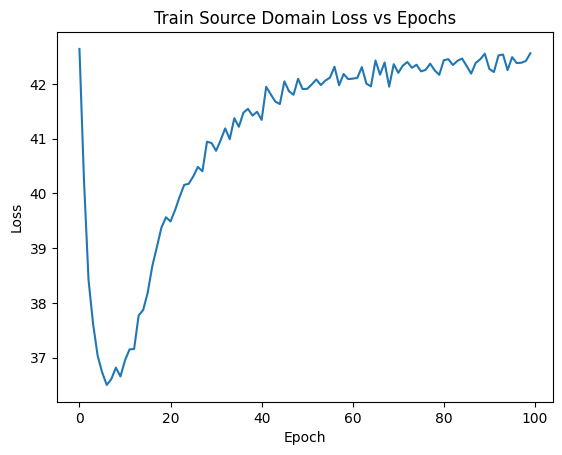

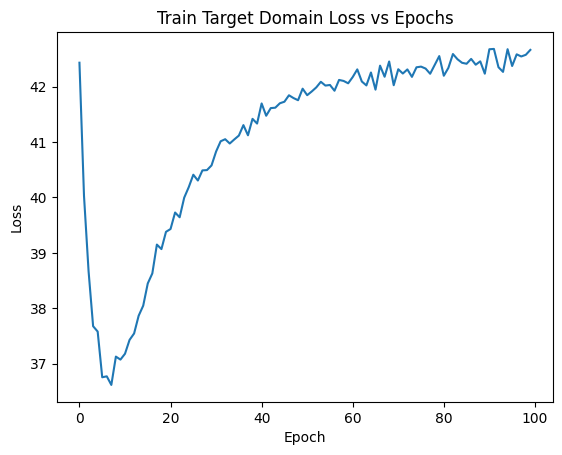

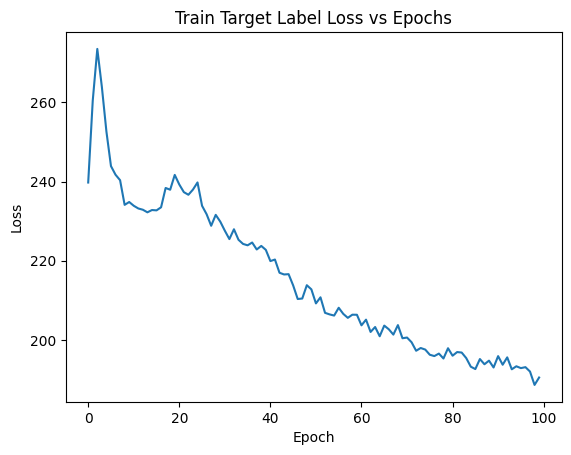

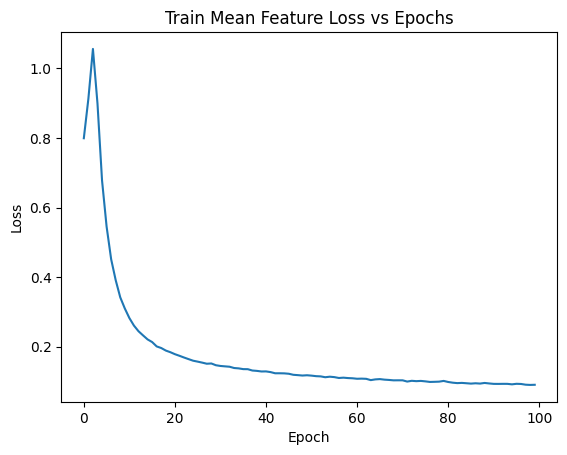

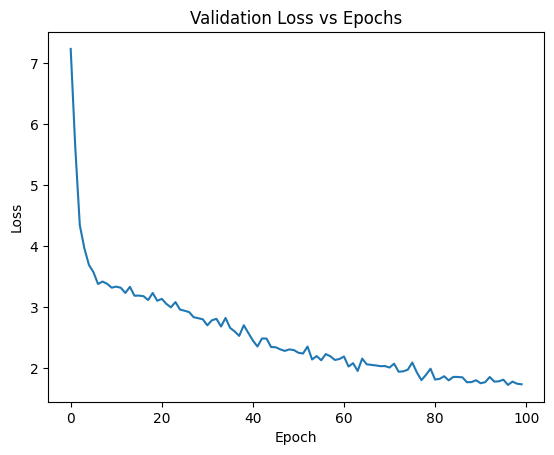

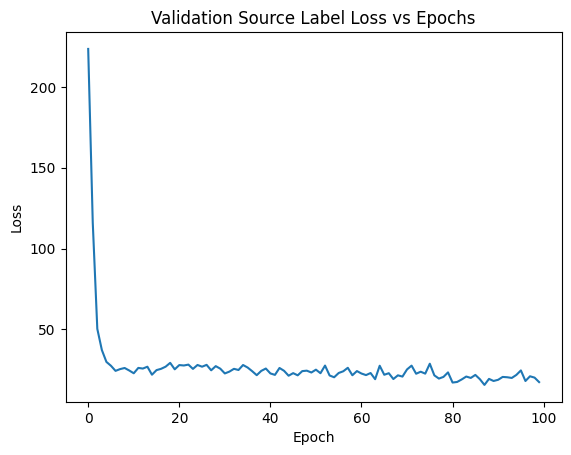

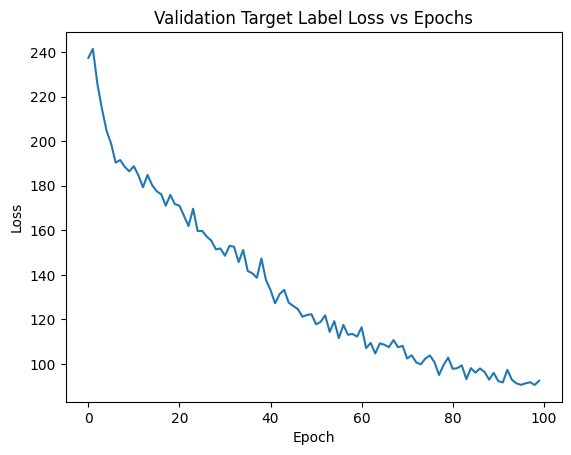

In [14]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_mean_loss.pt", 
                                  scheduler, semisupervised = False, grl = True, mean_loss = True, fixed_alpha = None, fixed_lr = False)

In [16]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_mean_loss.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.63      0.30      0.40        57
           1       0.45      0.85      0.59       155
           2       0.58      0.85      0.69       219
           3       0.42      0.73      0.54       109
           4       0.61      0.68      0.64       232
           5       0.23      0.73      0.35        75
           6       0.34      0.50      0.40        36
           7       0.31      0.87      0.46        70
           8       0.20      0.84      0.32        43
           9       0.79      0.69      0.73       229
          10       0.85      0.73      0.79       322
          11       0.71      0.93      0.80       132
          12       0.86      0.92      0.89       265
          13       0.96      0.96      0.96       285
          14       0.98      0.79      0.87       122
          15       0.96      0.37      0.53       208
          16       0.74      0.17      0.28       263
        

### Mean Loss without GRL

Train Loss: 3.677682638168335: 100%|████████████████████████████████████████████████████| 333/333 [00:09<00:00, 36.57it/s]

Saving at epoch 0


Train Loss: 3.7127413749694824: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.92it/s]


Epoch 0: Train Loss = 3.731485, Val Loss = 7.325530


Train Loss: 2.97668719291687: 100%|████████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 36.27it/s]

Saving at epoch 1


Train Loss: 3.044426918029785: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.25it/s]


Epoch 1: Train Loss = 3.298839, Val Loss = 6.391437


Train Loss: 2.527310609817505: 100%|███████████████████████████████████████████████████▊| 332/333 [00:26<00:00, 13.68it/s]

Saving at epoch 2


Train Loss: 2.5941975116729736: 100%|███████████████████████████████████████████████████| 333/333 [00:32<00:00, 10.12it/s]


Epoch 2: Train Loss = 2.661364, Val Loss = 5.288970


Train Loss: 1.9058600664138794: 100%|███████████████████████████████████████████████████| 333/333 [00:20<00:00, 16.88it/s]

Saving at epoch 3


Train Loss: 2.2127723693847656: 100%|███████████████████████████████████████████████████| 333/333 [00:25<00:00, 12.89it/s]


Epoch 3: Train Loss = 2.358223, Val Loss = 4.426825


Train Loss: 2.2175817489624023: 100%|██████████████████████████████████████████████████▊| 332/333 [00:16<00:00, 19.25it/s]

Saving at epoch 4


Train Loss: 2.043781280517578: 100%|████████████████████████████████████████████████████| 333/333 [00:21<00:00, 15.33it/s]


Epoch 4: Train Loss = 2.235419, Val Loss = 4.003399


Train Loss: 1.9496502876281738: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 17.98it/s]


Epoch 5: Train Loss = 2.186922, Val Loss = 4.073539


Train Loss: 2.249624252319336:  99%|███████████████████████████████████████████████████▌| 330/333 [00:14<00:00, 22.11it/s]

Saving at epoch 6


Train Loss: 2.4610745906829834: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.16it/s]


Epoch 6: Train Loss = 2.145718, Val Loss = 3.795101


Train Loss: 1.9637303352355957: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 27.83it/s]

Saving at epoch 7


Train Loss: 2.138561487197876: 100%|████████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.38it/s]


Epoch 7: Train Loss = 2.142735, Val Loss = 3.703215


Train Loss: 1.9560869932174683: 100%|██████████████████████████████████████████████████▊| 332/333 [00:12<00:00, 33.44it/s]

Saving at epoch 8


Train Loss: 2.0322678089141846: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.18it/s]


Epoch 8: Train Loss = 2.095189, Val Loss = 3.634203


Train Loss: 2.019451141357422:  99%|███████████████████████████████████████████████████▋| 331/333 [00:11<00:00, 28.84it/s]

Saving at epoch 9


Train Loss: 2.5717203617095947: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.09it/s]


Epoch 9: Train Loss = 2.086560, Val Loss = 3.591524


Train Loss: 1.872317910194397: 100%|████████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.74it/s]


Epoch 10: Train Loss = 2.079877, Val Loss = 3.639259


Train Loss: 1.941932201385498: 100%|███████████████████████████████████████████████████▊| 332/333 [00:10<00:00, 34.70it/s]

Saving at epoch 11


Train Loss: 2.0651774406433105: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.04it/s]


Epoch 11: Train Loss = 2.074825, Val Loss = 3.561235


Train Loss: 2.1133604049682617:  99%|██████████████████████████████████████████████████▌| 330/333 [00:15<00:00, 22.49it/s]

Saving at epoch 12


Train Loss: 1.7714414596557617: 100%|███████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.14it/s]


Epoch 12: Train Loss = 2.080534, Val Loss = 3.536440


Train Loss: 1.5819835662841797: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.26it/s]


Epoch 13: Train Loss = 2.089463, Val Loss = 3.692800


Train Loss: 1.982724905014038: 100%|████████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.54it/s]


Epoch 14: Train Loss = 2.066614, Val Loss = 3.595168


Train Loss: 1.9291566610336304: 100%|███████████████████████████████████████████████████| 333/333 [00:10<00:00, 33.24it/s]

Saving at epoch 15


Train Loss: 1.733792781829834: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.36it/s]


Epoch 15: Train Loss = 2.091479, Val Loss = 3.506919


Train Loss: 2.067046642303467: 100%|███████████████████████████████████████████████████▊| 332/333 [00:10<00:00, 36.34it/s]

Saving at epoch 16


Train Loss: 2.016961097717285: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.95it/s]


Epoch 16: Train Loss = 2.054292, Val Loss = 3.490879


Train Loss: 1.9802218675613403:  99%|██████████████████████████████████████████████████▋| 331/333 [00:10<00:00, 34.11it/s]

Saving at epoch 17


Train Loss: 1.7131932973861694: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.10it/s]


Epoch 17: Train Loss = 2.043982, Val Loss = 3.457156


Train Loss: 2.208467721939087:  99%|███████████████████████████████████████████████████▋| 331/333 [00:10<00:00, 31.48it/s]

Saving at epoch 18


Train Loss: 1.8041274547576904: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.94it/s]


Epoch 18: Train Loss = 2.035891, Val Loss = 3.421186


Train Loss: 1.9062477350234985: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.25it/s]


Epoch 19: Train Loss = 2.045580, Val Loss = 3.505883


Train Loss: 2.0642189979553223:  99%|██████████████████████████████████████████████████▌| 330/333 [00:13<00:00, 25.57it/s]

Saving at epoch 20


Train Loss: 1.788806438446045: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.49it/s]


Epoch 20: Train Loss = 2.051669, Val Loss = 3.409257


Train Loss: 1.6855698823928833:  99%|██████████████████████████████████████████████████▋| 331/333 [00:12<00:00, 25.98it/s]

Saving at epoch 21


Train Loss: 2.071584463119507: 100%|████████████████████████████████████████████████████| 333/333 [00:15<00:00, 21.22it/s]


Epoch 21: Train Loss = 2.030758, Val Loss = 3.408032


Train Loss: 1.978731393814087: 100%|████████████████████████████████████████████████████| 333/333 [00:19<00:00, 17.44it/s]


Epoch 22: Train Loss = 2.024993, Val Loss = 3.443437


Train Loss: 2.151897668838501: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 23.75it/s]

Saving at epoch 23


Train Loss: 1.899111270904541: 100%|████████████████████████████████████████████████████| 333/333 [00:17<00:00, 18.79it/s]


Epoch 23: Train Loss = 2.043221, Val Loss = 3.373410


Train Loss: 2.07004976272583: 100%|█████████████████████████████████████████████████████| 333/333 [00:16<00:00, 20.39it/s]


Epoch 24: Train Loss = 2.043616, Val Loss = 3.419208


Train Loss: 2.3171911239624023: 100%|███████████████████████████████████████████████████| 333/333 [00:15<00:00, 22.18it/s]


Epoch 25: Train Loss = 2.028961, Val Loss = 3.455488


Train Loss: 2.054548740386963: 100%|████████████████████████████████████████████████████| 333/333 [00:14<00:00, 22.31it/s]


Epoch 26: Train Loss = 2.026432, Val Loss = 3.422327


Train Loss: 1.8635704517364502:  99%|██████████████████████████████████████████████████▌| 330/333 [00:10<00:00, 33.46it/s]

Saving at epoch 27


Train Loss: 2.1473329067230225: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 23.35it/s]


Epoch 27: Train Loss = 2.048392, Val Loss = 3.364322


Train Loss: 1.9501980543136597: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.08it/s]


Epoch 28: Train Loss = 2.038320, Val Loss = 3.436771


Train Loss: 1.916419267654419: 100%|████████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.38it/s]


Epoch 29: Train Loss = 2.013866, Val Loss = 3.439701


Train Loss: 2.0727953910827637: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.94it/s]


Epoch 30: Train Loss = 2.004959, Val Loss = 3.407882


Train Loss: 1.8824740648269653:  99%|██████████████████████████████████████████████████▌| 330/333 [00:10<00:00, 35.29it/s]

Saving at epoch 31


Train Loss: 1.9227529764175415: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.47it/s]


Epoch 31: Train Loss = 2.013519, Val Loss = 3.334574


Train Loss: 2.2471072673797607: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.19it/s]


Epoch 32: Train Loss = 1.984269, Val Loss = 3.382297


Train Loss: 2.1809864044189453: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.95it/s]


Epoch 33: Train Loss = 2.020875, Val Loss = 3.373231


Train Loss: 1.9928247928619385: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.52it/s]


Epoch 34: Train Loss = 2.021605, Val Loss = 3.375931


Train Loss: 1.5381412506103516: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.57it/s]


Epoch 35: Train Loss = 2.009402, Val Loss = 3.367428


Train Loss: 1.990424633026123: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.25it/s]


Epoch 36: Train Loss = 1.994400, Val Loss = 3.367628


Train Loss: 1.8983346223831177: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.02it/s]


Epoch 37: Train Loss = 1.999644, Val Loss = 3.368850


Train Loss: 1.7806556224822998: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.50it/s]


Epoch 38: Train Loss = 2.024227, Val Loss = 3.369689


Train Loss: 2.130307197570801:  99%|███████████████████████████████████████████████████▌| 330/333 [00:08<00:00, 38.65it/s]

Saving at epoch 39


Train Loss: 2.222585439682007: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.37it/s]


Epoch 39: Train Loss = 1.990770, Val Loss = 3.330893


Train Loss: 1.9328433275222778: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.94it/s]


Epoch 40: Train Loss = 1.995991, Val Loss = 3.390011


Train Loss: 2.0588061809539795: 100%|██████████████████████████████████████████████████▊| 332/333 [00:09<00:00, 41.48it/s]

Saving at epoch 41


Train Loss: 1.962773323059082: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.67it/s]


Epoch 41: Train Loss = 2.001642, Val Loss = 3.317347


Train Loss: 2.0697808265686035: 100%|███████████████████████████████████████████████████| 333/333 [00:18<00:00, 18.12it/s]


Epoch 42: Train Loss = 1.990955, Val Loss = 3.348401


Train Loss: 2.3162944316864014: 100%|███████████████████████████████████████████████████| 333/333 [00:10<00:00, 36.28it/s]

Saving at epoch 43


Train Loss: 1.7969223260879517: 100%|███████████████████████████████████████████████████| 333/333 [00:14<00:00, 23.54it/s]


Epoch 43: Train Loss = 1.971803, Val Loss = 3.292371


Train Loss: 1.9616527557373047: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.29it/s]


Epoch 44: Train Loss = 1.997278, Val Loss = 3.318275


Train Loss: 1.7073942422866821: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.84it/s]


Epoch 45: Train Loss = 2.005494, Val Loss = 3.355339


Train Loss: 1.847123622894287: 100%|███████████████████████████████████████████████████▊| 332/333 [00:10<00:00, 31.59it/s]

Saving at epoch 46


Train Loss: 1.5442229509353638: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 24.88it/s]


Epoch 46: Train Loss = 1.984042, Val Loss = 3.257289


Train Loss: 2.2122089862823486: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.51it/s]


Epoch 47: Train Loss = 1.982664, Val Loss = 3.312309


Train Loss: 2.124417543411255: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.10it/s]


Epoch 48: Train Loss = 1.982764, Val Loss = 3.307790


Train Loss: 1.9796701669692993: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.75it/s]


Epoch 49: Train Loss = 1.977341, Val Loss = 3.278722


Train Loss: 2.536738157272339:  99%|███████████████████████████████████████████████████▋| 331/333 [00:10<00:00, 35.27it/s]

Saving at epoch 50


Train Loss: 1.9540044069290161: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.38it/s]


Epoch 50: Train Loss = 1.989585, Val Loss = 3.226123


Train Loss: 1.9365477561950684: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.27it/s]


Epoch 51: Train Loss = 2.001971, Val Loss = 3.293356


Train Loss: 1.8128883838653564: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.31it/s]


Epoch 52: Train Loss = 1.982689, Val Loss = 3.262845


Train Loss: 2.334986925125122: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.14it/s]


Epoch 53: Train Loss = 1.994196, Val Loss = 3.272103


Train Loss: 2.0768215656280518: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.75it/s]


Epoch 54: Train Loss = 2.013133, Val Loss = 3.247622


Train Loss: 2.1638779640197754: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.22it/s]


Epoch 55: Train Loss = 1.977999, Val Loss = 3.270630


Train Loss: 1.973734974861145: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.92it/s]


Epoch 56: Train Loss = 1.998763, Val Loss = 3.303263


Train Loss: 2.3093602657318115: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.27it/s]


Epoch 57: Train Loss = 1.970949, Val Loss = 3.253114


Train Loss: 1.9425270557403564: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.39it/s]


Epoch 58: Train Loss = 1.979294, Val Loss = 3.235052


Train Loss: 2.380490303039551: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.66it/s]


Epoch 59: Train Loss = 1.964003, Val Loss = 3.258165


Train Loss: 1.9762380123138428: 100%|███████████████████████████████████████████████████| 333/333 [00:17<00:00, 19.07it/s]


Epoch 60: Train Loss = 1.977503, Val Loss = 3.307588


Train Loss: 2.3986892700195312: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 23.80it/s]


Epoch 61: Train Loss = 1.984571, Val Loss = 3.270909


Train Loss: 1.9879164695739746: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.52it/s]


Epoch 62: Train Loss = 1.956284, Val Loss = 3.273360


Train Loss: 1.8892767429351807: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.19it/s]


Epoch 63: Train Loss = 1.965411, Val Loss = 3.228764


Train Loss: 2.6232306957244873:  99%|██████████████████████████████████████████████████▌| 330/333 [00:10<00:00, 30.20it/s]

Saving at epoch 64


Train Loss: 1.6876327991485596: 100%|███████████████████████████████████████████████████| 333/333 [00:13<00:00, 25.52it/s]


Epoch 64: Train Loss = 1.956020, Val Loss = 3.185523


Train Loss: 1.9851939678192139: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.00it/s]


Epoch 65: Train Loss = 1.982133, Val Loss = 3.237980


Train Loss: 2.303487777709961: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.28it/s]


Epoch 66: Train Loss = 1.980262, Val Loss = 3.225515


Train Loss: 1.8229652643203735: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.39it/s]


Epoch 67: Train Loss = 1.995910, Val Loss = 3.250118


Train Loss: 2.295351982116699: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.64it/s]


Epoch 68: Train Loss = 1.975185, Val Loss = 3.277503


Train Loss: 1.5100715160369873: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 26.72it/s]


Epoch 69: Train Loss = 1.972141, Val Loss = 3.248850


Train Loss: 1.7314532995224: 100%|██████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.34it/s]


Epoch 70: Train Loss = 1.973027, Val Loss = 3.235819


Train Loss: 2.0900309085845947: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.58it/s]


Epoch 71: Train Loss = 1.971788, Val Loss = 3.247323


Train Loss: 2.2005698680877686: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.14it/s]


Epoch 72: Train Loss = 1.971496, Val Loss = 3.239086


Train Loss: 1.6711697578430176: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.89it/s]


Epoch 73: Train Loss = 1.992047, Val Loss = 3.196906


Train Loss: 2.1715779304504395: 100%|███████████████████████████████████████████████████| 333/333 [00:09<00:00, 38.15it/s]

Saving at epoch 74


Train Loss: 1.898316502571106: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.04it/s]


Epoch 74: Train Loss = 2.004372, Val Loss = 3.185486


Train Loss: 2.0429162979125977: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.03it/s]


Epoch 75: Train Loss = 1.982149, Val Loss = 3.234091


Train Loss: 2.4536166191101074: 100%|███████████████████████████████████████████████████| 333/333 [00:10<00:00, 30.44it/s]


Epoch 76: Train Loss = 1.971675, Val Loss = 3.235465


Train Loss: 2.142394781112671: 100%|███████████████████████████████████████████████████▊| 332/333 [00:08<00:00, 40.69it/s]

Saving at epoch 77


Train Loss: 2.469777822494507: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 27.89it/s]


Epoch 77: Train Loss = 1.956090, Val Loss = 3.150401


Train Loss: 2.007509469985962: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.26it/s]


Epoch 78: Train Loss = 1.971032, Val Loss = 3.241504


Train Loss: 2.2887189388275146: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.19it/s]


Epoch 79: Train Loss = 1.955898, Val Loss = 3.196595


Train Loss: 2.199082374572754: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.20it/s]


Epoch 80: Train Loss = 1.962196, Val Loss = 3.197190


Train Loss: 2.131269693374634: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.29it/s]


Epoch 81: Train Loss = 1.951473, Val Loss = 3.189881


Train Loss: 2.0807371139526367: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.54it/s]


Epoch 82: Train Loss = 1.965664, Val Loss = 3.202245


Train Loss: 1.847761631011963: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.70it/s]


Epoch 83: Train Loss = 1.948986, Val Loss = 3.207276


Train Loss: 1.926706075668335: 100%|████████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.54it/s]


Epoch 84: Train Loss = 1.955722, Val Loss = 3.185267


Train Loss: 1.9589283466339111: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.86it/s]


Epoch 85: Train Loss = 1.958909, Val Loss = 3.194008


Train Loss: 1.921973466873169: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.84it/s]


Epoch 86: Train Loss = 1.966484, Val Loss = 3.221146


Train Loss: 2.021587610244751: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.92it/s]


Epoch 87: Train Loss = 1.974022, Val Loss = 3.202030


Train Loss: 2.145940065383911: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.51it/s]


Epoch 88: Train Loss = 1.966922, Val Loss = 3.190467


Train Loss: 1.6223063468933105: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.49it/s]


Epoch 89: Train Loss = 1.966933, Val Loss = 3.172601


Train Loss: 2.0242695808410645: 100%|███████████████████████████████████████████████████| 333/333 [00:12<00:00, 27.67it/s]


Epoch 90: Train Loss = 1.970213, Val Loss = 3.181598


Train Loss: 1.5579590797424316: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.19it/s]


Epoch 91: Train Loss = 1.964329, Val Loss = 3.230177


Train Loss: 1.710260033607483: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.15it/s]


Epoch 92: Train Loss = 1.943328, Val Loss = 3.217050


Train Loss: 1.5290398597717285: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.88it/s]


Epoch 93: Train Loss = 1.963716, Val Loss = 3.202465


Train Loss: 2.1802775859832764: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.13it/s]


Epoch 94: Train Loss = 1.963206, Val Loss = 3.233036


Train Loss: 2.420177698135376: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.52it/s]


Epoch 95: Train Loss = 1.958613, Val Loss = 3.198098


Train Loss: 2.279174566268921: 100%|████████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.18it/s]


Epoch 96: Train Loss = 1.962044, Val Loss = 3.163439


Train Loss: 1.8125907182693481: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.29it/s]


Epoch 97: Train Loss = 1.962425, Val Loss = 3.182220


Train Loss: 1.9467216730117798: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 29.55it/s]


Epoch 98: Train Loss = 1.931916, Val Loss = 3.179389


Train Loss: 1.9685394763946533: 100%|███████████████████████████████████████████████████| 333/333 [00:11<00:00, 28.60it/s]

Epoch 99: Train Loss = 1.957529, Val Loss = 3.179967


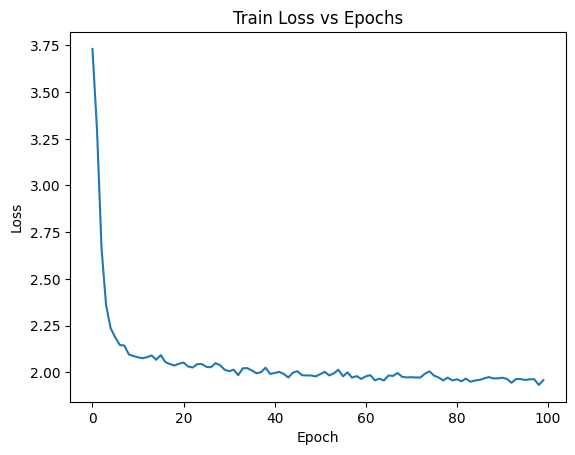

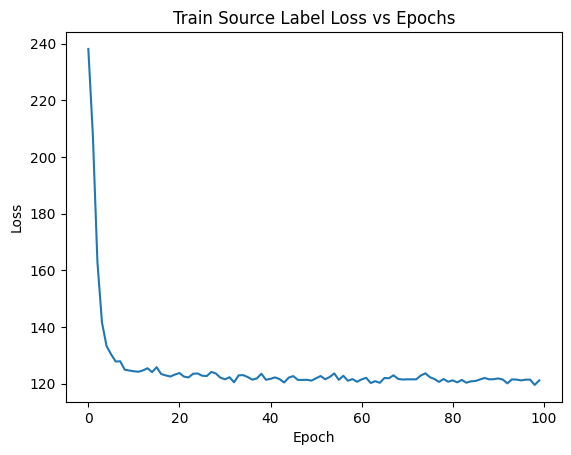

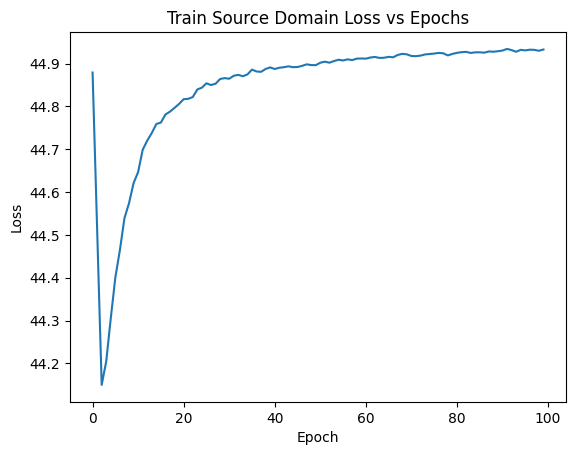

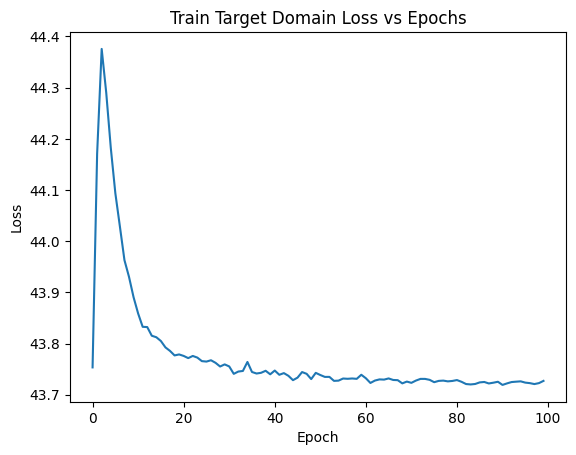

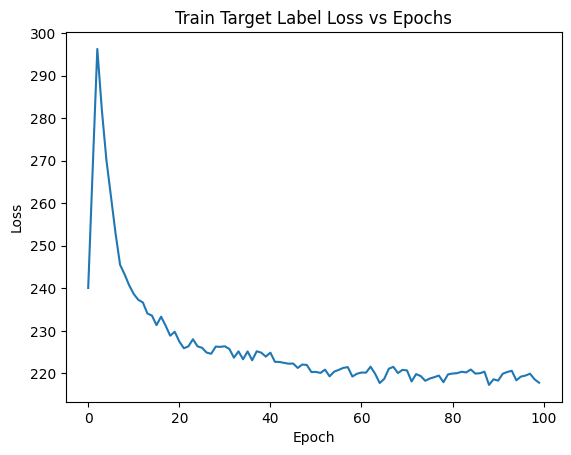

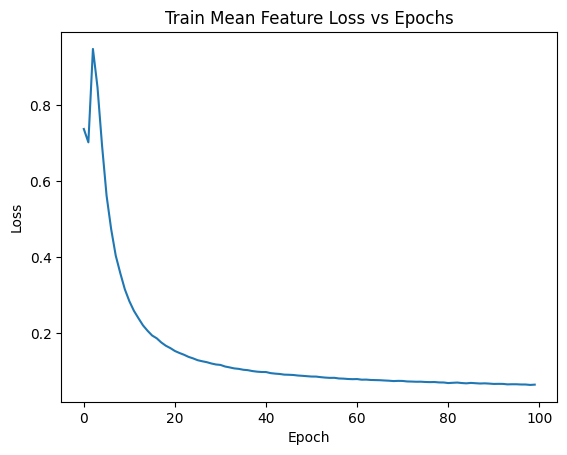

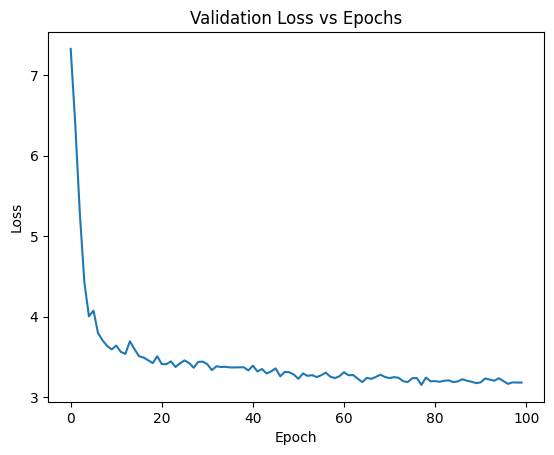

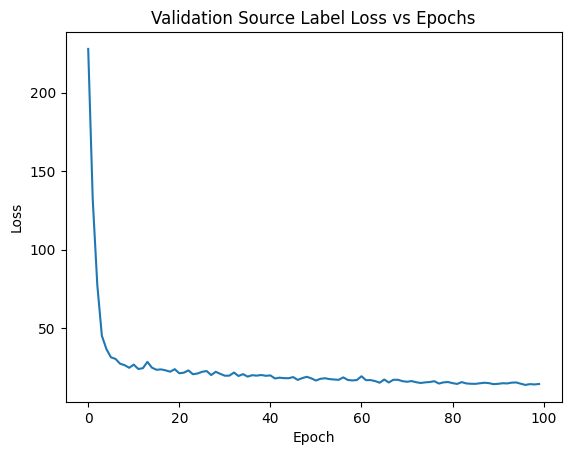

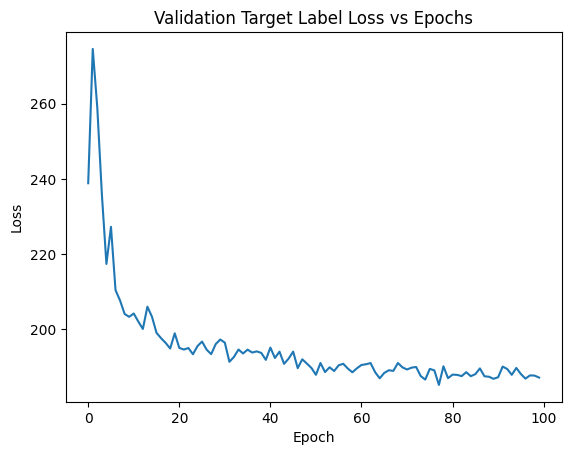

In [18]:
lr = 0.01
model = GTSRB_CNN(True).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
# criteria = [nn.NLLLoss(), nn.BCELoss()]
criteria = [nn.CrossEntropyLoss(), nn.BCELoss()]
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train([source_trainloader, target_trainloader], [source_valloader, target_valloader], 
                                  target_testloader, model, optimizer, criteria, 100, 
                                  "checkpoints/gtsrb/gtsrb_no_grl_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_mean_loss.pt", 
                                  scheduler, semisupervised = False, grl = False, mean_loss = True, fixed_alpha = None, fixed_lr = False)

In [19]:
model_best = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_no_grl_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy_mean_loss.pt"
model_best.load_state_dict(torch.load(model_save_path))
model_best.eval()
evaluate(model_best, target_valloader, True, 0.)

Class Label Report
              precision    recall  f1-score   support

           0       0.22      0.67      0.33         9
           1       0.16      1.00      0.28        47
           2       0.12      0.90      0.21        42
           3       0.04      0.41      0.07        17
           4       0.07      0.86      0.13        21
           5       0.02      1.00      0.03         4
           6       0.00      0.00      0.00        27
           7       0.01      1.00      0.01         1
           8       0.02      0.75      0.03         4
           9       0.33      0.27      0.30       237
          10       0.04      0.41      0.07        27
          11       0.40      0.97      0.56        71
          12       0.64      0.65      0.65       280
          13       0.60      0.74      0.66       232
          14       0.98      0.12      0.21       828
          15       0.19      0.21      0.20        71
          16       0.56      0.29      0.38       122
        

### Source Only Model

In [10]:
def train(train_loader, val_loader, test_loader, model, optimizer, criterion, epochs = 25, model_save_path = "models/best_model.pt", scheduler = None):
    train_losses = []
    val_losses = []
    min_val_loss = np.Inf

    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        pbar = tqdm(total = len(train_loader), position = 0, leave = True)
        train_loss = 0
        val_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            out = model(data, 1.)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().data.item() * data.size(0)
            pbar.update(1)
            pbar.desc= f'Train Loss: {loss.item()}'

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        if scheduler is not None:
            scheduler.step()
            
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                
                out = model(data, 1.)
                loss = criterion(out, target)
                val_loss += loss.cpu().data.item() * data.size(0)
                
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            
        print("Epoch %d: Train Loss = %f, Val Loss = %f" % (epoch, train_loss, val_loss))
        pbar.refresh()
        pbar.close()

    end_time = time.time()
    train_time = end_time - start_time
    
    plot_loss(train_losses, "Train Loss vs Epochs")
    plot_loss(val_losses, "Validation Loss vs Epochs")
    
#     start_time = time.time()
#     model.load_state_dict(torch.load(model_save_path))
#     get_model_size(model)
# #     train_report = evaluate(model, train_loader, criterion)
# #     test_report = evaluate(model, test_loader, criterion)
# #     end_time = time.time()
# #     eval_time = end_time - start_time
#     print("Training time = %f seconds" % (train_time))
# #     print("Evaluation time (on both, train and test sets) = %f seconds" % (eval_time))
            
# #     return train_report, test_report
    return None, None

Train Loss: 1.6450610160827637: 100%|█████████████████████████████████████████████████| 1563/1563 [07:02<00:00,  3.70it/s]


Epoch 0: Train Loss = 157.805893, Val Loss = 4.880070


Train Loss: 1.0509703159332275: 100%|█████████████████████████████████████████████████| 1563/1563 [01:42<00:00, 15.24it/s]


Epoch 1: Train Loss = 121.848771, Val Loss = 1.352504


Train Loss: 1.7655713558197021: 100%|█████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.63it/s]


Epoch 2: Train Loss = 120.740176, Val Loss = 0.775498


Train Loss: 2.217122793197632: 100%|██████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.58it/s]


Epoch 3: Train Loss = 120.385501, Val Loss = 0.768713


Train Loss: 2.4377644062042236: 100%|█████████████████████████████████████████████████| 1563/1563 [01:05<00:00, 23.87it/s]


Epoch 4: Train Loss = 120.180665, Val Loss = 0.505921


Train Loss: 2.2327771186828613: 100%|█████████████████████████████████████████████████| 1563/1563 [01:06<00:00, 23.63it/s]


Epoch 5: Train Loss = 120.527851, Val Loss = 0.308827


Train Loss: 0.9298346042633057: 100%|█████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.05it/s]


Epoch 6: Train Loss = 120.539682, Val Loss = 0.296625


Train Loss: 2.2281060218811035: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.77it/s]


Epoch 7: Train Loss = 120.516638, Val Loss = 0.369989


Train Loss: 1.965049386024475: 100%|██████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.11it/s]


Epoch 8: Train Loss = 121.001383, Val Loss = 0.302105


Train Loss: 2.088113784790039: 100%|██████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.68it/s]


Epoch 9: Train Loss = 119.867993, Val Loss = 0.231541


Train Loss: 1.6269762516021729: 100%|█████████████████████████████████████████████████| 1563/1563 [00:57<00:00, 27.00it/s]


Epoch 10: Train Loss = 120.310877, Val Loss = 0.212875


Train Loss: 1.9842363595962524: 100%|█████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.62it/s]


Epoch 11: Train Loss = 120.275189, Val Loss = 0.199646


Train Loss: 2.0125792026519775: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.09it/s]


Epoch 12: Train Loss = 120.445136, Val Loss = 0.281950


Train Loss: 2.1651792526245117: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.74it/s]


Epoch 13: Train Loss = 120.404000, Val Loss = 0.186005


Train Loss: 2.2362120151519775: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.94it/s]


Epoch 14: Train Loss = 120.105171, Val Loss = 0.174975


Train Loss: 1.7428362369537354: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.24it/s]


Epoch 15: Train Loss = 119.742518, Val Loss = 0.107002


Train Loss: 1.9970723390579224: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.47it/s]


Epoch 16: Train Loss = 119.538554, Val Loss = 0.110498


Train Loss: 1.8696832656860352: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.68it/s]


Epoch 17: Train Loss = 120.666816, Val Loss = 0.136809


Train Loss: 1.972201943397522: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.60it/s]


Epoch 18: Train Loss = 119.796170, Val Loss = 0.282377


Train Loss: 1.9840883016586304: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.92it/s]


Epoch 19: Train Loss = 120.272259, Val Loss = 0.165484


Train Loss: 2.0818557739257812: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.54it/s]


Epoch 20: Train Loss = 119.899923, Val Loss = 0.078182


Train Loss: 1.6357612609863281: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.78it/s]


Epoch 21: Train Loss = 119.766897, Val Loss = 0.169596


Train Loss: 1.8935258388519287: 100%|█████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.73it/s]


Epoch 22: Train Loss = 119.716177, Val Loss = 0.087443


Train Loss: 1.5246087312698364: 100%|█████████████████████████████████████████████████| 1563/1563 [00:58<00:00, 26.62it/s]


Epoch 23: Train Loss = 119.777279, Val Loss = 0.075341


Train Loss: 2.1229240894317627: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.49it/s]


Epoch 24: Train Loss = 119.925635, Val Loss = 0.090711


Train Loss: 1.6201093196868896: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.87it/s]


Epoch 25: Train Loss = 120.310131, Val Loss = 0.089919


Train Loss: 1.7469782829284668: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.09it/s]


Epoch 26: Train Loss = 120.409959, Val Loss = 0.099612


Train Loss: 1.312965989112854: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.80it/s]


Epoch 27: Train Loss = 120.600162, Val Loss = 0.090697


Train Loss: 1.4153242111206055: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.73it/s]


Epoch 28: Train Loss = 119.519624, Val Loss = 0.138544


Train Loss: 2.344156503677368: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.01it/s]


Epoch 29: Train Loss = 119.540439, Val Loss = 0.085786


Train Loss: 1.7399377822875977: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.62it/s]


Epoch 30: Train Loss = 120.275348, Val Loss = 0.072027


Train Loss: 1.4133507013320923: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.79it/s]


Epoch 31: Train Loss = 119.784059, Val Loss = 0.127263


Train Loss: 2.02901029586792: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.30it/s]


Epoch 32: Train Loss = 120.215715, Val Loss = 0.107060


Train Loss: 2.003859758377075: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.52it/s]


Epoch 33: Train Loss = 120.385514, Val Loss = 0.129902


Train Loss: 1.9848109483718872: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.60it/s]


Epoch 34: Train Loss = 119.901560, Val Loss = 0.063945


Train Loss: 1.98564875125885: 100%|███████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.72it/s]


Epoch 35: Train Loss = 120.482824, Val Loss = 0.051196


Train Loss: 1.8580474853515625: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.71it/s]


Epoch 36: Train Loss = 120.153031, Val Loss = 0.046100


Train Loss: 2.2049362659454346: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.73it/s]


Epoch 37: Train Loss = 120.332543, Val Loss = 0.109675


Train Loss: 2.232146739959717: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.96it/s]


Epoch 38: Train Loss = 119.300031, Val Loss = 0.130497


Train Loss: 2.0953125953674316: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.22it/s]


Epoch 39: Train Loss = 119.559535, Val Loss = 0.057858


Train Loss: 1.6201306581497192: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.37it/s]


Epoch 40: Train Loss = 120.354489, Val Loss = 0.173321


Train Loss: 1.276322603225708: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.76it/s]


Epoch 41: Train Loss = 119.949683, Val Loss = 0.066133


Train Loss: 2.320897102355957: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.38it/s]


Epoch 42: Train Loss = 120.395053, Val Loss = 0.118546


Train Loss: 1.6151769161224365: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.22it/s]


Epoch 43: Train Loss = 120.060897, Val Loss = 0.063298


Train Loss: 1.5454317331314087: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.66it/s]


Epoch 44: Train Loss = 120.123362, Val Loss = 0.432774


Train Loss: 2.1799020767211914: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.76it/s]


Epoch 45: Train Loss = 120.866078, Val Loss = 0.127094


Train Loss: 1.8685663938522339: 100%|█████████████████████████████████████████████████| 1563/1563 [01:04<00:00, 24.21it/s]


Epoch 46: Train Loss = 119.906736, Val Loss = 0.101377


Train Loss: 1.4062103033065796: 100%|█████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.74it/s]


Epoch 47: Train Loss = 120.370370, Val Loss = 0.124176


Train Loss: 2.24334979057312: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.37it/s]


Epoch 48: Train Loss = 120.612130, Val Loss = 0.145863


Train Loss: 2.4344606399536133: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.68it/s]


Epoch 49: Train Loss = 120.721351, Val Loss = 0.170541


Train Loss: 2.01912784576416: 100%|███████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.88it/s]


Epoch 50: Train Loss = 120.192869, Val Loss = 0.102160


Train Loss: 2.2296223640441895: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 26.01it/s]


Epoch 51: Train Loss = 120.745100, Val Loss = 0.105361


Train Loss: 1.429404377937317: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.98it/s]


Epoch 52: Train Loss = 120.465849, Val Loss = 0.065928


Train Loss: 1.636182427406311: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.75it/s]


Epoch 53: Train Loss = 121.968667, Val Loss = 0.242665


Train Loss: 1.9961531162261963: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.38it/s]


Epoch 54: Train Loss = 120.363602, Val Loss = 0.291331


Train Loss: 1.7460349798202515: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch 55: Train Loss = 120.626358, Val Loss = 0.158098


Train Loss: 1.7508713006973267: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.11it/s]


Epoch 56: Train Loss = 120.267619, Val Loss = 0.222604


Train Loss: 2.251678466796875: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.25it/s]


Epoch 57: Train Loss = 120.573033, Val Loss = 0.626894


Train Loss: 1.8838880062103271: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.20it/s]


Epoch 58: Train Loss = 121.088988, Val Loss = 0.230618


Train Loss: 2.658454656600952: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.46it/s]


Epoch 59: Train Loss = 122.290250, Val Loss = 0.825166


Train Loss: 2.1057863235473633: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.27it/s]


Epoch 60: Train Loss = 122.273119, Val Loss = 0.261243


Train Loss: 1.8537296056747437: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.52it/s]


Epoch 61: Train Loss = 122.011869, Val Loss = 0.992752


Train Loss: 2.020129680633545: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.45it/s]


Epoch 62: Train Loss = 123.287674, Val Loss = 3.006255


Train Loss: 1.633140206336975: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.76it/s]


Epoch 63: Train Loss = 127.914694, Val Loss = 1.133484


Train Loss: 1.8969560861587524: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.58it/s]


Epoch 64: Train Loss = 129.366517, Val Loss = 3.349356


Train Loss: 1.0386414527893066: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.59it/s]


Epoch 65: Train Loss = 130.853060, Val Loss = 2.530044


Train Loss: 1.9853802919387817: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.52it/s]


Epoch 66: Train Loss = 137.369041, Val Loss = 4.499804


Train Loss: 3.33939790725708: 100%|███████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.64it/s]


Epoch 67: Train Loss = 148.303293, Val Loss = 9.704487


Train Loss: 2.574509859085083: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.29it/s]


Epoch 68: Train Loss = 154.279440, Val Loss = 13.417350


Train Loss: 1.7300444841384888: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.68it/s]


Epoch 69: Train Loss = 151.966100, Val Loss = 14.750207


Train Loss: 2.03098726272583: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.42it/s]


Epoch 70: Train Loss = 150.249041, Val Loss = 20.370130


Train Loss: 2.3244447708129883: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.83it/s]


Epoch 71: Train Loss = 151.812384, Val Loss = 20.690099


Train Loss: 2.940875291824341: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.02it/s]


Epoch 72: Train Loss = 165.077114, Val Loss = 24.610512


Train Loss: 3.0071017742156982: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.33it/s]


Epoch 73: Train Loss = 183.383166, Val Loss = 31.418875


Train Loss: 1.8168002367019653: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.83it/s]


Epoch 74: Train Loss = 176.563533, Val Loss = 29.553812


Train Loss: 2.5152125358581543: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.16it/s]


Epoch 75: Train Loss = 192.511322, Val Loss = 28.880878


Train Loss: 2.290900468826294: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.48it/s]


Epoch 76: Train Loss = 205.907519, Val Loss = 60.842729


Train Loss: 3.44815731048584: 100%|███████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.57it/s]


Epoch 77: Train Loss = 212.245815, Val Loss = 129.908792


Train Loss: 3.2622060775756836: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.69it/s]


Epoch 78: Train Loss = 216.568081, Val Loss = 239.626398


Train Loss: 3.487821340560913: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.76it/s]


Epoch 79: Train Loss = 234.749539, Val Loss = 239.537159


Train Loss: 3.7145609855651855: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.72it/s]


Epoch 80: Train Loss = 242.294593, Val Loss = 239.523959


Train Loss: 3.727832078933716: 100%|██████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.63it/s]


Epoch 81: Train Loss = 239.888077, Val Loss = 239.505037


Train Loss: 3.7060537338256836: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.46it/s]


Epoch 82: Train Loss = 240.170453, Val Loss = 239.494458


Train Loss: 3.741177797317505: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.51it/s]


Epoch 83: Train Loss = 239.657014, Val Loss = 239.487162


Train Loss: 3.759988307952881: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.37it/s]


Epoch 84: Train Loss = 239.724761, Val Loss = 239.477168


Train Loss: 3.7292227745056152: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.07it/s]


Epoch 85: Train Loss = 239.775214, Val Loss = 239.498394


Train Loss: 3.7546799182891846: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.31it/s]


Epoch 86: Train Loss = 239.444087, Val Loss = 239.494116


Train Loss: 3.744556427001953: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.32it/s]


Epoch 87: Train Loss = 239.991582, Val Loss = 239.493523


Train Loss: 3.799135684967041: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.83it/s]


Epoch 88: Train Loss = 240.604147, Val Loss = 239.505396


Train Loss: 3.7867114543914795: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 24.85it/s]


Epoch 89: Train Loss = 239.965988, Val Loss = 239.502504


Train Loss: 3.751101493835449: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.78it/s]


Epoch 90: Train Loss = 239.703284, Val Loss = 239.494706


Train Loss: 3.761291742324829: 100%|██████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.11it/s]


Epoch 91: Train Loss = 239.670081, Val Loss = 239.516650


Train Loss: 3.775815963745117: 100%|██████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.54it/s]


Epoch 92: Train Loss = 239.650207, Val Loss = 239.520143


Train Loss: 3.7823479175567627: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.85it/s]


Epoch 93: Train Loss = 239.669101, Val Loss = 239.516360


Train Loss: 3.7614502906799316: 100%|█████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.18it/s]


Epoch 94: Train Loss = 239.640174, Val Loss = 239.502641


Train Loss: 3.631061315536499: 100%|██████████████████████████████████████████████████| 1563/1563 [00:59<00:00, 26.39it/s]


Epoch 95: Train Loss = 239.784682, Val Loss = 239.503596


Train Loss: 3.7984299659729004: 100%|█████████████████████████████████████████████████| 1563/1563 [01:00<00:00, 25.84it/s]


Epoch 96: Train Loss = 240.053702, Val Loss = 239.512916


Train Loss: 3.7364609241485596: 100%|█████████████████████████████████████████████████| 1563/1563 [01:01<00:00, 25.48it/s]


Epoch 97: Train Loss = 240.451830, Val Loss = 239.522381


Train Loss: 3.7527105808258057: 100%|█████████████████████████████████████████████████| 1563/1563 [01:02<00:00, 25.03it/s]


Epoch 98: Train Loss = 240.180794, Val Loss = 239.499179


Train Loss: 3.764054298400879: 100%|██████████████████████████████████████████████████| 1563/1563 [01:03<00:00, 24.71it/s]

Epoch 99: Train Loss = 239.599783, Val Loss = 239.486895


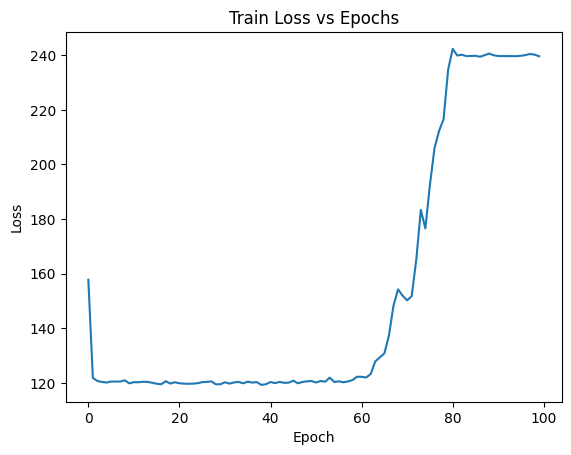

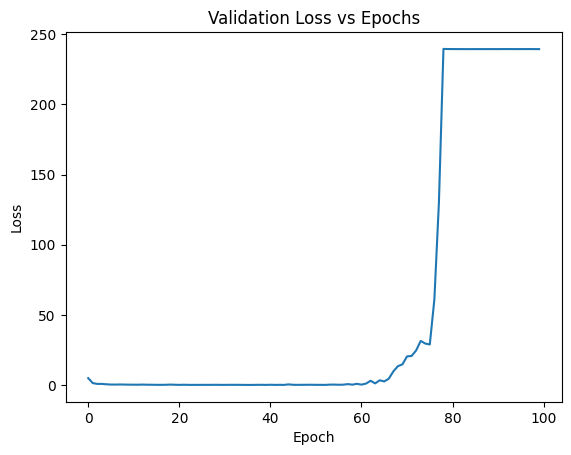

In [13]:
lr = 0.01
source_only_model = GTSRB_CNN(False).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(source_only_model.parameters(), lr = lr, momentum = 0.9)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(source_trainloader, source_valloader, 
                                  target_testloader, source_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_source_only.pt", scheduler)

In [14]:
model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_source_only.pt"
model.load_state_dict(torch.load(model_save_path))
model.eval()
evaluate(model, target_valloader, False)

Class Label Report
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.44      1.00      0.61        33
           2       0.24      0.86      0.37        22
           3       0.19      0.90      0.32        10
           4       0.27      0.94      0.42        18
           5       0.03      1.00      0.05         2
           6       0.25      0.60      0.35         5
           7       0.24      0.62      0.35        13
           8       0.03      0.25      0.06         4
           9       0.38      0.89      0.53        18
          10       0.24      0.53      0.33        36
          11       0.31      0.87      0.46        15
          12       0.79      0.79      0.79        70
          13       0.58      0.77      0.66        48
          14       1.00      0.47      0.63        43
          15       0.42      0.19      0.26        26
          16       0.82      0.31      0.45        29
        

### Target Only Model

Train Loss: 3.24573016166687: 100%|█████████████████████████████████████████████████████| 397/397 [00:50<00:00,  7.87it/s]


Epoch 0: Train Loss = 224.855204, Val Loss = 185.157062


Train Loss: 2.104954481124878: 100%|████████████████████████████████████████████████████| 397/397 [00:18<00:00, 21.42it/s]


Epoch 1: Train Loss = 180.184243, Val Loss = 116.830301


Train Loss: 2.862614631652832: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.67it/s]


Epoch 2: Train Loss = 154.952416, Val Loss = 66.602776


Train Loss: 1.9181947708129883: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.77it/s]


Epoch 3: Train Loss = 134.466879, Val Loss = 33.860082


Train Loss: 1.1251572370529175: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.33it/s]


Epoch 4: Train Loss = 124.475948, Val Loss = 19.007876


Train Loss: 1.8767943382263184: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.67it/s]


Epoch 5: Train Loss = 121.081500, Val Loss = 14.515309


Train Loss: 2.207973003387451: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.93it/s]


Epoch 6: Train Loss = 119.018924, Val Loss = 10.175310


Train Loss: 2.357438564300537: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.68it/s]


Epoch 7: Train Loss = 117.834357, Val Loss = 8.258779


Train Loss: 2.3892760276794434: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.76it/s]


Epoch 8: Train Loss = 116.564140, Val Loss = 9.789997


Train Loss: 1.2250856161117554: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.47it/s]


Epoch 9: Train Loss = 115.308322, Val Loss = 6.088112


Train Loss: 1.2857952117919922: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.10it/s]


Epoch 10: Train Loss = 115.025492, Val Loss = 6.580302


Train Loss: 2.227905511856079: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.72it/s]


Epoch 11: Train Loss = 114.890218, Val Loss = 5.035161


Train Loss: 1.800256609916687: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.26it/s]


Epoch 12: Train Loss = 115.209776, Val Loss = 6.037529


Train Loss: 0.8341206908226013: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.15it/s]


Epoch 13: Train Loss = 114.040835, Val Loss = 3.945083


Train Loss: 1.366926908493042: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.29it/s]


Epoch 14: Train Loss = 112.201685, Val Loss = 4.013483


Train Loss: 1.0899494886398315: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.71it/s]


Epoch 15: Train Loss = 115.023086, Val Loss = 3.250112


Train Loss: 2.684173583984375: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.41it/s]


Epoch 16: Train Loss = 113.406196, Val Loss = 3.552959


Train Loss: 2.207156181335449: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.28it/s]


Epoch 17: Train Loss = 112.585892, Val Loss = 3.866701


Train Loss: 1.2658286094665527: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.88it/s]


Epoch 18: Train Loss = 113.987920, Val Loss = 2.317421


Train Loss: 1.730330228805542: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.70it/s]


Epoch 19: Train Loss = 113.960894, Val Loss = 2.185585


Train Loss: 0.8707275390625: 100%|██████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.17it/s]


Epoch 20: Train Loss = 113.953980, Val Loss = 2.309326


Train Loss: 1.838421106338501: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.73it/s]


Epoch 21: Train Loss = 112.332297, Val Loss = 2.060699


Train Loss: 1.5686688423156738: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.25it/s]


Epoch 22: Train Loss = 114.727472, Val Loss = 2.609758


Train Loss: 1.4778097867965698: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.56it/s]


Epoch 23: Train Loss = 112.406859, Val Loss = 1.899739


Train Loss: 2.1786205768585205: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.37it/s]


Epoch 24: Train Loss = 111.532514, Val Loss = 1.974286


Train Loss: 2.5356485843658447: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 25: Train Loss = 112.331500, Val Loss = 2.098288


Train Loss: 1.4003350734710693: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.33it/s]


Epoch 26: Train Loss = 113.434488, Val Loss = 2.287937


Train Loss: 1.026995301246643: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.32it/s]


Epoch 27: Train Loss = 112.423517, Val Loss = 1.646629


Train Loss: 2.2005367279052734: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 28: Train Loss = 112.367189, Val Loss = 2.221838


Train Loss: 2.306650161743164: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.76it/s]


Epoch 29: Train Loss = 112.259812, Val Loss = 1.620754


Train Loss: 1.4373517036437988: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.33it/s]


Epoch 30: Train Loss = 112.800730, Val Loss = 1.686599


Train Loss: 2.4702565670013428: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.31it/s]


Epoch 31: Train Loss = 113.041707, Val Loss = 1.634492


Train Loss: 1.6144880056381226: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.62it/s]


Epoch 32: Train Loss = 113.002101, Val Loss = 1.721534


Train Loss: 1.6233158111572266: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.80it/s]


Epoch 33: Train Loss = 111.824124, Val Loss = 1.445222


Train Loss: 1.7069952487945557: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.08it/s]


Epoch 34: Train Loss = 112.162525, Val Loss = 1.484606


Train Loss: 0.9655950665473938: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.57it/s]


Epoch 35: Train Loss = 113.528555, Val Loss = 1.297424


Train Loss: 1.5980782508850098: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.78it/s]


Epoch 36: Train Loss = 110.995431, Val Loss = 1.232992


Train Loss: 1.894758701324463: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.72it/s]


Epoch 37: Train Loss = 113.346380, Val Loss = 1.347707


Train Loss: 2.02891206741333: 100%|█████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.39it/s]


Epoch 38: Train Loss = 111.877984, Val Loss = 1.628005


Train Loss: 1.4870741367340088: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.33it/s]


Epoch 39: Train Loss = 112.138330, Val Loss = 1.386789


Train Loss: 2.075237512588501: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.85it/s]


Epoch 40: Train Loss = 112.091886, Val Loss = 1.045232


Train Loss: 2.5326852798461914: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.19it/s]


Epoch 41: Train Loss = 112.482889, Val Loss = 1.119899


Train Loss: 1.9051759243011475: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.64it/s]


Epoch 42: Train Loss = 112.978751, Val Loss = 1.230173


Train Loss: 1.5446730852127075: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 43: Train Loss = 112.642927, Val Loss = 1.430848


Train Loss: 1.9621033668518066: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.04it/s]


Epoch 44: Train Loss = 112.359391, Val Loss = 1.031779


Train Loss: 1.7713960409164429: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.39it/s]


Epoch 45: Train Loss = 114.256177, Val Loss = 1.325091


Train Loss: 0.8546385765075684: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.89it/s]


Epoch 46: Train Loss = 113.815302, Val Loss = 1.444965


Train Loss: 2.7617318630218506: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.75it/s]


Epoch 47: Train Loss = 111.721344, Val Loss = 0.989624


Train Loss: 2.1046886444091797: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.09it/s]


Epoch 48: Train Loss = 113.034949, Val Loss = 1.149827


Train Loss: 1.6454159021377563: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.75it/s]


Epoch 49: Train Loss = 112.139034, Val Loss = 0.869495


Train Loss: 1.7080872058868408: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.19it/s]


Epoch 50: Train Loss = 112.426172, Val Loss = 0.993211


Train Loss: 1.485846996307373: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.82it/s]


Epoch 51: Train Loss = 113.459609, Val Loss = 0.970226


Train Loss: 2.5256378650665283: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.86it/s]


Epoch 52: Train Loss = 112.901136, Val Loss = 0.812190


Train Loss: 1.7435317039489746: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.31it/s]


Epoch 53: Train Loss = 112.933243, Val Loss = 0.857296


Train Loss: 0.929332971572876: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.25it/s]


Epoch 54: Train Loss = 112.007008, Val Loss = 0.959049


Train Loss: 2.1818506717681885: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.63it/s]


Epoch 55: Train Loss = 112.872092, Val Loss = 0.986970


Train Loss: 1.241363763809204: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.85it/s]


Epoch 56: Train Loss = 113.445150, Val Loss = 1.141379


Train Loss: 2.0445377826690674: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.38it/s]


Epoch 57: Train Loss = 111.774240, Val Loss = 0.971559


Train Loss: 1.9120869636535645: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.16it/s]


Epoch 58: Train Loss = 111.971391, Val Loss = 0.897310


Train Loss: 1.84889554977417: 100%|█████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.48it/s]


Epoch 59: Train Loss = 113.147173, Val Loss = 1.029518


Train Loss: 2.741885185241699: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.88it/s]


Epoch 60: Train Loss = 112.487225, Val Loss = 1.177501


Train Loss: 1.9152278900146484: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.37it/s]


Epoch 61: Train Loss = 113.201686, Val Loss = 1.158264


Train Loss: 1.7362360954284668: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.29it/s]


Epoch 62: Train Loss = 112.768439, Val Loss = 0.830117


Train Loss: 1.1162501573562622: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.13it/s]


Epoch 63: Train Loss = 112.595429, Val Loss = 0.960025


Train Loss: 2.3597424030303955: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.27it/s]


Epoch 64: Train Loss = 111.877897, Val Loss = 1.021879


Train Loss: 0.6311489939689636: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.70it/s]


Epoch 65: Train Loss = 112.301495, Val Loss = 1.052081


Train Loss: 1.9043339490890503: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.43it/s]


Epoch 66: Train Loss = 112.026592, Val Loss = 1.012420


Train Loss: 2.4707658290863037: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.27it/s]


Epoch 67: Train Loss = 113.046339, Val Loss = 0.962255


Train Loss: 1.6212401390075684: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.77it/s]


Epoch 68: Train Loss = 111.746721, Val Loss = 0.740362


Train Loss: 2.3880248069763184: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.36it/s]


Epoch 69: Train Loss = 111.800088, Val Loss = 1.341926


Train Loss: 1.5317420959472656: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.87it/s]


Epoch 70: Train Loss = 112.246796, Val Loss = 0.968573


Train Loss: 1.2156751155853271: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.30it/s]


Epoch 71: Train Loss = 113.288107, Val Loss = 0.807317


Train Loss: 1.4117395877838135: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.90it/s]


Epoch 72: Train Loss = 112.090368, Val Loss = 0.695658


Train Loss: 2.16516375541687: 100%|█████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.10it/s]


Epoch 73: Train Loss = 112.940112, Val Loss = 0.872303


Train Loss: 0.9092419147491455: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.81it/s]


Epoch 74: Train Loss = 111.861949, Val Loss = 0.899328


Train Loss: 2.0261659622192383: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.19it/s]


Epoch 75: Train Loss = 113.095462, Val Loss = 0.916775


Train Loss: 2.4309494495391846: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.13it/s]


Epoch 76: Train Loss = 113.795893, Val Loss = 1.176812


Train Loss: 1.8622000217437744: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.14it/s]


Epoch 77: Train Loss = 112.629711, Val Loss = 1.016106


Train Loss: 0.8686172366142273: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.14it/s]


Epoch 78: Train Loss = 112.940759, Val Loss = 0.727618


Train Loss: 2.07643461227417: 100%|█████████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.89it/s]


Epoch 79: Train Loss = 112.274205, Val Loss = 0.908876


Train Loss: 1.9498507976531982: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.29it/s]


Epoch 80: Train Loss = 112.512641, Val Loss = 1.004068


Train Loss: 2.017030954360962: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 29.00it/s]


Epoch 81: Train Loss = 113.248105, Val Loss = 1.017280


Train Loss: 1.6824475526809692: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.34it/s]


Epoch 82: Train Loss = 112.043674, Val Loss = 0.784662


Train Loss: 1.2349791526794434: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.23it/s]


Epoch 83: Train Loss = 112.660348, Val Loss = 0.861983


Train Loss: 1.1270486116409302: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.93it/s]


Epoch 84: Train Loss = 112.704258, Val Loss = 0.952001


Train Loss: 2.324312686920166: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.41it/s]


Epoch 85: Train Loss = 113.321481, Val Loss = 0.877188


Train Loss: 1.4973598718643188: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.36it/s]


Epoch 86: Train Loss = 113.022750, Val Loss = 0.601908


Train Loss: 1.6433892250061035: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.31it/s]


Epoch 87: Train Loss = 111.719733, Val Loss = 0.904150


Train Loss: 1.325928807258606: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.27it/s]


Epoch 88: Train Loss = 111.947059, Val Loss = 2.044208


Train Loss: 1.3311752080917358: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.35it/s]


Epoch 89: Train Loss = 111.380897, Val Loss = 0.565052


Train Loss: 2.0343804359436035: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.78it/s]


Epoch 90: Train Loss = 112.733530, Val Loss = 0.549431


Train Loss: 1.9963688850402832: 100%|███████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.38it/s]


Epoch 91: Train Loss = 112.419764, Val Loss = 0.606228


Train Loss: 1.986823558807373: 100%|████████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.21it/s]


Epoch 92: Train Loss = 112.483786, Val Loss = 0.652409


Train Loss: 2.2786200046539307: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.73it/s]


Epoch 93: Train Loss = 111.597625, Val Loss = 0.573115


Train Loss: 2.300858974456787: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.43it/s]


Epoch 94: Train Loss = 112.491983, Val Loss = 0.782648


Train Loss: 2.2279374599456787: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.64it/s]


Epoch 95: Train Loss = 113.508914, Val Loss = 0.534182


Train Loss: 2.1518900394439697: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.32it/s]


Epoch 96: Train Loss = 112.345801, Val Loss = 0.680745


Train Loss: 2.418693780899048: 100%|████████████████████████████████████████████████████| 397/397 [00:13<00:00, 28.39it/s]


Epoch 97: Train Loss = 113.587496, Val Loss = 0.730027


Train Loss: 2.4322569370269775: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 27.93it/s]


Epoch 98: Train Loss = 113.358599, Val Loss = 0.716785


Train Loss: 2.2739250659942627: 100%|███████████████████████████████████████████████████| 397/397 [00:14<00:00, 28.30it/s]

Epoch 99: Train Loss = 112.098329, Val Loss = 0.719099


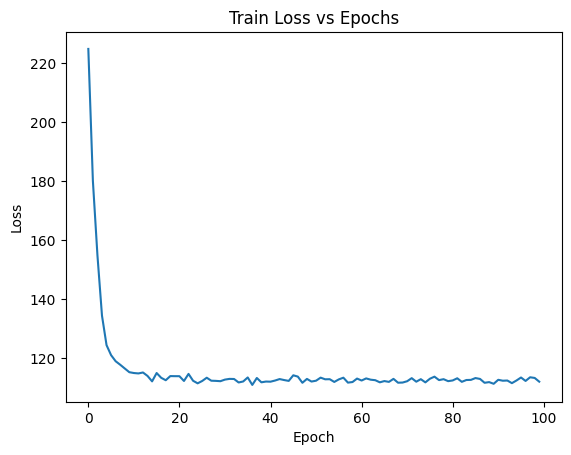

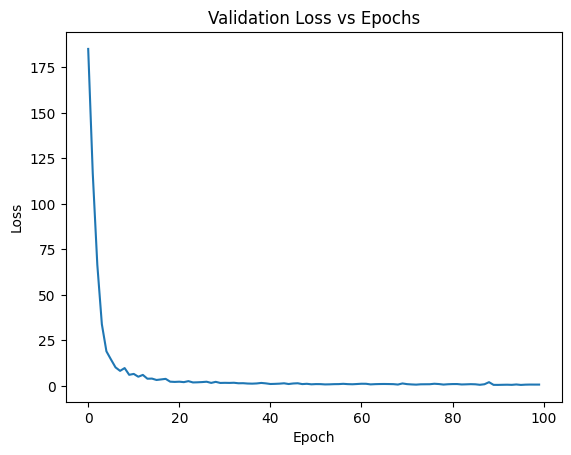

In [15]:
lr = 0.01
target_only_model = GTSRB_CNN(False).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
optimizer = torch.optim.SGD(target_only_model.parameters(), lr = lr, momentum = 0.9)
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)
scheduler = None

train_report, test_report = train(target_trainloader, target_valloader, 
                                  target_testloader, target_only_model, optimizer, criterion, 100, 
                                  "checkpoints/gtsrb/gtsrb_dropout_target_only.pt", scheduler)

In [16]:
model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_target_only.pt"
model.load_state_dict(torch.load(model_save_path))
model.eval()
evaluate(model, target_valloader, False)

Class Label Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        75
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        47
           4       1.00      1.00      1.00        63
           5       1.00      1.00      1.00        72
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00        32
           9       1.00      1.00      1.00        42
          10       1.00      1.00      1.00        78
          11       1.00      1.00      1.00        42
          12       1.00      1.00      1.00        70
          13       1.00      1.00      1.00        64
          14       1.00      1.00      1.00        20
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00        11
        

### Visualize

In [73]:
def visualize2D(source_feats, target_feats):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(2, verbose = 1)
    tsne_proj_source = tsne.fit_transform(source_feats)
    tsne_proj_target = tsne.fit_transform(target_feats)
    
    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap("tab20")
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.scatter(tsne_proj_source[:, 0], tsne_proj_source[:, 1], 
               c = np.array(cmap(0)), label = "Source", alpha = 0.5)
    
    ax.scatter(tsne_proj_target[:, 0], tsne_proj_target[:, 1], 
               c = np.array(cmap(10)), label = "Target", alpha = 0.5)

    ax.legend(fontsize = "large", markerscale = 2)
    plt.show()

In [36]:
def extract_feats(model, loader):
    model = model.to(device)
    all_feats = []
    
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        feats = model.feature(data).cpu().detach().numpy()
        all_feats.append(feats)

    all_feats = np.vstack(np.array(all_feats))
    return all_feats

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 5.367984
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.194920
[t-SNE] KL divergence after 1000 iterations: 0.429916
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 4.397686
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.338760
[t-SNE] KL divergence after 1000 iterations: 0.986293


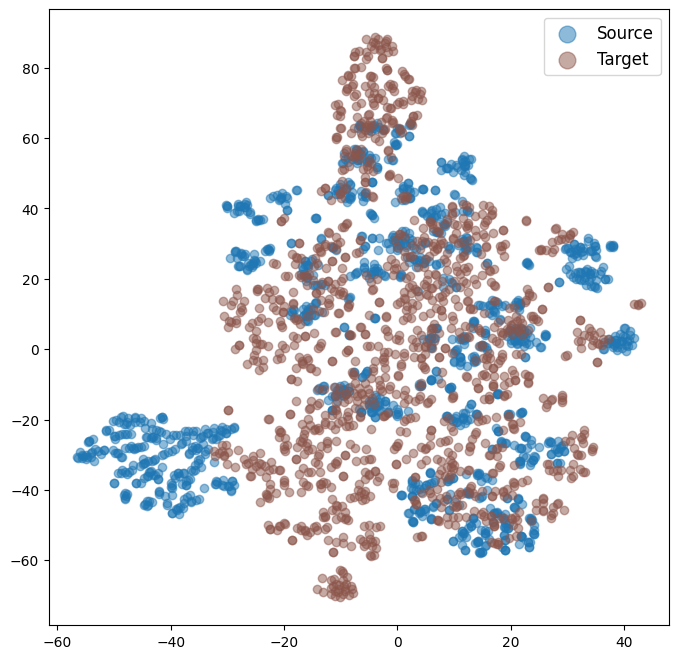

In [41]:
grl_model = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
grl_model.load_state_dict(torch.load(model_save_path))
grl_model.eval()

source_feats = extract_feats(grl_model, source_valloader)[:1280, :]
target_feats = extract_feats(grl_model, target_valloader)[:1280, :]
visualize2D(source_feats, target_feats)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 20.535528
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.877777
[t-SNE] KL divergence after 1000 iterations: 0.391068
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.130s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 3.236740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.968597
[t-SNE] KL divergence after 1000 iterations: 0.846327


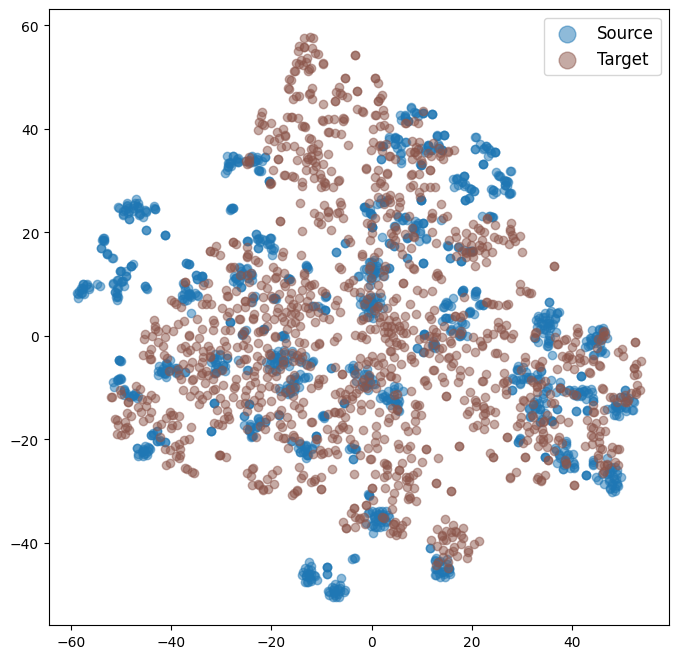

In [42]:
source_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_source_only.pt"
source_only_model.load_state_dict(torch.load(model_save_path))
source_only_model.eval()

source_feats = extract_feats(source_only_model, source_valloader)[:1280, :]
target_feats = extract_feats(source_only_model, target_valloader)[:1280, :]
visualize2D(source_feats, target_feats)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 21.312405
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.076385
[t-SNE] KL divergence after 1000 iterations: 0.530950
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 11.896136
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.798012
[t-SNE] KL divergence after 1000 iterations: 0.766675


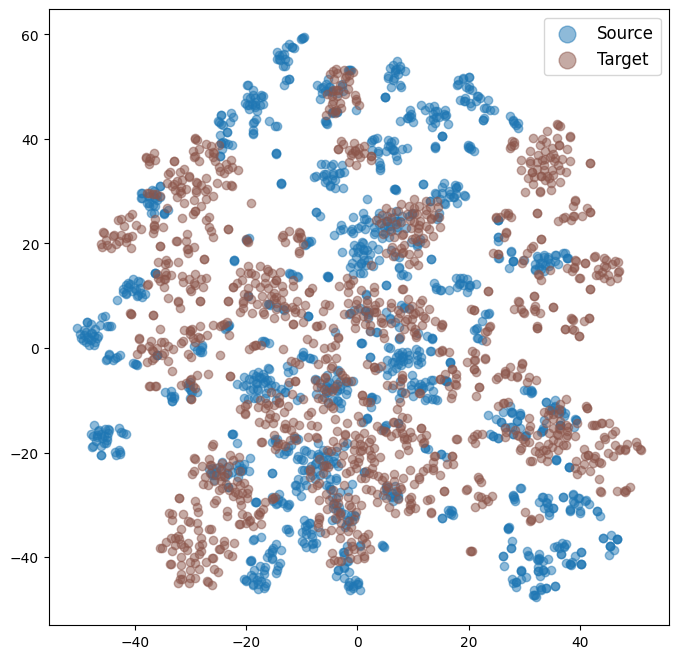

In [44]:
target_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_target_only.pt"
target_only_model.load_state_dict(torch.load(model_save_path))
target_only_model.eval()

source_feats = extract_feats(target_only_model, source_valloader)[:1280, :]
target_feats = extract_feats(target_only_model, target_valloader)[:1280, :]
visualize2D(source_feats, target_feats)

In [70]:
def visualize3D(source_feats, target_feats):
    # Create a two dimensional t-SNE projection of the embeddings
    tsne = TSNE(3, verbose = 1)
    tsne_proj_source = tsne.fit_transform(source_feats)
    tsne_proj_target = tsne.fit_transform(target_feats)
    
    # Plot those points as a scatter plot and label them based on the pred labels
    cmap = cm.get_cmap("tab20")
    # fig, ax = plt.subplots(figsize=(8, 8))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = "3d")
    
    ax.scatter(tsne_proj_source[:, 0], tsne_proj_source[:, 1], tsne_proj_source[:, 2],
               c = np.array(cmap(0)), label = "Source", alpha = 0.5)
    
    ax.scatter(tsne_proj_target[:, 0], tsne_proj_target[:, 1], tsne_proj_target[:, 2],
               c = np.array(cmap(10)), label = "Target", alpha = 0.5)

    ax.legend(fontsize = "large", markerscale = 2)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.624628
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.237835
[t-SNE] KL divergence after 1000 iterations: 0.332969
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 4.478326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.233398


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.802340


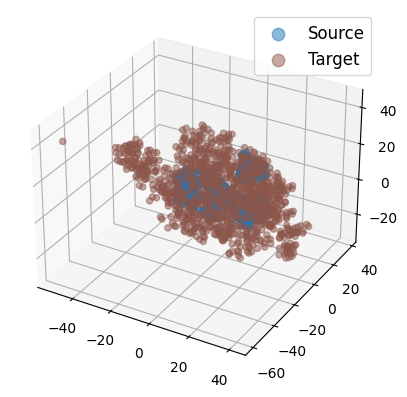

In [71]:
grl_model = GTSRB_CNN(True).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_sgd_mom_0_9_lr_0_01_anneal_cross_entropy.pt"
grl_model.load_state_dict(torch.load(model_save_path))
grl_model.eval()

source_feats = extract_feats(grl_model, source_valloader)[:1000, :]
target_feats = extract_feats(grl_model, target_valloader)[:1000, :]
visualize3D(source_feats, target_feats)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.003s...
[t-SNE] Computed neighbors for 1280 samples in 0.174s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 20.592178
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.383377
[t-SNE] KL divergence after 1000 iterations: 0.315390
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1280 samples in 0.002s...
[t-SNE] Computed neighbors for 1280 samples in 0.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1280
[t-SNE] Computed conditional probabilities for sample 1280 / 1280
[t-SNE] Mean sigma: 3.236740
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.599731


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[t-SNE] KL divergence after 1000 iterations: 0.688792


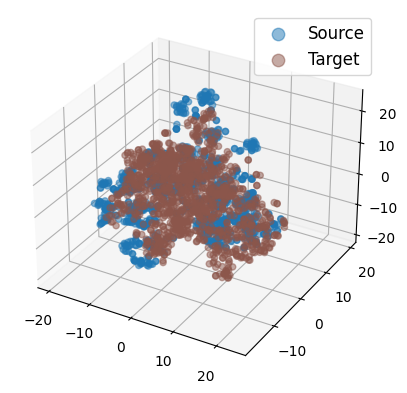

In [72]:
source_only_model = GTSRB_CNN(False).to(device)
model_save_path = "checkpoints/gtsrb/gtsrb_dropout_source_only.pt"
source_only_model.load_state_dict(torch.load(model_save_path))
source_only_model.eval()

source_feats = extract_feats(source_only_model, source_valloader)[:1280, :]
target_feats = extract_feats(source_only_model, target_valloader)[:1280, :]
visualize3D(source_feats, target_feats)